In [7]:
import csv
from datetime import datetime
import numpy as np
import trompy as tp

def get_FEDevents(filename, eventname):
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']
    
    try:
        file = open(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []
    
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = []
    for row in csvreader:
        rows.append(row)

    # Check if rows are empty
    if len(rows) == 0:
        print(f"No data found in file: {filename}")
        return []

    # Determine which format should be used
    try:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[0])
        date_format = formats[0]
    except ValueError:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[1])
        date_format = formats[1]

    timestamps = []
    for row in rows: 
        if row[7] == eventname:  # Check event column
            date_time_obj = datetime.strptime(row[0], date_format)
            timestamps.append(date_time_obj)

    if len(timestamps) == 0:
        print(f"No {eventname} events found in file: {filename}")
        return []

    t0 = rows[0][0]
    day = t0.split()[0] 
    lightson = day + " 07:00:00"
    refpoint = datetime.strptime(lightson, date_format)
    
    pellettimes = []
    for t in timestamps:
        Deltat = t - refpoint
        Deltatinseconds = Deltat.total_seconds()
        Deltatinhours = Deltatinseconds / 3600
        pellettimes.append(Deltatinhours)

    return pellettimes

def get_data_subset(dictionary, selectors, verbose=True):
    output_dictionary = dictionary.copy()
    for key, value in selectors.items():
        for mouse_id in dictionary.keys():
            try:
                if output_dictionary[mouse_id][key] != value:
                    output_dictionary.pop(mouse_id)
            except KeyError: 
                pass

    if verbose:
        print("{} items in output dictionary".format(len(output_dictionary.keys())))
    
    return output_dictionary

def get_data_fields(dictionary, fields, selectors):
    output_list = []
    reduced_dictionary = get_data_subset(dictionary, selectors)
    
    if len(reduced_dictionary.keys()) > 0:
        for field in fields:
            output_sublist = []
            try:
                for key in reduced_dictionary.keys():
                    output_sublist.append(reduced_dictionary[key][field])
            except KeyError:
                print("{} is not a key in selected dictionary".format(field))
                return
            output_list.append(output_sublist)
    else:
        print("No data in fields in selected dictionary")

    if len(output_list) == 1:
        output_list = output_list[0]
        
    return output_list
# Function to get meal, snack, and mega meal metrics, including mega_meal_frequency and mega_meal_size
def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60):
    if not pellettimes:
        return (0, 0, 0, 0, 0, 0, 0, 0, [[0]*24]*7, [[0]*24]*7, [[0]*24]*7, 0, 0, 0, 0)

    IPIs = np.diff(np.array(pellettimes))
    meals = []
    snacks = []
    mega_meals = []
    current_event = [pellettimes[0]]

    # Hourly tracking for each day
    hourly_meals_per_day = [[0]*24 for _ in range(7)]
    hourly_snacks_per_day = [[0]*24 for _ in range(7)]
    hourly_mega_meals_per_day = [[0]*24 for _ in range(7)]

    for i, ipi in enumerate(IPIs):
        if ipi <= meal_threshold:
            current_event.append(pellettimes[i + 1])
        else:
            if len(current_event) == 1:
                snacks.append(current_event)
                day_index = int(current_event[0] // 24)
                hour = int(current_event[0]) % 24
                if day_index < 7:  # Make sure we are within the 7-day boundary
                    hourly_snacks_per_day[day_index][hour] += 1
            elif 2 <= len(current_event) <= 4:
                meals.append(current_event)
                day_index = int(current_event[0] // 24)
                hour = int(current_event[0]) % 24
                if day_index < 7:
                    hourly_meals_per_day[day_index][hour] += 1
            elif len(current_event) >= 5:
                mega_meals.append(current_event)
                day_index = int(current_event[0] // 24)
                hour = int(current_event[0]) % 24
                if day_index < 7:
                    hourly_mega_meals_per_day[day_index][hour] += 1
            current_event = [pellettimes[i + 1]]

    # Handle the last sequence
    if current_event:
        day_index = int(current_event[0] // 24)
        hour = int(current_event[0]) % 24
        if len(current_event) == 1:
            snacks.append(current_event)
            if day_index < 7:
                hourly_snacks_per_day[day_index][hour] += 1
        elif 2 <= len(current_event) <= 4:
            meals.append(current_event)
            if day_index < 7:
                hourly_meals_per_day[day_index][hour] += 1
        elif len(current_event) >= 5:
            mega_meals.append(current_event)
            if day_index < 7:
                hourly_mega_meals_per_day[day_index][hour] += 1

    nmeals = len(meals)
    nsnacks = len(snacks)
    n_mega_meals = len(mega_meals)  # Add the number of mega meals

    total_pellets = len(pellettimes)
    mealsize = sum(len(meal) for meal in meals) / nmeals if nmeals else 0
    snack_size = sum(len(snack) for snack in snacks) / nsnacks if nsnacks else 0
    total_observation_period = max(pellettimes) - min(pellettimes)
    meal_frequency = nmeals / total_observation_period if total_observation_period > 0 else 0
    snack_frequency = nsnacks / total_observation_period if total_observation_period > 0 else 0
    mega_meal_frequency = n_mega_meals / total_observation_period if total_observation_period > 0 else 0
    average_mega_meal_size = sum(len(meal) for meal in mega_meals) / n_mega_meals if n_mega_meals else 0

    return (mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, 
            mega_meal_frequency, average_mega_meal_size, hourly_meals_per_day, 
            hourly_snacks_per_day, hourly_mega_meals_per_day, meals, snacks, mega_meals, n_mega_meals)


# Function to get events (meals, snacks, mega meals) per day based on timestamps
def get_events_per_day(events, days=7):
    events_per_day = [0] * days  # Initialize with zeros for the duration of the phase
    for event_list in events:
        if len(event_list) > 0:
            event_day = int(event_list[0] // 24)
            if event_day < days:
                events_per_day[event_day] += 1
    return events_per_day

# Function to calculate pellets per day
def get_pellets_per_day(timestamps, days=7):
    pellets_per_day = [0] * days
    for day in range(days):
        pellets = [t for t in timestamps if (t > day * 24) and (t < (day + 1) * 24)]
        n_pellets = len(pellets)
        pellets_per_day[day] = n_pellets

    return pellets_per_day


# Function to calculate inter-pellet intervals (IPI)
def get_interpellet_intervals(pellettimes):
    IPIs = np.diff(pellettimes)
    return IPIs

# Function to calculate intermeal intervals (IMI)
def get_intermeal_interval(pellettimes, meal_threshold=1/60):
    IPIs = np.diff(pellettimes)
    IMIs = [x for x in IPIs if x > meal_threshold]
    average_IMI = np.mean(IMIs) if IMIs else 0  # Handle case with no IMIs
    return average_IMI

# Load the metafile and process the data
metafile = "..\\FEDProtein_METAFILE.xls"
rows, header = tp.metafilereader(metafile, sheetname="METAFILE")

mice = {}
for row in rows:
    mouse_id = row[1]
    if mouse_id not in mice.keys():
        mice[mouse_id] = {}
        mice[mouse_id]["sex"] = row[4]
        mice[mouse_id]["order"] = row[5]

for key in mice.keys():
    for row in rows:
        if row[1] == key and row[3] == "FF":
            filename = "..\\data\\{}".format(row[0])
            if row[2] == "GRAIN":
                mice[key]["grain_timestamps"] = get_FEDevents(filename, "Pellet")
            elif row[2] == "PR":
                mice[key]["pr_timestamps"] = get_FEDevents(filename, "Pellet")
            elif row[2] == "NR":
                mice[key]["nr_timestamps"] = get_FEDevents(filename, "Pellet")
            else:
                print(row[2], "is not a valid type of pellet for", key)

# Add meal, snack, mega meal metrics, and IMI, IPI calculations to the dictionary
for key in mice.keys():
    grain_timestamps = mice[key].get("grain_timestamps", [])
    pr_timestamps = mice[key].get("pr_timestamps", [])
    nr_timestamps = mice[key].get("nr_timestamps", [])

    # Get metrics for GRAIN, PR, and NR phases
    grain_metrics = get_meal_and_snack_metrics(grain_timestamps)
    pr_metrics = get_meal_and_snack_metrics(pr_timestamps)
    nr_metrics = get_meal_and_snack_metrics(nr_timestamps)

    # GRAIN phase
    (
        mice[key]["grain_meal_size"],
        mice[key]["grain_snack_size"],
        mice[key]["grain_number_of_meals"],
        mice[key]["grain_meal_frequency"],
        mice[key]["grain_number_of_snacks"],
        mice[key]["grain_snack_frequency"],
        mice[key]["grain_mega_meal_frequency"],
        mice[key]["grain_mega_meal_size"],
        mice[key]["grain_hourly_meals"],
        mice[key]["grain_hourly_snacks"],
        mice[key]["grain_hourly_mega_meals"],
        grain_meals,
        grain_snacks,
        grain_mega_meals,
        mice[key]["grain_number_of_mega_meals"]  # Store the number of mega meals
    ) = grain_metrics

    # PR phase
    (
        mice[key]["pr_meal_size"],
        mice[key]["pr_snack_size"],
        mice[key]["pr_number_of_meals"],
        mice[key]["pr_meal_frequency"],
        mice[key]["pr_number_of_snacks"],
        mice[key]["pr_snack_frequency"],
        mice[key]["pr_mega_meal_frequency"],
        mice[key]["pr_mega_meal_size"],
        mice[key]["pr_hourly_meals"],
        mice[key]["pr_hourly_snacks"],
        mice[key]["pr_hourly_mega_meals"],
        pr_meals,
        pr_snacks,
        pr_mega_meals,
        mice[key]["pr_number_of_mega_meals"]  # Store the number of mega meals
    ) = pr_metrics

    # NR phase
    (
        mice[key]["nr_meal_size"],
        mice[key]["nr_snack_size"],
        mice[key]["nr_number_of_meals"],
        mice[key]["nr_meal_frequency"],
        mice[key]["nr_number_of_snacks"],
        mice[key]["nr_snack_frequency"],
        mice[key]["nr_mega_meal_frequency"],
        mice[key]["nr_mega_meal_size"],
        mice[key]["nr_hourly_meals"],
        mice[key]["nr_hourly_snacks"],
        mice[key]["nr_hourly_mega_meals"],
        nr_meals,
        nr_snacks,
        nr_mega_meals,
        mice[key]["nr_number_of_mega_meals"]  # Store the number of mega meals
    ) = nr_metrics

    # Events per day and pellets per day (as previously done)
    mice[key]["grain_meals_per_day"] = get_events_per_day(grain_meals, days=3)
    mice[key]["pr_meals_per_day"] = get_events_per_day(pr_meals, days=7)
    mice[key]["nr_meals_per_day"] = get_events_per_day(nr_meals, days=7)

    mice[key]["grain_snacks_per_day"] = get_events_per_day(grain_snacks, days=3)
    mice[key]["pr_snacks_per_day"] = get_events_per_day(pr_snacks, days=7)
    mice[key]["nr_snacks_per_day"] = get_events_per_day(nr_snacks, days=7)

    mice[key]["grain_mega_meals_per_day"] = get_events_per_day(grain_mega_meals, days=3)
    mice[key]["pr_mega_meals_per_day"] = get_events_per_day(pr_mega_meals, days=7)
    mice[key]["nr_mega_meals_per_day"] = get_events_per_day(nr_mega_meals, days=7)

    mice[key]["grain_pellets_per_day"] = get_pellets_per_day(mice[key]["grain_timestamps"], days=3)
    mice[key]["pr_pellets_per_day"] = get_pellets_per_day(mice[key]["pr_timestamps"], days=7)
    mice[key]["nr_pellets_per_day"] = get_pellets_per_day(mice[key]["nr_timestamps"], days=7)


# Now combine events and pellets per day for the entire 17-day time course (as before)
for key in mice.keys():
    # Combine pellets per day
    mice[key]["all_pellets_per_day"] = (
        mice[key].get("grain_pellets_per_day", [0] * 3) +
        mice[key].get("pr_pellets_per_day", [0] * 7) +
        mice[key].get("nr_pellets_per_day", [0] * 7)
    )

    # Combine meals per day
    mice[key]["all_meals_per_day"] = (
        mice[key].get("grain_meals_per_day", [0] * 3) +
        mice[key].get("pr_meals_per_day", [0] * 7) +
        mice[key].get("nr_meals_per_day", [0] * 7)
    )

    # Combine snacks per day
    mice[key]["all_snacks_per_day"] = (
        mice[key].get("grain_snacks_per_day", [0] * 3) +
        mice[key].get("pr_snacks_per_day", [0] * 7) +
        mice[key].get("nr_snacks_per_day", [0] * 7)
    )

    # Combine mega meals per day
    mice[key]["all_mega_meals_per_day"] = (
        mice[key].get("grain_mega_meals_per_day", [0] * 3) +
        mice[key].get("pr_mega_meals_per_day", [0] * 7) +
        mice[key].get("nr_mega_meals_per_day", [0] * 7)
    )

# Output the results to check the data structure
for key, value in mice.items():
    print(f"Mouse {key}:")
    print("  Pellets per day:", mice[key]["all_pellets_per_day"])
    print("  Meals per day:", mice[key]["all_meals_per_day"])
    print("  Snacks per day:", mice[key]["all_snacks_per_day"])
    print("  Mega Meals per hour:", mice[key]["nr_hourly_mega_meals"])
    print("  Mega Meals Frequency:", mice[key]["nr_mega_meal_frequency"])
    print("  Mega Meals Size:", mice[key]["nr_mega_meal_size"])

Mouse FEDXA01:
  Pellets per day: [340, 271, 224, 161, 155, 176, 184, 215, 231, 240, 246, 234, 222, 211, 241, 223, 219]
  Meals per day: [43, 25, 23, 35, 28, 31, 24, 24, 31, 14, 9, 18, 18, 15, 13, 9, 6]
  Snacks per day: [30, 18, 25, 32, 44, 52, 62, 28, 25, 13, 13, 14, 14, 19, 18, 12, 13]
  Mega Meals per hour: [[0, 0, 0, 2, 1, 2, 1, 0, 1, 0, 2, 1, 1, 1, 1, 2, 3, 3, 1, 2, 0, 1, 1, 1], [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 2, 1, 2, 3, 3, 2, 1, 2, 0, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 0, 1, 0, 0, 3], [0, 2, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 0, 1, 1, 1, 0], [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 2, 1, 4, 2, 3, 2, 0, 1, 0, 1, 1], [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 0, 2], [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 2, 1, 1, 1, 1, 1, 2]]
  Mega Meals Frequency: 1.0133227626203154
  Mega Meals Size: 7.27810650887574
Mouse FEDXA02:
  Pellets per day: [304, 214, 194, 154, 153, 204, 211, 203, 226, 214, 225,

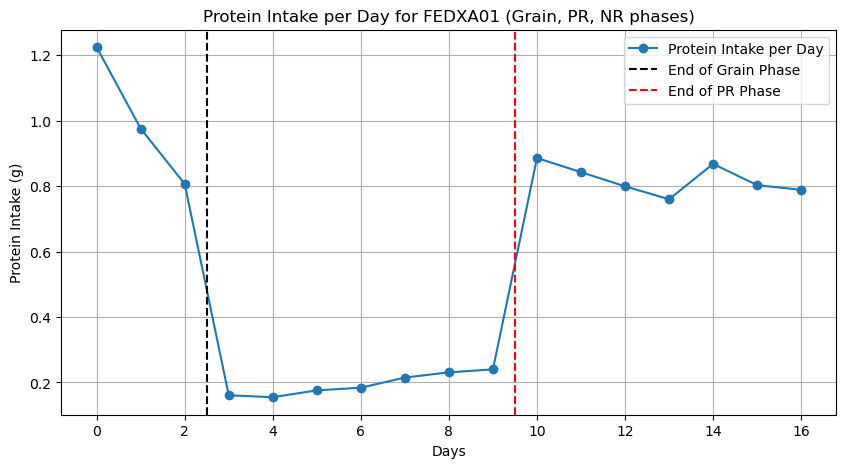

In [9]:
import matplotlib.pyplot as plt

# Constants for protein content per pellet
NR_PROTEIN_PER_PELLET = 0.0036  # grams of protein in NR (Grain and NR)
PR_PROTEIN_PER_PELLET = 0.001   # grams of protein in PR

# Function to convert pellet counts to protein intake
def convert_pellets_to_protein(all_pellets_per_day):
    # First 3 days: Grain phase (same as NR phase)
    grain_protein = [pellets * NR_PROTEIN_PER_PELLET for pellets in all_pellets_per_day[:3]]

    # Next 7 days: PR phase
    pr_protein = [pellets * PR_PROTEIN_PER_PELLET for pellets in all_pellets_per_day[3:10]]

    # Last 7 days: NR phase
    nr_protein = [pellets * NR_PROTEIN_PER_PELLET for pellets in all_pellets_per_day[10:]]

    # Combine all phases together for plotting
    all_protein = grain_protein + pr_protein + nr_protein
    return all_protein

# Assuming the dictionary `mice` already contains the data
# We will loop over each mouse and convert the `all_pellets_per_day` to protein intake

for key in mice.keys():
    all_pellets_per_day = mice[key]["all_pellets_per_day"]
    protein_intake_per_day = convert_pellets_to_protein(all_pellets_per_day)
    mice[key]["protein_intake_per_day"] = protein_intake_per_day  # Save protein intake in dictionary

# Now, let’s plot the protein intake for one of the mice, for example, Mouse 1 (replace with actual ID)
mouse_id = "FEDXA01"  # Replace with actual mouse ID
protein_intake = mice[mouse_id]["protein_intake_per_day"]

# Plotting the protein intake per day
plt.figure(figsize=(10, 5))
plt.plot(protein_intake, label="Protein Intake per Day", marker='o')

# Mark phases with vertical lines
plt.axvline(2.5, color='k', linestyle='--', label="End of Grain Phase")
plt.axvline(9.5, color='r', linestyle='--', label="End of PR Phase")

# Label the plot
plt.title(f"Protein Intake per Day for {mouse_id} (Grain, PR, NR phases)")
plt.xlabel("Days")
plt.ylabel("Protein Intake (g)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Optionally save the plot
# plt.savefig(f"protein_intake_per_day_{mouse_id}.png")




#### 1. **Understanding the Diet Composition**:
   - The composition file provided by BioServ shows the **percentage of protein** in each diet.
   
     - **Grain Diet**: 21.3% protein (21.3 grams of protein per 100 grams of pellets).
     - **NR Diet** (20% Casein): 18% protein (18 grams of protein per 100 grams of pellets).
     - **PR Diet** (5% Casein): 5% protein (5 grams of protein per 100 grams of pellets).

#### 2. **Pellet Weight**:
   - Each pellet weighs **20 mg** (or **0.02 grams**).
   - This is an important factor because we are calculating the protein content for **one pellet** (0.02 grams), not 100 grams of pellets (the usual reference for the percentage of protein).

#### 3. **Formula for Protein Content per Pellet**:
   The formula to calculate the protein content per pellet is:
   \[
   \text{Protein per pellet (g)} = \text{Pellet weight (g)} \times \frac{\text{Protein percentage}}{100}
   \]
   Where:
   - **Pellet weight** = 0.02 grams
   - **Protein percentage** is the percentage of protein in the diet (e.g., 21.3% for the Grain diet)

#### 4. **Calculating Protein per Pellet for Each Diet**:

##### **Grain Diet (21.3% protein)**:
   - Protein content = 21.3 grams of protein per 100 grams of pellets.
   - Each pellet weighs 0.02 grams, so:
     \[
     \text{Protein per pellet} = 0.02 \, \text{g} \times \frac{21.3}{100} = 0.00426 \, \text{g of protein per pellet}
     \]
   - **Result**: Each Grain pellet contains **0.00426 grams** of protein.

##### **NR Diet (18% protein)**:
   - Protein content = 18 grams of protein per 100 grams of pellets.
   - Each pellet weighs 0.02 grams, so:
     \[
     \text{Protein per pellet} = 0.02 \, \text{g} \times \frac{18}{100} = 0.0036 \, \text{g of protein per pellet}
     \]
   - **Result**: Each NR pellet contains **0.0036 grams** of protein.

##### **PR Diet (5% protein)**:
   - Protein content = 5 grams of protein per 100 grams of pellets.
   - Each pellet weighs 0.02 grams, so:
     \[
     \text{Protein per pellet} = 0.02 \, \text{g} \times \frac{5}{100} = 0.001 \, \text{g of protein per pellet}
     \]
   - **Result**: Each PR pellet contains **0.001 grams** of protein.

#### 5. **Summary of Protein per Pellet for Each Diet**:
   - **Grain Diet (21.3% protein)**: Each pellet contains **0.00426 grams** of protein.
   - **NR Diet (18% protein)**: Each pellet contains **0.0036 grams** of protein.
   - **PR Diet (5% protein)**: Each pellet contains **0.001 grams** of protein.

### Applying This in the Code:
In the code, we used the number of pellets consumed each day and multiplied it by the protein content per pellet for the respective diet. For example:

- If a mouse consumes 200 pellets in a day during the Grain phase, the total protein intake for that day would be:
  \[
  \text{Protein intake} = 200 \times 0.00426 = 0.852 \, \text{g of protein per day}
  \]
  


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


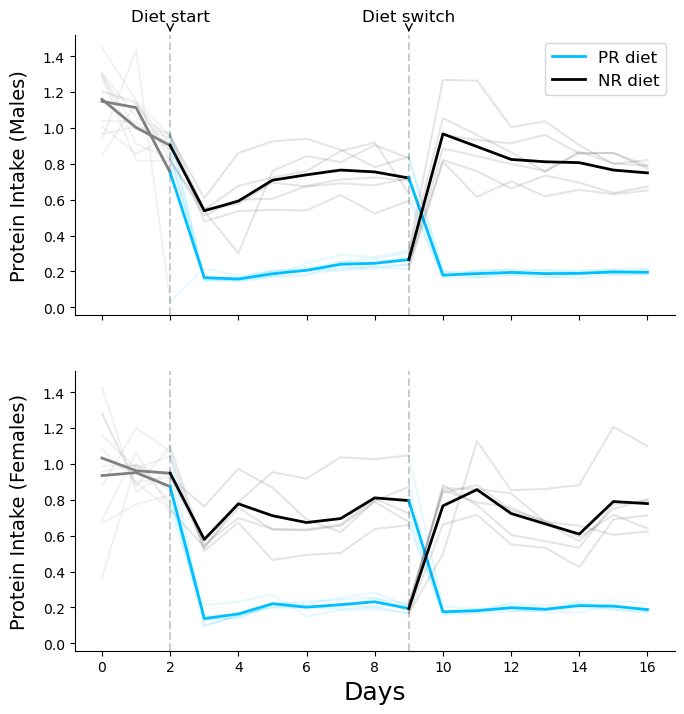

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Constants for protein content per pellet
GRAIN_PROTEIN_PER_PELLET = 0.00426  # grams of protein in Grain diet (21.3% protein)
NR_PROTEIN_PER_PELLET = 0.0036     # grams of protein in NR diet (20% Casein, 18% protein)
PR_PROTEIN_PER_PELLET = 0.001      # grams of protein in PR diet (5% Casein, 5% protein)

# Function to convert pellet counts to protein intake based on the order
def convert_pellets_to_protein(all_pellets_per_day, order):
    # First 3 days: Grain phase (specific protein content for Grain diet)
    grain_protein = [pellets * GRAIN_PROTEIN_PER_PELLET for pellets in all_pellets_per_day[:3]]

    if order == 1:  # Order 1 (NRPR: Grain → NR → PR)
        # Next 7 days: NR phase
        nr_protein = [pellets * NR_PROTEIN_PER_PELLET for pellets in all_pellets_per_day[3:10]]
        # Last 7 days: PR phase
        pr_protein = [pellets * PR_PROTEIN_PER_PELLET for pellets in all_pellets_per_day[10:]]

    elif order == 2:  # Order 2 (PRNR: Grain → PR → NR)
        # Next 7 days: PR phase
        pr_protein = [pellets * PR_PROTEIN_PER_PELLET for pellets in all_pellets_per_day[3:10]]
        # Last 7 days: NR phase
        nr_protein = [pellets * NR_PROTEIN_PER_PELLET for pellets in all_pellets_per_day[10:]]

    # Combine all phases together for plotting
    all_protein = grain_protein + nr_protein + pr_protein if order == 1 else grain_protein + pr_protein + nr_protein
    return all_protein

# Example of how to convert the pellet data to protein intake for all mice
for key in mice.keys():
    all_pellets_per_day = mice[key]["all_pellets_per_day"]
    order = mice[key]["order"]  # Get the order of the mouse
    protein_intake_per_day = convert_pellets_to_protein(all_pellets_per_day, order)
    mice[key]["protein_intake_per_day"] = protein_intake_per_day  # Save protein intake in dictionary

# Selectors for grouping mice data
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

# Get data for protein intake per day
nrpr_m_protein = get_data_fields(mice, ["protein_intake_per_day"], nrpr_male_selector)
prnr_m_protein = get_data_fields(mice, ["protein_intake_per_day"], prnr_male_selector)
nrpr_f_protein = get_data_fields(mice, ["protein_intake_per_day"], nrpr_female_selector)
prnr_f_protein = get_data_fields(mice, ["protein_intake_per_day"], prnr_female_selector)

# Plotting the protein intake per day trend using a similar layout to your previous pellet intake plot
f, ax = plt.subplots(nrows=2, sharex=True, figsize=(8, 8), gridspec_kw={"left": 0.15})

# Plot for males with annotations only on the upper plot
_, pr_line, nr_line = timeline_multicolor_fig([nrpr_m_protein, prnr_m_protein], colors=["black", "deepskyblue"], ylabel="Protein Intake (Males)", ax=ax[0])

# Add annotations at day 2 and day 9 only on the upper plot
ax[0].annotate('Diet start', xy=(2, ax[0].get_ylim()[1]), xytext=(2, ax[0].get_ylim()[1] + 0.05 * ax[0].get_ylim()[1]), 
               ha='center', fontsize=12, color='black', arrowprops=dict(arrowstyle='->', color='black', lw=1))
ax[0].annotate('Diet switch', xy=(9, ax[0].get_ylim()[1]), xytext=(9, ax[0].get_ylim()[1] + 0.05 * ax[0].get_ylim()[1]), 
               ha='center', fontsize=12, color='black', arrowprops=dict(arrowstyle='->', color='black', lw=1))

# Plot for females
timeline_multicolor_fig([nrpr_f_protein, prnr_f_protein], colors=["black", "deepskyblue"], ylabel="Protein Intake (Females)", ax=ax[1])

# Set common X-axis label
ax[1].set_xlabel("Days", fontsize=18)

# Set a common Y-axis limit for better comparison
ax[1].set_ylim(ax[0].get_ylim())

# Add legend for PR and NR diet (PR = deepskyblue, NR = black)
ax[0].legend([pr_line, nr_line], ["PR diet", "NR diet"], loc="upper right", fontsize=12)

# Show the plot
plt.show()

# Optionally save the figure
# figfolder = r"..//plots/PROTEIN_INTAKE_PLOTS//"
# f.savefig(figfolder + "protein_intake_timeline.pdf")


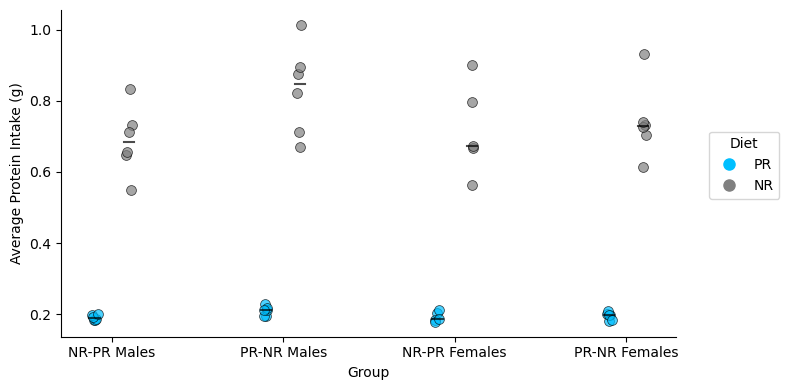

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract average protein intake for a given phase
def get_avg_protein_intake_by_group(mice, group_selector, phase):
    data = []
    for key in mice.keys():
        # Check if the mouse matches the group (male/female, order)
        if mice[key]["sex"] == group_selector["sex"] and mice[key]["order"] == group_selector["order"]:
            # Calculate the average protein intake based on the phase
            if phase == "Grain":
                protein_intake = np.mean(mice[key]["protein_intake_per_day"][:3])
            elif phase == "NR":
                if mice[key]["order"] == 1:  # NRPR
                    protein_intake = np.mean(mice[key]["protein_intake_per_day"][3:10])
                else:  # PRNR
                    protein_intake = np.mean(mice[key]["protein_intake_per_day"][10:17])
            elif phase == "PR":
                if mice[key]["order"] == 1:  # NRPR
                    protein_intake = np.mean(mice[key]["protein_intake_per_day"][10:17])
                else:  # PRNR
                    protein_intake = np.mean(mice[key]["protein_intake_per_day"][3:10])
            
            data.append(protein_intake)
    return data

# Selectors for each group
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

# Extract data for scatter plot for each group and phase
nrpr_males_pr = get_avg_protein_intake_by_group(mice, nrpr_male_selector, "PR")
nrpr_males_nr = get_avg_protein_intake_by_group(mice, nrpr_male_selector, "NR")
prnr_males_pr = get_avg_protein_intake_by_group(mice, prnr_male_selector, "PR")
prnr_males_nr = get_avg_protein_intake_by_group(mice, prnr_male_selector, "NR")
nrpr_females_pr = get_avg_protein_intake_by_group(mice, nrpr_female_selector, "PR")
nrpr_females_nr = get_avg_protein_intake_by_group(mice, nrpr_female_selector, "NR")
prnr_females_pr = get_avg_protein_intake_by_group(mice, prnr_female_selector, "PR")
prnr_females_nr = get_avg_protein_intake_by_group(mice, prnr_female_selector, "NR")

# Combine all data for easier plotting
data = [nrpr_males_pr, nrpr_males_nr, prnr_males_pr, prnr_males_nr,
        nrpr_females_pr, nrpr_females_nr, prnr_females_pr, prnr_females_nr]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Offset for separating PR and NR data points
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot for protein intake per phase
jitter_strength = 0.02  # Small jitter for spreading points
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Protein intake per phase

# Add median lines for each group and phase
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("Average Protein Intake (g)")

# Remove background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Save the figure if needed
# fig.savefig("protein_intake_per_phase_scatter_plot.pdf")


Text(0, 0.5, 'Average Protein Intake (g)')

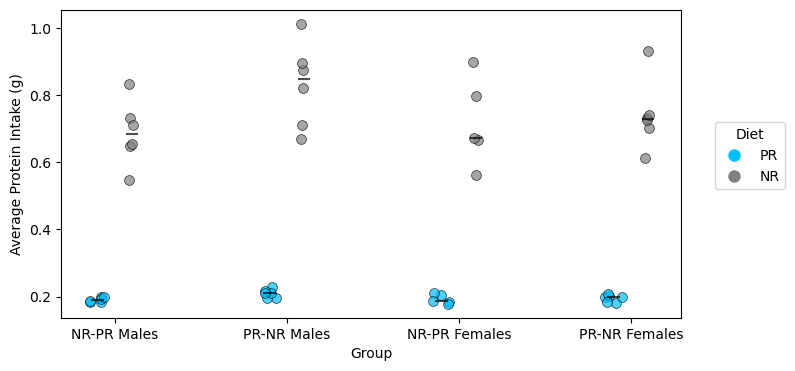

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract average protein intake for a given phase
def get_avg_protein_intake_by_group(mice, group_selector, phase):
    data = []
    for key in mice.keys():
        # Check if the mouse matches the group (male/female, order)
        if mice[key]["sex"] == group_selector["sex"] and mice[key]["order"] == group_selector["order"]:
            # Calculate the average protein intake based on the phase
            if phase == "Grain":
                protein_intake = np.mean(mice[key]["protein_intake_per_day"][:3])
            elif phase == "NR":
                if mice[key]["order"] == 1:  # NRPR
                    protein_intake = np.mean(mice[key]["protein_intake_per_day"][3:10])
                else:  # PRNR
                    protein_intake = np.mean(mice[key]["protein_intake_per_day"][10:17])
            elif phase == "PR":
                if mice[key]["order"] == 1:  # NRPR
                    protein_intake = np.mean(mice[key]["protein_intake_per_day"][10:17])
                else:  # PRNR
                    protein_intake = np.mean(mice[key]["protein_intake_per_day"][3:10])
            
            data.append(protein_intake)
    return data

# Selectors for each group
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

# Extract data for scatter plot for each group and phase
nrpr_males_pr = get_avg_protein_intake_by_group(mice, nrpr_male_selector, "PR")
nrpr_males_nr = get_avg_protein_intake_by_group(mice, nrpr_male_selector, "NR")
prnr_males_pr = get_avg_protein_intake_by_group(mice, prnr_male_selector, "PR")
prnr_males_nr = get_avg_protein_intake_by_group(mice, prnr_male_selector, "NR")
nrpr_females_pr = get_avg_protein_intake_by_group(mice, nrpr_female_selector, "PR")
nrpr_females_nr = get_avg_protein_intake_by_group(mice, nrpr_female_selector, "NR")
prnr_females_pr = get_avg_protein_intake_by_group(mice, prnr_female_selector, "PR")
prnr_females_nr = get_avg_protein_intake_by_group(mice, prnr_female_selector, "NR")

# Combine all data for easier plotting
data = [nrpr_males_pr, nrpr_males_nr, prnr_males_pr, prnr_males_nr,
        nrpr_females_pr, nrpr_females_nr, prnr_females_pr, prnr_females_nr]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Offset for separating PR and NR data points
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot for protein intake per phase with increased jitter for PR data
jitter_strength_pr = 0.05  # Increased jitter for PR data to spread them out
jitter_strength_nr = 0.02  # Standard jitter for NR data

for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    if diet == "PR":
        jitter = np.random.uniform(-jitter_strength_pr, jitter_strength_pr, size=len(data[i]))
    else:  # NR diet
        jitter = np.random.uniform(-jitter_strength_nr, jitter_strength_nr, size=len(data[i]))
    
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Protein intake per phase

# Add median lines for each group and phase
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("Average Protein Intake (g)")

# Remove background grid


In [14]:

# Function to save protein intake data to a CSV file
def save_protein_intake_to_csv(mice, filename="protein_intake_per_day.csv"):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write the header
        writer.writerow(["Mouse ID", "Sex", "Order", "Day", "Protein Intake (g)"])

        # Write the data for each mouse
        for key in mice.keys():
            protein_intake_per_day = mice[key].get("protein_intake_per_day", [])
            sex = mice[key].get("sex", "Unknown")
            order = mice[key].get("order", "Unknown")

            # Write data for each day (Day 1 to Day 17)
            for day in range(len(protein_intake_per_day)):
                writer.writerow([key, sex, order, day + 1, protein_intake_per_day[day]])

# Example: Call the function to save the protein intake data
save_protein_intake_to_csv(mice, filename="../results/protein_intake_per_mouse.csv")


In [17]:
import csv

# Function to calculate average protein intake for each phase and save to a CSV file
def save_avg_protein_intake_by_phase_to_csv(mice, filename="avg_protein_intake_per_phase.csv"):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write the header
        writer.writerow(["Mouse ID", "Sex", "Order", "Phase", "Average Protein Intake (g)"])

        # Write the data for each mouse
        for key in mice.keys():
            protein_intake_per_day = mice[key].get("protein_intake_per_day", [])
            sex = mice[key].get("sex", "Unknown")
            order = mice[key].get("order", "Unknown")

            # Grain phase (first 3 days)
            grain_protein_avg = np.mean(protein_intake_per_day[:3])
            writer.writerow([key, sex, order, "Grain", grain_protein_avg])

            # PR and NR phases depend on the order
            if order == 1:  # NRPR (Grain → NR → PR)
                # NR phase (next 7 days)
                nr_protein_avg = np.mean(protein_intake_per_day[3:10])
                writer.writerow([key, sex, order, "NR", nr_protein_avg])
                # PR phase (last 7 days)
                pr_protein_avg = np.mean(protein_intake_per_day[10:17])
                writer.writerow([key, sex, order, "PR", pr_protein_avg])

            elif order == 2:  # PRNR (Grain → PR → NR)
                # PR phase (next 7 days)
                pr_protein_avg = np.mean(protein_intake_per_day[3:10])
                writer.writerow([key, sex, order, "PR", pr_protein_avg])
                # NR phase (last 7 days)
                nr_protein_avg = np.mean(protein_intake_per_day[10:17])
                writer.writerow([key, sex, order, "NR", nr_protein_avg])

# Example: Call the function to save the average protein intake data by phase
save_avg_protein_intake_by_phase_to_csv(mice, filename="../results/avg_protein_intake_per_phase.csv")


In [3]:
####Saving total pellets per phase for statistical analysis

# Define a function to save pellet data for each mouse per phase in a CSV file
def save_pellet_data_to_csv(mice, output_filename="pellet_data.csv"):
    # Open the CSV file for writing
    with open(output_filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        
        # Write the header row
        writer.writerow(["Mouse ID", "Sex", "Order", 
                         "Grain Pellets", "PR Pellets", "NR Pellets"])
        
        # Iterate over each mouse in the dictionary
        for mouse_id, data in mice.items():
            # Retrieve the required information for each mouse
            sex = data.get("sex", "Unknown")
            order = data.get("order", "Unknown")
            grain_pellets = sum(data.get("grain_pellets_per_day", []))  # Total grain pellets
            pr_pellets = sum(data.get("pr_pellets_per_day", []))        # Total PR pellets
            nr_pellets = sum(data.get("nr_pellets_per_day", []))        # Total NR pellets
            
            # Write a row with the data for the current mouse
            writer.writerow([mouse_id, sex, order, grain_pellets, pr_pellets, nr_pellets])
    
    print(f"Pellet data has been successfully saved to {output_filename}.")

# Call the function to save the pellet data to CSV
save_pellet_data_to_csv(mice, output_filename="../results/total_pellet_per_phase.csv")

Pellet data has been successfully saved to ../results/total_pellet_per_phase.csv.


In [6]:
####Saving total number of meals/snacks/mega_meals per phase for statistical analysis
import csv

# Define a function to save the sum of meals, snacks, and mega meals per phase (NR and PR) for each mouse
def save_total_parameters_per_phase_to_csv(mice, output_filename="total_parameters_per_phase.csv"):
    # Open the CSV file for writing
    with open(output_filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        
        # Write the header row
        writer.writerow(["Mouse ID", "Sex", "Order", 
                         "Total NR Parameters", "Total PR Parameters"])
        
        # Iterate over each mouse in the dictionary
        for mouse_id, data in mice.items():
            # Retrieve the required information for each mouse
            sex = data.get("sex", "Unknown")
            order = data.get("order", "Unknown")
            
            # Sum up the values for NR phase (meals, snacks, mega meals)
            total_nr_meals = data.get("nr_number_of_meals", 0)
            total_nr_snacks = data.get("nr_number_of_snacks", 0)
            total_nr_mega_meals = data.get("nr_number_of_mega_meals", 0)
            total_nr_parameters = total_nr_meals + total_nr_snacks + total_nr_mega_meals
            
            # Sum up the values for PR phase (meals, snacks, mega meals)
            total_pr_meals = data.get("pr_number_of_meals", 0)
            total_pr_snacks = data.get("pr_number_of_snacks", 0)
            total_pr_mega_meals = data.get("pr_number_of_mega_meals", 0)
            total_pr_parameters = total_pr_meals + total_pr_snacks + total_pr_mega_meals
            
            # Write a row with the total data for NR and PR phases for the current mouse
            writer.writerow([mouse_id, sex, order, total_nr_parameters, total_pr_parameters])
    
    print(f"Total parameters per phase have been successfully saved to {output_filename}.")

# Call the function to save the total parameters per phase (NR and PR) to CSV
save_total_parameters_per_phase_to_csv(mice, output_filename="../results/total_parameters_per_phase.csv")


Total parameters per phase have been successfully saved to ../results/total_parameters_per_phase.csv.


: 

In [2]:
mice["FEDXB01"].keys()

nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 


nrpr_m_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_meals_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_meals_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_meals_per_day"], prnr_female_selector)

6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


In [109]:
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

In [110]:
nrpr_m_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_meals_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_meals_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_meals_per_day"], prnr_female_selector)


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


In [5]:
prnr_m_mega_meals

[[43, 25, 23, 35, 28, 31, 24, 24, 31, 14, 9, 18, 18, 15, 13, 9, 6],
 [41, 39, 22, 36, 39, 54, 47, 45, 37, 34, 13, 17, 32, 27, 23, 15, 12],
 [51, 32, 29, 38, 32, 43, 47, 50, 49, 46, 19, 14, 17, 14, 14, 19, 14],
 [56, 43, 26, 29, 33, 37, 44, 37, 37, 30, 14, 14, 13, 5, 10, 23, 7],
 [21, 8, 7, 35, 47, 52, 53, 47, 60, 60, 38, 27, 22, 30, 31, 33, 26],
 [44, 28, 2, 54, 49, 67, 50, 57, 45, 64, 36, 38, 33, 33, 25, 28, 33]]

6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


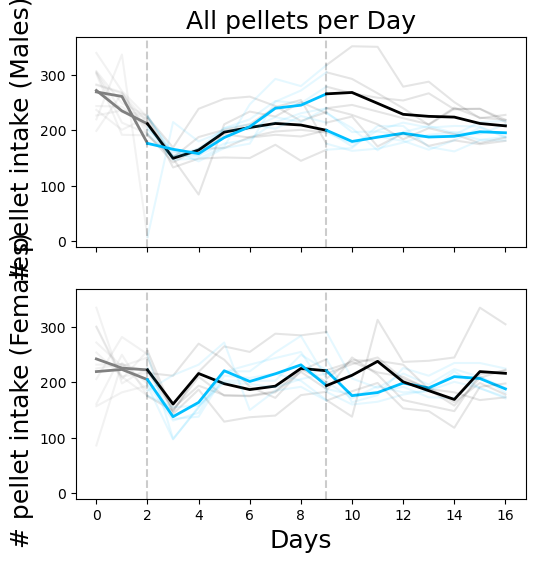

In [111]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot individual timelines
def timeline_fig(data, ax=[], ylabel="", **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided
    
    for trace in data:
        ax.plot(trace, color="grey", alpha=0.3)  # Plot individual traces with transparency
    ax.plot(np.mean(data, axis=0), linewidth=2)  # Plot the mean line

    ax.set_ylabel(ylabel)
    ax.axvline(2, linestyle="--", color="k")  # Add vertical reference lines
    ax.axvline(9, linestyle="--", color="k")

    return ax

# Function to plot multicolored timeline with split phases (PR/NR)
def timeline_multicolor_fig(data, ax=[], ylabel="", colors=[], day_split=[2, 9], max_days=17, **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided

    for group in data:
        for trace in group:
            trace = trace[:max_days]  # Ensure the trace is within the max_days range
            ax.plot(range(0, 3), trace[:3], color="grey", alpha=0.1)  # Plot the grey phase
            ax.plot(range(2, 10), trace[2:10], color=colors[0], alpha=0.1)  # First phase in color
            ax.plot(range(9, len(trace)), trace[9:], color=colors[1], alpha=0.1)  # Second phase in color

        # Plot the mean values
        mean = np.mean(group, axis=0)[:max_days]
        ax.plot(range(0, 3), mean[:3], color="grey", linewidth=2)  # Grey phase mean
        ax.plot(range(2, 10), mean[2:10], color=colors[0], linewidth=2)  # First phase mean
        ax.plot(range(9, len(mean)), mean[9:], color=colors[1], linewidth=2)  # Second phase mean

        colors.reverse()  # Alternate color for next group

    ax.set_ylabel(ylabel, fontsize=18)
    ax.axvline(2, linestyle="--", color="k", alpha=0.2)  # Add phase split lines
    ax.axvline(9, linestyle="--", color="k", alpha=0.2)

    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

    return ax

# Selectors for grouping mice data
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

# Get data for mega meals per day
nrpr_m_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], prnr_female_selector)

# Plot the mega meals per day trend using a similar layout to your pellet intake plot
f, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6), gridspec_kw={"left": 0.15})

# Plot for males
timeline_multicolor_fig([nrpr_m_mega_meals, prnr_m_mega_meals], colors=["black", "deepskyblue"], ylabel=" # pellet intake (Males)", ax=ax[0])

# Plot for females
timeline_multicolor_fig([nrpr_f_mega_meals, prnr_f_mega_meals], colors=["black", "deepskyblue"], ylabel=" # pellet intake (Females)", ax=ax[1])

# Set common X-axis label
ax[1].set_xlabel("Days", fontsize=18)

# Set a common Y-axis limit for better comparison
ax[1].set_ylim(ax[0].get_ylim())

# Add title for the overall figure
ax[0].set_title("All pellets per Day", fontsize=18)

# Show the plot
plt.show()

# Save the figure if needed
figfolder = r"..//plots/NEW_MEAL_PLOTS//"
# f.savefig(figfolder + "timeline_mega_meals_per_day.pdf")

6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


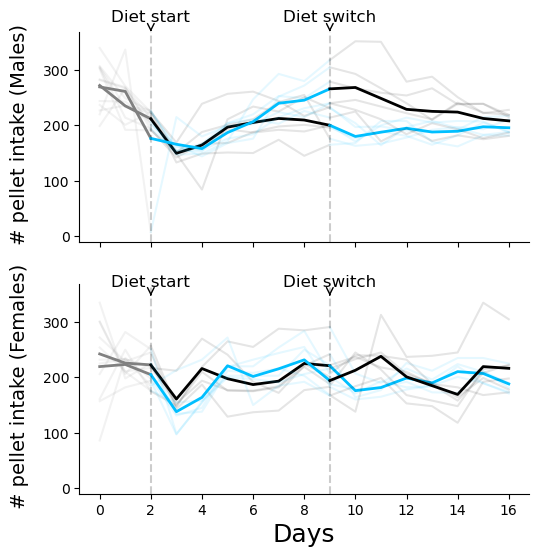

In [119]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot individual timelines
def timeline_fig(data, ax=[], ylabel="", **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided
    
    for trace in data:
        ax.plot(trace, color="grey", alpha=0.3)  # Plot individual traces with transparency
    ax.plot(np.mean(data, axis=0), linewidth=2)  # Plot the mean line

    ax.set_ylabel(ylabel)
    ax.axvline(2, linestyle="--", color="k")  # Add vertical reference lines
    ax.axvline(9, linestyle="--", color="k")

    return ax

# Function to plot multicolored timeline with split phases (PR/NR)
def timeline_multicolor_fig(data, ax=[], ylabel="", colors=[], day_split=[2, 9], max_days=17, **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided

    for group in data:
        for trace in group:
            trace = trace[:max_days]  # Ensure the trace is within the max_days range
            ax.plot(range(0, 3), trace[:3], color="grey", alpha=0.1)  # Plot the grey phase
            ax.plot(range(2, 10), trace[2:10], color=colors[0], alpha=0.1)  # First phase in color
            ax.plot(range(9, len(trace)), trace[9:], color=colors[1], alpha=0.1)  # Second phase in color

        # Plot the mean values
        mean = np.mean(group, axis=0)[:max_days]
        ax.plot(range(0, 3), mean[:3], color="grey", linewidth=2)  # Grey phase mean
        ax.plot(range(2, 10), mean[2:10], color=colors[0], linewidth=2)  # First phase mean
        ax.plot(range(9, len(mean)), mean[9:], color=colors[1], linewidth=2)  # Second phase mean

        colors.reverse()  # Alternate color for next group

    ax.set_ylabel(ylabel, fontsize=14, labelpad=10)  # Add label padding to avoid overlap
    ax.axvline(2, linestyle="--", color="k", alpha=0.2)  # Add phase split lines
    ax.axvline(9, linestyle="--", color="k", alpha=0.2)

    # Add annotations at day 2 and day 9
    ax.annotate('Diet start', xy=(2, ax.get_ylim()[1]), xytext=(2, ax.get_ylim()[1] + 0.05 * ax.get_ylim()[1]), 
                ha='center', fontsize=12, color='black', arrowprops=dict(arrowstyle='->', color='black', lw=1))
    ax.annotate('Diet switch', xy=(9, ax.get_ylim()[1]), xytext=(9, ax.get_ylim()[1] + 0.05 * ax.get_ylim()[1]), 
                ha='center', fontsize=12, color='black', arrowprops=dict(arrowstyle='->', color='black', lw=1))

    # Remove the upper and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    return ax

# Selectors for grouping mice data
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

# Get data for mega meals per day
nrpr_m_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], prnr_female_selector)

# Plot the mega meals per day trend using a similar layout to your pellet intake plot
f, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6), gridspec_kw={"left": 0.15})

# Plot for males
timeline_multicolor_fig([nrpr_m_mega_meals, prnr_m_mega_meals], colors=["black", "deepskyblue"], ylabel=" # pellet intake (Males)", ax=ax[0])

# Plot for females
timeline_multicolor_fig([nrpr_f_mega_meals, prnr_f_mega_meals], colors=["black", "deepskyblue"], ylabel=" # pellet intake (Females)", ax=ax[1])

# Set common X-axis label
ax[1].set_xlabel("Days", fontsize=18)

# Set a common Y-axis limit for better comparison
ax[1].set_ylim(ax[0].get_ylim())

# # Add title for the overall figure
# ax[0].set_title("All pellets per Day", fontsize=16, loc="right")

# Show the plot
plt.show()

# Save the figure if needed
figfolder = r"..//plots/NEW_MEAL_PLOTS//"
# f.savefig(figfolder + "timeline_mega_meals_per_day.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


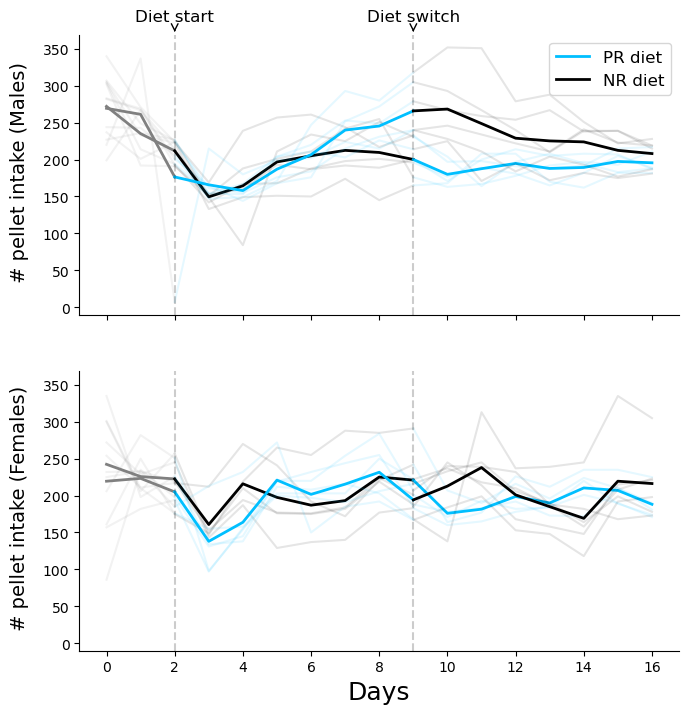

In [132]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot individual timelines
def timeline_fig(data, ax=[], ylabel="", **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided
    
    for trace in data:
        ax.plot(trace, color="grey", alpha=0.3)  # Plot individual traces with transparency
    ax.plot(np.mean(data, axis=0), linewidth=2)  # Plot the mean line

    ax.set_ylabel(ylabel)
    ax.axvline(2, linestyle="--", color="k")  # Add vertical reference lines
    ax.axvline(9, linestyle="--", color="k")

    return ax

# Function to plot multicolored timeline with split phases (PR/NR)
def timeline_multicolor_fig(data, ax=[], ylabel="", colors=[], day_split=[2, 9], max_days=17, **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided

    # Initialize lines for legend
    pr_line = None
    nr_line = None

    for group in data:
        for trace in group:
            trace = trace[:max_days]  # Ensure the trace is within the max_days range
            ax.plot(range(0, 3), trace[:3], color="grey", alpha=0.1)  # Plot the grey phase
            ax.plot(range(2, 10), trace[2:10], color=colors[0], alpha=0.1)  # First phase in color (PR diet)
            ax.plot(range(9, len(trace)), trace[9:], color=colors[1], alpha=0.1)  # Second phase in color (NR diet)

        # Plot the mean values and store lines for the legend
        mean = np.mean(group, axis=0)[:max_days]
        ax.plot(range(0, 3), mean[:3], color="grey", linewidth=2)  # Grey phase mean
        pr_line, = ax.plot(range(2, 10), mean[2:10], color=colors[0], linewidth=2, label="PR diet")  # First phase mean
        nr_line, = ax.plot(range(9, len(mean)), mean[9:], color=colors[1], linewidth=2, label="NR diet")  # Second phase mean

        colors.reverse()  # Alternate color for next group

    ax.set_ylabel(ylabel, fontsize=14, labelpad=10)  # Add label padding to avoid overlap
    ax.axvline(2, linestyle="--", color="k", alpha=0.2)  # Add phase split lines
    ax.axvline(9, linestyle="--", color="k", alpha=0.2)

    # Remove the upper and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    return ax, pr_line, nr_line

# Selectors for grouping mice data
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

# Get data for mega meals per day
nrpr_m_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], prnr_female_selector)

# Increase figure size and adjust font sizes to avoid overlap
f, ax = plt.subplots(nrows=2, sharex=True, figsize=(8, 8), gridspec_kw={"left": 0.15})

# Plot for males with annotations only on the upper plot
_, pr_line, nr_line = timeline_multicolor_fig([nrpr_m_mega_meals, prnr_m_mega_meals], colors=["black", "deepskyblue"], ylabel=" # pellet intake (Males)", ax=ax[0])

# Add annotations at day 2 and day 9 only on the upper plot
ax[0].annotate('Diet start', xy=(2, ax[0].get_ylim()[1]), xytext=(2, ax[0].get_ylim()[1] + 0.05 * ax[0].get_ylim()[1]), 
               ha='center', fontsize=12, color='black', arrowprops=dict(arrowstyle='->', color='black', lw=1))
ax[0].annotate('Diet switch', xy=(9, ax[0].get_ylim()[1]), xytext=(9, ax[0].get_ylim()[1] + 0.05 * ax[0].get_ylim()[1]), 
               ha='center', fontsize=12, color='black', arrowprops=dict(arrowstyle='->', color='black', lw=1))

# Plot for females
timeline_multicolor_fig([nrpr_f_mega_meals, prnr_f_mega_meals], colors=["black", "deepskyblue"], ylabel=" # pellet intake (Females)", ax=ax[1])

# Set common X-axis label
ax[1].set_xlabel("Days", fontsize=18)

# Set a common Y-axis limit for better comparison
ax[1].set_ylim(ax[0].get_ylim())

# Add legend for PR and NR diet (PR = deepskyblue, NR = black)
ax[0].legend([pr_line, nr_line], ["PR diet", "NR diet"], loc="upper right", fontsize=12)

# Show the plot
plt.show()

# Save the figure if needed
figfolder = r"..//plots/NEW_MEAL_PLOTS//"
# f.savefig(figfolder + "timeline_mega_meals_per_day.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


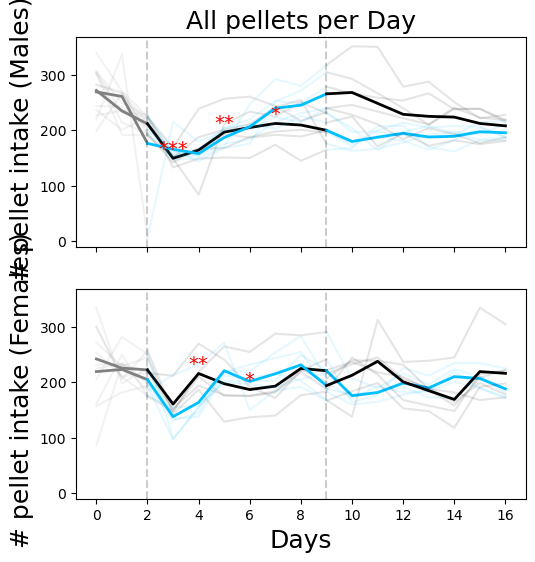

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Function to add asterisks for significance on the plot
def add_significance(ax, significant_days, y_values, offset=0.1, fontsize=14):
    for day, significance in significant_days.items():
        y = y_values[day] + offset  # Adjust the position above the plotted line
        ax.text(day, y, significance, ha='center', va='bottom', fontsize=fontsize, color='red')

# Function to plot individual timelines
def timeline_fig(data, ax=[], ylabel="", **kwargs):
    if ax == []:
        f, ax = plt.subplots()
    
    for trace in data:
        ax.plot(trace, color="grey", alpha=0.3)
    ax.plot(np.mean(data, axis=0), linewidth=2)

    ax.set_ylabel(ylabel)
    ax.axvline(2, linestyle="--", color="k")
    ax.axvline(9, linestyle="--", color="k")

    return ax

# Function to plot multicolored timeline with split phases and significance asterisks
def timeline_multicolor_fig(data, ax=[], ylabel="", colors=[], day_split=[2, 9], max_days=17, significant_days={}, **kwargs):
    if ax == []:
        f, ax = plt.subplots()

    for group in data:
        for trace in group:
            trace = trace[:max_days]
            ax.plot(range(0, 3), trace[:3], color="grey", alpha=0.1)
            ax.plot(range(2, 10), trace[2:10], color=colors[0], alpha=0.1)
            ax.plot(range(9, len(trace)), trace[9:], color=colors[1], alpha=0.1)

        # Plot the mean values
        mean = np.mean(group, axis=0)[:max_days]
        ax.plot(range(0, 3), mean[:3], color="grey", linewidth=2)
        ax.plot(range(2, 10), mean[2:10], color=colors[0], linewidth=2)
        ax.plot(range(9, len(mean)), mean[9:], color=colors[1], linewidth=2)

        colors.reverse()  # Alternate colors for the next group

    # Add significance asterisks
    if significant_days:
        add_significance(ax, significant_days, np.mean(data[0], axis=0))  # Adjust this to target the correct group

    ax.set_ylabel(ylabel, fontsize=18)
    ax.axvline(2, linestyle="--", color="k", alpha=0.2)
    ax.axvline(9, linestyle="--", color="k", alpha=0.2)

    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

    return ax

# Simulated significant days for plotting (replace this with real data from your ANOVA results)
significant_days_male = {3: '***', 5: '**', 7: '*'}  # Example: day 3 is highly significant, day 5 moderately, etc.
significant_days_female = {4: '**', 6: '*'}

# Example data selectors for grouping mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

# Get data for mega meals per day
nrpr_m_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], prnr_female_selector)

# Plot the mega meals per day trend
f, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6), gridspec_kw={"left": 0.15})

# Plot for males, adding significance markers
timeline_multicolor_fig([nrpr_m_mega_meals, prnr_m_mega_meals], colors=["black", "deepskyblue"], 
                        ylabel=" # pellet intake (Males)", ax=ax[0], significant_days=significant_days_male)

# Plot for females, adding significance markers
timeline_multicolor_fig([nrpr_f_mega_meals, prnr_f_mega_meals], colors=["black", "deepskyblue"], 
                        ylabel=" # pellet intake (Females)", ax=ax[1], significant_days=significant_days_female)

# Set common X-axis label
ax[1].set_xlabel("Days", fontsize=18)

# Set a common Y-axis limit for better comparison
ax[1].set_ylim(ax[0].get_ylim())

# Add title for the overall figure
ax[0].set_title("All pellets per Day", fontsize=18)

# Show the plot
plt.show()

# Save the figure if needed
figfolder = r"..//plots/NEW_MEAL_PLOTS//"
# f.savefig(figfolder + "timeline_mega_meals_per_day.pdf")


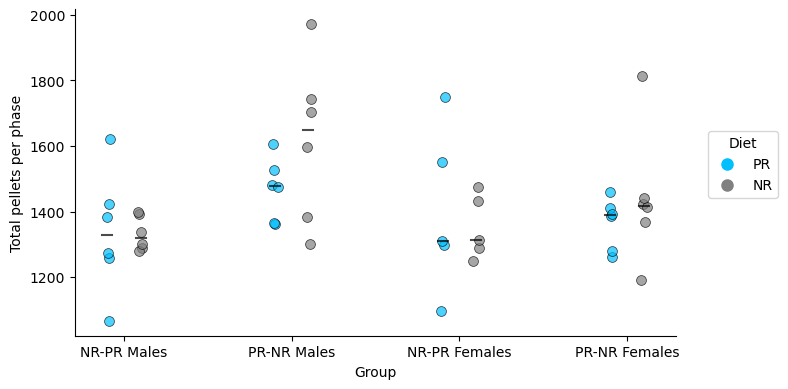

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = r'../results/FED_PROTEIN_FINAL_ULTIMATE_DATA_WITHOUT_IMI_IPI_LISTS.csv'
data = pd.read_csv(file_path)

# Function to convert string representations of lists into actual lists
def convert_to_list(string):
    return eval(string) if isinstance(string, str) else string

# Convert the relevant columns into lists
data['pr_pellets_per_day'] = data['pr_pellets_per_day'].apply(convert_to_list)
data['nr_pellets_per_day'] = data['nr_pellets_per_day'].apply(convert_to_list)

# Grouping data by sex and order
nrpr_male_data = data[(data['sex'] == 'M') & (data['order'] == 1)]
prnr_male_data = data[(data['sex'] == 'M') & (data['order'] == 2)]
nrpr_female_data = data[(data['sex'] == 'F') & (data['order'] == 1)]
prnr_female_data = data[(data['sex'] == 'F') & (data['order'] == 2)]

# Sum the pellets per day for PR and NR for each group
nrpr_male_pr_pellets = nrpr_male_data['pr_pellets_per_day'].apply(sum).values
nrpr_male_nr_pellets = nrpr_male_data['nr_pellets_per_day'].apply(sum).values
prnr_male_pr_pellets = prnr_male_data['pr_pellets_per_day'].apply(sum).values
prnr_male_nr_pellets = prnr_male_data['nr_pellets_per_day'].apply(sum).values
nrpr_female_pr_pellets = nrpr_female_data['pr_pellets_per_day'].apply(sum).values
nrpr_female_nr_pellets = nrpr_female_data['nr_pellets_per_day'].apply(sum).values
prnr_female_pr_pellets = prnr_female_data['pr_pellets_per_day'].apply(sum).values
prnr_female_nr_pellets = prnr_female_data['nr_pellets_per_day'].apply(sum).values

# Combine all data for easier plotting
data = [nrpr_male_pr_pellets, nrpr_male_nr_pellets, prnr_male_pr_pellets, prnr_male_nr_pellets,
        nrpr_female_pr_pellets, nrpr_female_nr_pellets, prnr_female_pr_pellets, prnr_female_nr_pellets]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Reduced offset for compactness
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis with smaller size for compactness
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot with reduced jitter and smaller markers
jitter_strength = 0.02  # Reduced jitter for more compact spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black", marker='o')

# Add median lines with slight adjustments for compactness
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend by manually adding it
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics with tighter spacing
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("Total pellets per phase")

# Remove the background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


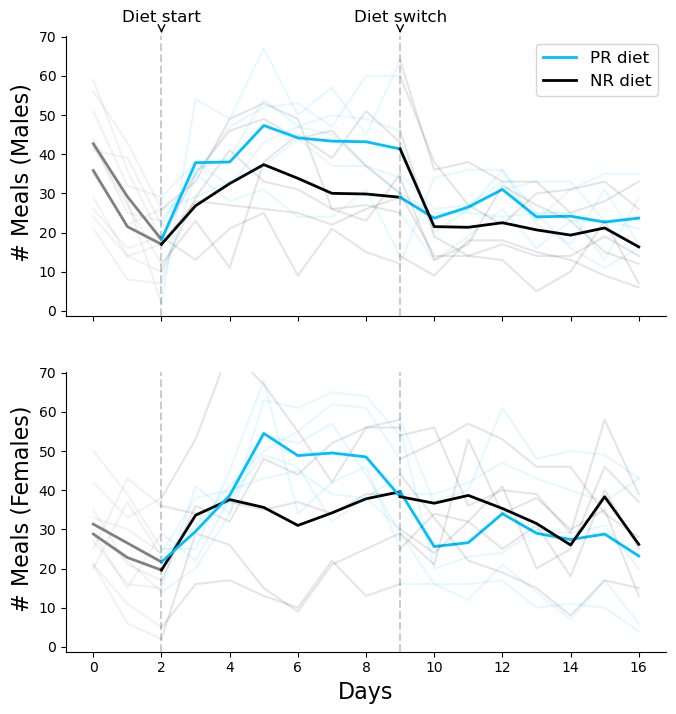

In [133]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot individual timelines
def timeline_fig(data, ax=[], ylabel="", **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided
    
    for trace in data:
        ax.plot(trace, color="grey", alpha=0.3)  # Plot individual traces with transparency
    ax.plot(np.mean(data, axis=0), linewidth=2)  # Plot the mean line

    ax.set_ylabel(ylabel)
    ax.axvline(2, linestyle="--", color="k")  # Add vertical reference lines
    ax.axvline(9, linestyle="--", color="k")

    return ax

# Function to plot multicolored timeline with split phases (PR/NR)
def timeline_multicolor_fig(data, ax=[], ylabel="", colors=[], day_split=[2, 9], max_days=17, **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided

    # Initialize lines for legend
    pr_line = None
    nr_line = None

    for group in data:
        for trace in group:
            trace = trace[:max_days]  # Ensure the trace is within the max_days range
            ax.plot(range(0, 3), trace[:3], color="grey", alpha=0.1)  # Plot the grey phase
            ax.plot(range(2, 10), trace[2:10], color=colors[0], alpha=0.1)  # First phase in color (PR diet)
            ax.plot(range(9, len(trace)), trace[9:], color=colors[1], alpha=0.1)  # Second phase in color (NR diet)

        # Plot the mean values and store lines for the legend
        mean = np.mean(group, axis=0)[:max_days]
        ax.plot(range(0, 3), mean[:3], color="grey", linewidth=2)  # Grey phase mean
        pr_line, = ax.plot(range(2, 10), mean[2:10], color=colors[0], linewidth=2, label="PR diet")  # First phase mean
        nr_line, = ax.plot(range(9, len(mean)), mean[9:], color=colors[1], linewidth=2, label="NR diet")  # Second phase mean

        colors.reverse()  # Alternate color for next group

    ax.set_ylabel(ylabel, fontsize=16)  # Reduced font size
    ax.axvline(2, linestyle="--", color="k", alpha=0.2)  # Add phase split lines
    ax.axvline(9, linestyle="--", color="k", alpha=0.2)

    # Add annotations at day 2 and day 9
    ax.annotate('Diet start', xy=(2, ax.get_ylim()[1]), xytext=(2, ax.get_ylim()[1] + 0.05 * ax.get_ylim()[1]), 
                ha='center', fontsize=12, color='black', arrowprops=dict(arrowstyle='->', color='black', lw=1))
    ax.annotate('Diet switch', xy=(9, ax.get_ylim()[1]), xytext=(9, ax.get_ylim()[1] + 0.05 * ax.get_ylim()[1]), 
                ha='center', fontsize=12, color='black', arrowprops=dict(arrowstyle='->', color='black', lw=1))

    # Remove the upper and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    return ax, pr_line, nr_line

# Selectors for grouping mice data
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

# Get data for mega meals per day
nrpr_m_mega_meals = get_data_fields(mice, ["all_meals_per_day"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_meals_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_meals_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_meals_per_day"], prnr_female_selector)

# Increase figure size and adjust font sizes to avoid overlap
f, ax = plt.subplots(nrows=2, sharex=True, figsize=(8, 8), gridspec_kw={"left": 0.15})

# Plot for males
_, pr_line, nr_line = timeline_multicolor_fig([nrpr_m_mega_meals, prnr_m_mega_meals], colors=["black", "deepskyblue"], ylabel=" # Meals (Males)", ax=ax[0])

# Plot for females
timeline_multicolor_fig([nrpr_f_mega_meals, prnr_f_mega_meals], colors=["black", "deepskyblue"], ylabel=" # Meals (Females)", ax=ax[1])

# Set common X-axis label
ax[1].set_xlabel("Days", fontsize=16)

# Set a common Y-axis limit for better comparison
ax[1].set_ylim(ax[0].get_ylim())

# Add legend for PR and NR diet
ax[0].legend([pr_line, nr_line], ["PR diet", "NR diet"], loc="upper right", fontsize=12)

# Show the plot
plt.show()

# Save the figure if needed
figfolder = r"..//plots/NEW_MEAL_PLOTS//"
# f.savefig(figfolder + "timeline_mega_meals_per_day.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


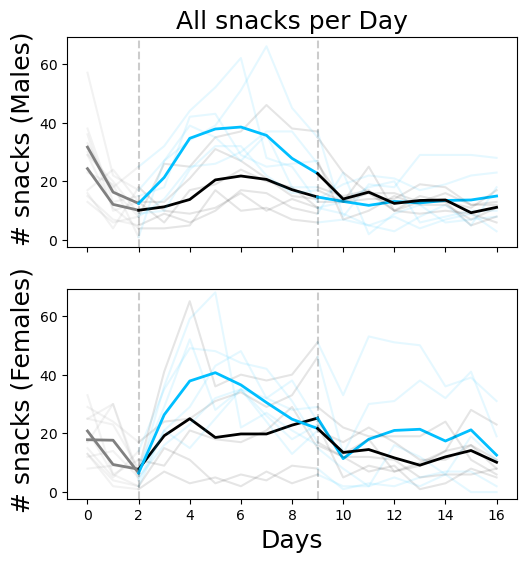

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot individual timelines
def timeline_fig(data, ax=[], ylabel="", **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided
    
    for trace in data:
        ax.plot(trace, color="grey", alpha=0.3)  # Plot individual traces with transparency
    ax.plot(np.mean(data, axis=0), linewidth=2)  # Plot the mean line

    ax.set_ylabel(ylabel)
    ax.axvline(2, linestyle="--", color="k")  # Add vertical reference lines
    ax.axvline(9, linestyle="--", color="k")

    return ax

# Function to plot multicolored timeline with split phases (PR/NR)
def timeline_multicolor_fig(data, ax=[], ylabel="", colors=[], day_split=[2, 9], max_days=17, **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided

    for group in data:
        for trace in group:
            trace = trace[:max_days]  # Ensure the trace is within the max_days range
            ax.plot(range(0, 3), trace[:3], color="grey", alpha=0.1)  # Plot the grey phase
            ax.plot(range(2, 10), trace[2:10], color=colors[0], alpha=0.1)  # First phase in color
            ax.plot(range(9, len(trace)), trace[9:], color=colors[1], alpha=0.1)  # Second phase in color

        # Plot the mean values
        mean = np.mean(group, axis=0)[:max_days]
        ax.plot(range(0, 3), mean[:3], color="grey", linewidth=2)  # Grey phase mean
        ax.plot(range(2, 10), mean[2:10], color=colors[0], linewidth=2)  # First phase mean
        ax.plot(range(9, len(mean)), mean[9:], color=colors[1], linewidth=2)  # Second phase mean

        colors.reverse()  # Alternate color for next group

    ax.set_ylabel(ylabel, fontsize=18)
    ax.axvline(2, linestyle="--", color="k", alpha=0.2)  # Add phase split lines
    ax.axvline(9, linestyle="--", color="k", alpha=0.2)

    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

    return ax

# Selectors for grouping mice data
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

# Get data for mega meals per day
nrpr_m_mega_meals = get_data_fields(mice, ["all_snacks_per_day"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_snacks_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_snacks_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_snacks_per_day"], prnr_female_selector)

# Plot the mega meals per day trend using a similar layout to your pellet intake plot
f, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6), gridspec_kw={"left": 0.15})

# Plot for males
timeline_multicolor_fig([nrpr_m_mega_meals, prnr_m_mega_meals], colors=["black", "deepskyblue"], ylabel=" # snacks (Males)", ax=ax[0])

# Plot for females
timeline_multicolor_fig([nrpr_f_mega_meals, prnr_f_mega_meals], colors=["black", "deepskyblue"], ylabel=" # snacks (Females)", ax=ax[1])

# Set common X-axis label
ax[1].set_xlabel("Days", fontsize=18)

# Set a common Y-axis limit for better comparison
ax[1].set_ylim(ax[0].get_ylim())

# Add title for the overall figure
ax[0].set_title("All snacks per Day", fontsize=18)

# Show the plot
plt.show()

# Save the figure if needed
figfolder = r"..//plots/NEW_MEAL_PLOTS//"
# f.savefig(figfolder + "timeline_mega_meals_per_day.pdf")

6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


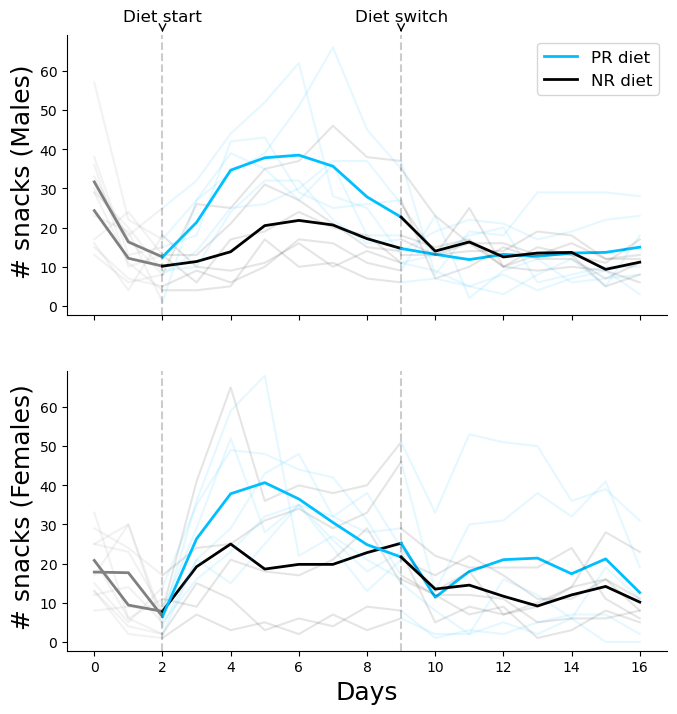

In [134]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot individual timelines
def timeline_fig(data, ax=[], ylabel="", **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided
    
    for trace in data:
        ax.plot(trace, color="grey", alpha=0.3)  # Plot individual traces with transparency
    ax.plot(np.mean(data, axis=0), linewidth=2)  # Plot the mean line

    ax.set_ylabel(ylabel)
    ax.axvline(2, linestyle="--", color="k")  # Add vertical reference lines
    ax.axvline(9, linestyle="--", color="k")

    return ax

# Function to plot multicolored timeline with split phases (PR/NR)
def timeline_multicolor_fig(data, ax=[], ylabel="", colors=[], day_split=[2, 9], max_days=17, **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided

    # Initialize lines for legend
    pr_line = None
    nr_line = None

    for group in data:
        for trace in group:
            trace = trace[:max_days]  # Ensure the trace is within the max_days range
            ax.plot(range(0, 3), trace[:3], color="grey", alpha=0.1)  # Plot the grey phase
            ax.plot(range(2, 10), trace[2:10], color=colors[1], alpha=0.1)  # First phase in color (PR diet)
            ax.plot(range(9, len(trace)), trace[9:], color=colors[0], alpha=0.1)  # Second phase in color (NR diet)

        # Plot the mean values and store lines for the legend
        mean = np.mean(group, axis=0)[:max_days]
        ax.plot(range(0, 3), mean[:3], color="grey", linewidth=2)  # Grey phase mean
        pr_line, = ax.plot(range(2, 10), mean[2:10], color=colors[1], linewidth=2, label="PR diet")  # First phase mean
        nr_line, = ax.plot(range(9, len(mean)), mean[9:], color=colors[0], linewidth=2, label="NR diet")  # Second phase mean

        colors.reverse()  # Alternate color for next group

    ax.set_ylabel(ylabel, fontsize=18)
    ax.axvline(2, linestyle="--", color="k", alpha=0.2)  # Add phase split lines
    ax.axvline(9, linestyle="--", color="k", alpha=0.2)

    # Remove the upper and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    return ax, pr_line, nr_line

# Selectors for grouping mice data
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

# Get data for mega meals per day
nrpr_m_mega_meals = get_data_fields(mice, ["all_snacks_per_day"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_snacks_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_snacks_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_snacks_per_day"], prnr_female_selector)

# Increase figure size and adjust font sizes to avoid overlap
f, ax = plt.subplots(nrows=2, sharex=True, figsize=(8, 8), gridspec_kw={"left": 0.15})

# Plot for males with annotations only on the upper plot
_, pr_line, nr_line = timeline_multicolor_fig([nrpr_m_mega_meals, prnr_m_mega_meals], colors=["deepskyblue", "black"], ylabel=" # snacks (Males)", ax=ax[0])

# Add annotations at day 2 and day 9 only on the upper plot
ax[0].annotate('Diet start', xy=(2, ax[0].get_ylim()[1]), xytext=(2, ax[0].get_ylim()[1] + 0.05 * ax[0].get_ylim()[1]), 
               ha='center', fontsize=12, color='black', arrowprops=dict(arrowstyle='->', color='black', lw=1))
ax[0].annotate('Diet switch', xy=(9, ax[0].get_ylim()[1]), xytext=(9, ax[0].get_ylim()[1] + 0.05 * ax[0].get_ylim()[1]), 
               ha='center', fontsize=12, color='black', arrowprops=dict(arrowstyle='->', color='black', lw=1))

# Plot for females
timeline_multicolor_fig([nrpr_f_mega_meals, prnr_f_mega_meals], colors=["deepskyblue", "black"], ylabel=" # snacks (Females)", ax=ax[1])

# Set common X-axis label
ax[1].set_xlabel("Days", fontsize=18)

# Set a common Y-axis limit for better comparison
ax[1].set_ylim(ax[0].get_ylim())

# Add legend for PR and NR diet (PR = deepskyblue, NR = black)
ax[0].legend([pr_line, nr_line], ["PR diet", "NR diet"], loc="upper right", fontsize=12)

# Show the plot
plt.show()

# Save the figure if needed
figfolder = r"..//plots/NEW_MEAL_PLOTS//"
# f.savefig(figfolder + "timeline_snacks_per_day.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


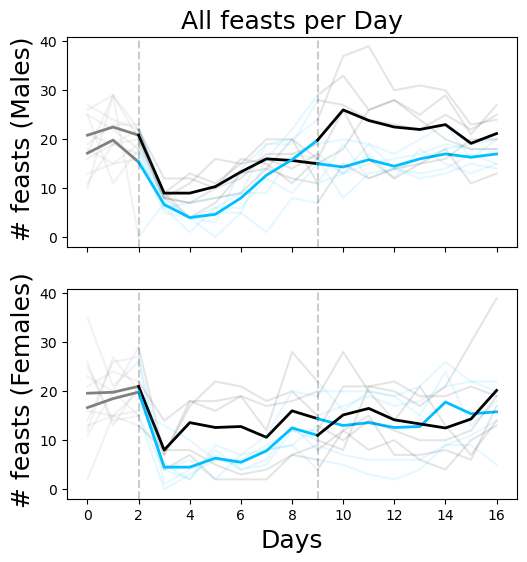

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot individual timelines
def timeline_fig(data, ax=[], ylabel="", **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided
    
    for trace in data:
        ax.plot(trace, color="grey", alpha=0.3)  # Plot individual traces with transparency
    ax.plot(np.mean(data, axis=0), linewidth=2)  # Plot the mean line

    ax.set_ylabel(ylabel)
    ax.axvline(2, linestyle="--", color="k")  # Add vertical reference lines
    ax.axvline(9, linestyle="--", color="k")

    return ax

# Function to plot multicolored timeline with split phases (PR/NR)
def timeline_multicolor_fig(data, ax=[], ylabel="", colors=[], day_split=[2, 9], max_days=17, **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided

    for group in data:
        for trace in group:
            trace = trace[:max_days]  # Ensure the trace is within the max_days range
            ax.plot(range(0, 3), trace[:3], color="grey", alpha=0.1)  # Plot the grey phase
            ax.plot(range(2, 10), trace[2:10], color=colors[0], alpha=0.1)  # First phase in color
            ax.plot(range(9, len(trace)), trace[9:], color=colors[1], alpha=0.1)  # Second phase in color

        # Plot the mean values
        mean = np.mean(group, axis=0)[:max_days]
        ax.plot(range(0, 3), mean[:3], color="grey", linewidth=2)  # Grey phase mean
        ax.plot(range(2, 10), mean[2:10], color=colors[0], linewidth=2)  # First phase mean
        ax.plot(range(9, len(mean)), mean[9:], color=colors[1], linewidth=2)  # Second phase mean

        colors.reverse()  # Alternate color for next group

    ax.set_ylabel(ylabel, fontsize=18)
    ax.axvline(2, linestyle="--", color="k", alpha=0.2)  # Add phase split lines
    ax.axvline(9, linestyle="--", color="k", alpha=0.2)

    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

    return ax

# Selectors for grouping mice data
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

# Get data for mega meals per day
nrpr_m_mega_meals = get_data_fields(mice, ["all_mega_meals_per_day"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_mega_meals_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_mega_meals_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_mega_meals_per_day"], prnr_female_selector)

# Plot the mega meals per day trend using a similar layout to your pellet intake plot
f, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6), gridspec_kw={"left": 0.15})

# Plot for males
timeline_multicolor_fig([nrpr_m_mega_meals, prnr_m_mega_meals], colors=["black", "deepskyblue"], ylabel=" # feasts (Males)", ax=ax[0])

# Plot for females
timeline_multicolor_fig([nrpr_f_mega_meals, prnr_f_mega_meals], colors=["black", "deepskyblue"], ylabel=" # feasts (Females)", ax=ax[1])

# Set common X-axis label
ax[1].set_xlabel("Days", fontsize=18)

# Set a common Y-axis limit for better comparison
ax[1].set_ylim(ax[0].get_ylim())

# Add title for the overall figure
ax[0].set_title("All feasts per Day", fontsize=18)

# Show the plot
plt.show()

# Save the figure if needed
figfolder = r"..//plots/NEW_MEAL_PLOTS//"
# f.savefig(figfolder + "timeline_mega_meals_per_day.pdf")

6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


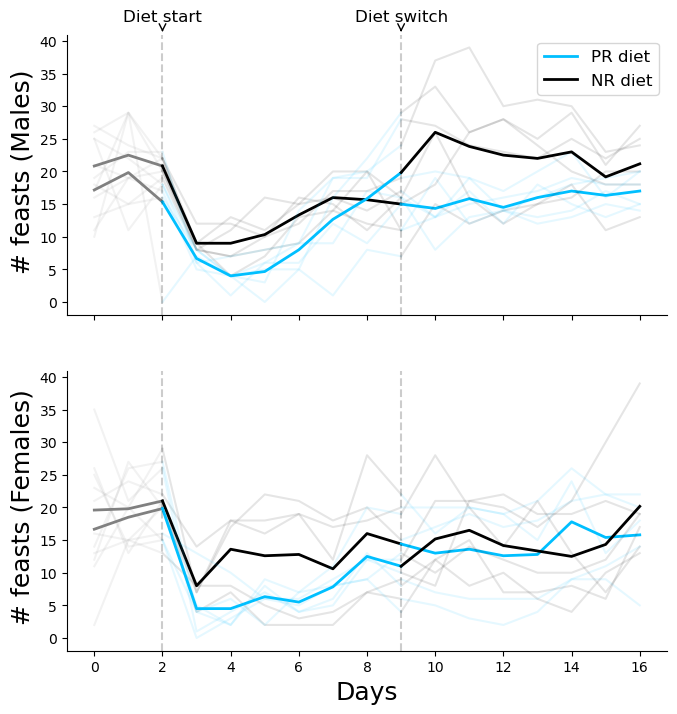

In [135]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot individual timelines
def timeline_fig(data, ax=[], ylabel="", **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided
    
    for trace in data:
        ax.plot(trace, color="grey", alpha=0.3)  # Plot individual traces with transparency
    ax.plot(np.mean(data, axis=0), linewidth=2)  # Plot the mean line

    ax.set_ylabel(ylabel)
    ax.axvline(2, linestyle="--", color="k")  # Add vertical reference lines
    ax.axvline(9, linestyle="--", color="k")

    return ax

# Function to plot multicolored timeline with split phases (PR/NR)
def timeline_multicolor_fig(data, ax=[], ylabel="", colors=[], day_split=[2, 9], max_days=17, **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided

    # Initialize lines for legend
    pr_line = None
    nr_line = None

    for group in data:
        for trace in group:
            trace = trace[:max_days]  # Ensure the trace is within the max_days range
            ax.plot(range(0, 3), trace[:3], color="grey", alpha=0.1)  # Plot the grey phase
            ax.plot(range(2, 10), trace[2:10], color=colors[1], alpha=0.1)  # First phase in color (PR diet)
            ax.plot(range(9, len(trace)), trace[9:], color=colors[0], alpha=0.1)  # Second phase in color (NR diet)

        # Plot the mean values and store lines for the legend
        mean = np.mean(group, axis=0)[:max_days]
        ax.plot(range(0, 3), mean[:3], color="grey", linewidth=2)  # Grey phase mean
        pr_line, = ax.plot(range(2, 10), mean[2:10], color=colors[1], linewidth=2, label="PR diet")  # First phase mean
        nr_line, = ax.plot(range(9, len(mean)), mean[9:], color=colors[0], linewidth=2, label="NR diet")  # Second phase mean

        colors.reverse()  # Alternate color for next group

    ax.set_ylabel(ylabel, fontsize=18)
    ax.axvline(2, linestyle="--", color="k", alpha=0.2)  # Add phase split lines
    ax.axvline(9, linestyle="--", color="k", alpha=0.2)

    # Remove the upper and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    return ax, pr_line, nr_line

# Selectors for grouping mice data
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

# Get data for mega meals per day
nrpr_m_mega_meals = get_data_fields(mice, ["all_mega_meals_per_day"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_mega_meals_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_mega_meals_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_mega_meals_per_day"], prnr_female_selector)

# Increase figure size and adjust font sizes to avoid overlap
f, ax = plt.subplots(nrows=2, sharex=True, figsize=(8, 8), gridspec_kw={"left": 0.15})

# Plot for males with annotations only on the upper plot
_, pr_line, nr_line = timeline_multicolor_fig([nrpr_m_mega_meals, prnr_m_mega_meals], colors=["deepskyblue", "black"], ylabel=" # feasts (Males)", ax=ax[0])

# Add annotations at day 2 and day 9 only on the upper plot
ax[0].annotate('Diet start', xy=(2, ax[0].get_ylim()[1]), xytext=(2, ax[0].get_ylim()[1] + 0.05 * ax[0].get_ylim()[1]), 
               ha='center', fontsize=12, color='black', arrowprops=dict(arrowstyle='->', color='black', lw=1))
ax[0].annotate('Diet switch', xy=(9, ax[0].get_ylim()[1]), xytext=(9, ax[0].get_ylim()[1] + 0.05 * ax[0].get_ylim()[1]), 
               ha='center', fontsize=12, color='black', arrowprops=dict(arrowstyle='->', color='black', lw=1))

# Plot for females
timeline_multicolor_fig([nrpr_f_mega_meals, prnr_f_mega_meals], colors=["deepskyblue", "black"], ylabel=" # feasts (Females)", ax=ax[1])

# Set common X-axis label
ax[1].set_xlabel("Days", fontsize=18)

# Set a common Y-axis limit for better comparison
ax[1].set_ylim(ax[0].get_ylim())

# Add legend for PR and NR diet (PR = deepskyblue, NR = black)
ax[0].legend([pr_line, nr_line], ["PR diet", "NR diet"], loc="upper right", fontsize=12)

# Show the plot
plt.show()

# Save the figure if needed
figfolder = r"..//plots/NEW_MEAL_PLOTS//"
# f.savefig(figfolder + "timeline_mega_meals_per_day.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


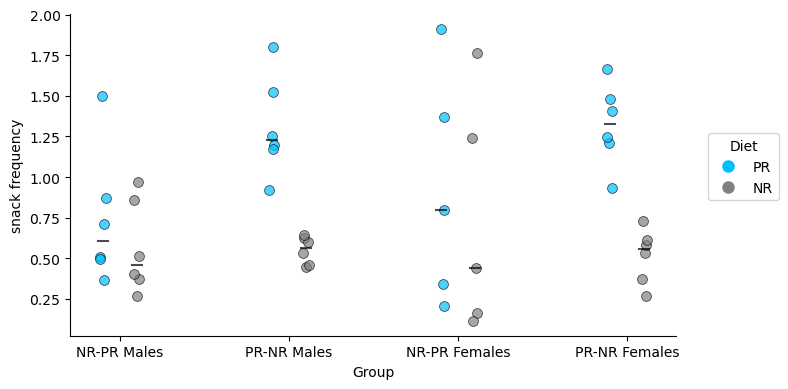

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data extraction using your actual function
nrpr_avg = get_data_fields(mice, ["pr_snack_frequency","nr_snack_frequency"], nrpr_male_selector)
prnr_avg = get_data_fields(mice, ["pr_snack_frequency", "nr_snack_frequency"], prnr_male_selector)
nrprf_avg = get_data_fields(mice, ["pr_snack_frequency","nr_snack_frequency"], nrpr_female_selector)
prnrf_avg = get_data_fields(mice, ["pr_snack_frequency","nr_snack_frequency"], prnr_female_selector)

# Combine all data for easier plotting
data = [nrpr_avg[0], nrpr_avg[1], prnr_avg[0], prnr_avg[1],
        nrprf_avg[0], nrprf_avg[1], prnrf_avg[0], prnrf_avg[1]]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Reduced offset for compactness
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis with smaller size for compactness
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot with reduced jitter and smaller markers
jitter_strength = 0.02  # Reduced jitter for more compact spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Smaller markers

# Add median lines with slight adjustments for compactness
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend by manually adding it
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics with tighter spacing
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("snack frequency")

# Remove the background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Save the figure if needed
# fig.savefig("pellets_scatter_plot_compact.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


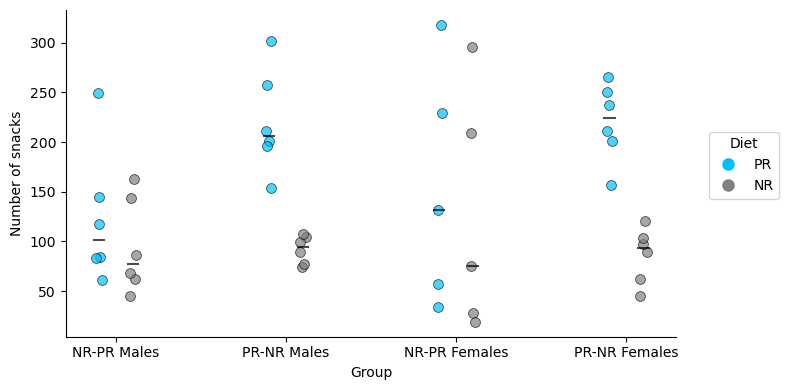

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data extraction using your actual function
nrpr_avg = get_data_fields(mice, ["pr_number_of_snacks","nr_number_of_snacks"], nrpr_male_selector)
prnr_avg = get_data_fields(mice, ["pr_number_of_snacks", "nr_number_of_snacks"], prnr_male_selector)
nrprf_avg = get_data_fields(mice, ["pr_number_of_snacks","nr_number_of_snacks"], nrpr_female_selector)
prnrf_avg = get_data_fields(mice, ["pr_number_of_snacks","nr_number_of_snacks"], prnr_female_selector)

# Combine all data for easier plotting
data = [nrpr_avg[0], nrpr_avg[1], prnr_avg[0], prnr_avg[1],
        nrprf_avg[0], nrprf_avg[1], prnrf_avg[0], prnrf_avg[1]]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Reduced offset for compactness
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis with smaller size for compactness
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot with reduced jitter and smaller markers
jitter_strength = 0.02  # Reduced jitter for more compact spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Smaller markers

# Add median lines with slight adjustments for compactness
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend by manually adding it
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics with tighter spacing
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("Number of snacks")

# Remove the background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Save the figure if needed
# fig.savefig("pellets_scatter_plot_compact.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


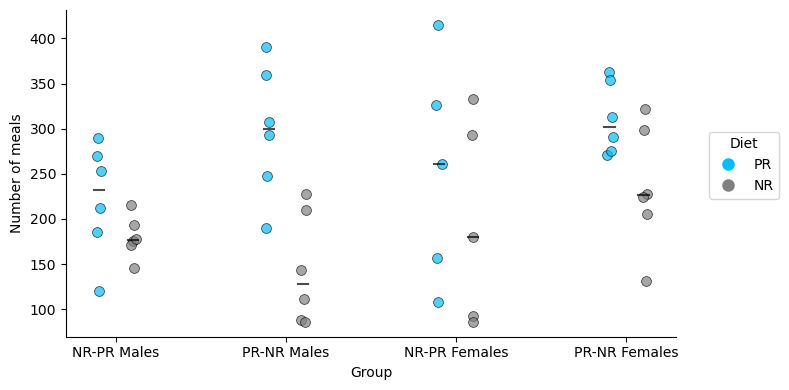

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data extraction using your actual function
nrpr_avg = get_data_fields(mice, ["pr_number_of_meals","nr_number_of_meals"], nrpr_male_selector)
prnr_avg = get_data_fields(mice, ["pr_number_of_meals", "nr_number_of_meals"], prnr_male_selector)
nrprf_avg = get_data_fields(mice, ["pr_number_of_meals","nr_number_of_meals"], nrpr_female_selector)
prnrf_avg = get_data_fields(mice, ["pr_number_of_meals","nr_number_of_meals"], prnr_female_selector)

# Combine all data for easier plotting
data = [nrpr_avg[0], nrpr_avg[1], prnr_avg[0], prnr_avg[1],
        nrprf_avg[0], nrprf_avg[1], prnrf_avg[0], prnrf_avg[1]]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Reduced offset for compactness
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis with smaller size for compactness
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot with reduced jitter and smaller markers
jitter_strength = 0.02  # Reduced jitter for more compact spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Smaller markers

# Add median lines with slight adjustments for compactness
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend by manually adding it
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics with tighter spacing
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("Number of meals")

# Remove the background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Save the figure if needed
# fig.savefig("pellets_scatter_plot_compact.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


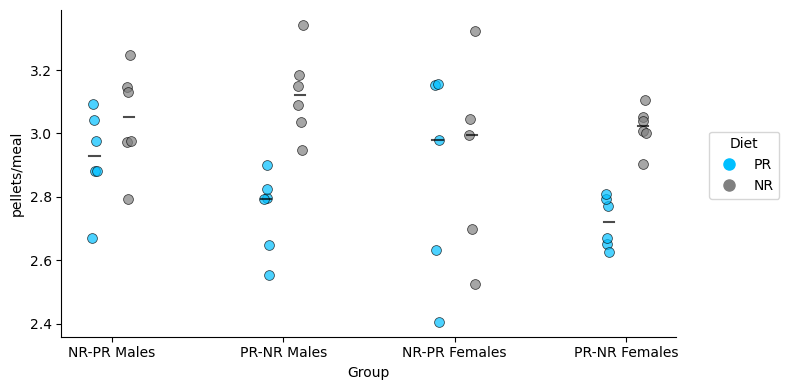

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data extraction using your actual function
nrpr_avg = get_data_fields(mice, ["pr_meal_size","nr_meal_size"], nrpr_male_selector)
prnr_avg = get_data_fields(mice, ["pr_meal_size", "nr_meal_size"], prnr_male_selector)
nrprf_avg = get_data_fields(mice, ["pr_meal_size","nr_meal_size"], nrpr_female_selector)
prnrf_avg = get_data_fields(mice, ["pr_meal_size","nr_meal_size"], prnr_female_selector)

# Combine all data for easier plotting
data = [nrpr_avg[0], nrpr_avg[1], prnr_avg[0], prnr_avg[1],
        nrprf_avg[0], nrprf_avg[1], prnrf_avg[0], prnrf_avg[1]]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Reduced offset for compactness
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis with smaller size for compactness
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot with reduced jitter and smaller markers
jitter_strength = 0.02  # Reduced jitter for more compact spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Smaller markers

# Add median lines with slight adjustments for compactness
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend by manually adding it
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics with tighter spacing
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("pellets/meal")

# Remove the background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Save the figure if needed
# fig.savefig("pellets_scatter_plot_compact.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


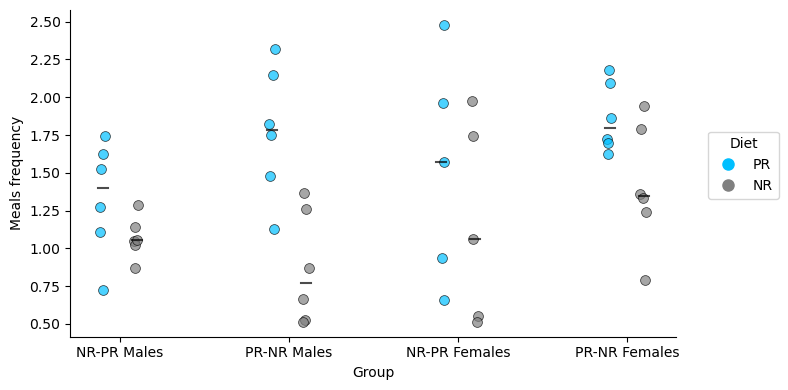

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data extraction using your actual function
nrpr_avg = get_data_fields(mice, ["pr_meal_frequency","nr_meal_frequency"], nrpr_male_selector)
prnr_avg = get_data_fields(mice, ["pr_meal_frequency", "nr_meal_frequency"], prnr_male_selector)
nrprf_avg = get_data_fields(mice, ["pr_meal_frequency","nr_meal_frequency"], nrpr_female_selector)
prnrf_avg = get_data_fields(mice, ["pr_meal_frequency","nr_meal_frequency"], prnr_female_selector)

# Combine all data for easier plotting
data = [nrpr_avg[0], nrpr_avg[1], prnr_avg[0], prnr_avg[1],
        nrprf_avg[0], nrprf_avg[1], prnrf_avg[0], prnrf_avg[1]]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Reduced offset for compactness
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis with smaller size for compactness
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot with reduced jitter and smaller markers
jitter_strength = 0.02  # Reduced jitter for more compact spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Smaller markers

# Add median lines with slight adjustments for compactness
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend by manually adding it
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics with tighter spacing
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("Meals frequency")

# Remove the background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Save the figure if needed
# fig.savefig("pellets_scatter_plot_compact.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


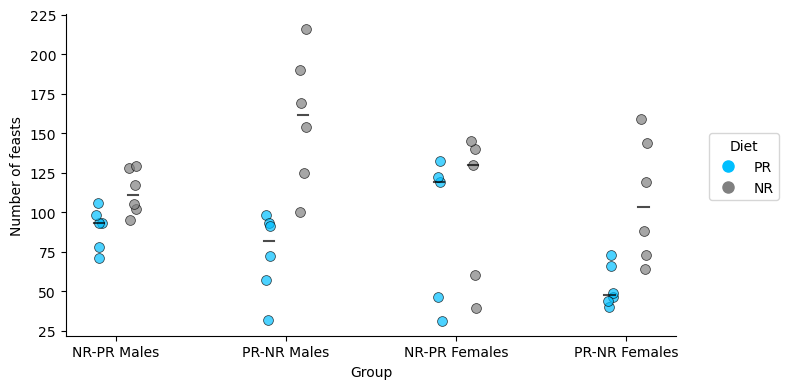

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data extraction using your actual function
nrpr_avg = get_data_fields(mice, ["pr_number_of_mega_meals","nr_number_of_mega_meals"], nrpr_male_selector)
prnr_avg = get_data_fields(mice, ["pr_number_of_mega_meals", "nr_number_of_mega_meals"], prnr_male_selector)
nrprf_avg = get_data_fields(mice, ["pr_number_of_mega_meals","nr_number_of_mega_meals"], nrpr_female_selector)
prnrf_avg = get_data_fields(mice, ["pr_number_of_mega_meals","nr_number_of_mega_meals"], prnr_female_selector)

# Combine all data for easier plotting
data = [nrpr_avg[0], nrpr_avg[1], prnr_avg[0], prnr_avg[1],
        nrprf_avg[0], nrprf_avg[1], prnrf_avg[0], prnrf_avg[1]]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Reduced offset for compactness
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis with smaller size for compactness
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot with reduced jitter and smaller markers
jitter_strength = 0.02  # Reduced jitter for more compact spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Smaller markers

# Add median lines with slight adjustments for compactness
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend by manually adding it
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics with tighter spacing
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("Number of feasts")

# Remove the background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Save the figure if needed
# fig.savefig("pellets_scatter_plot_compact.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


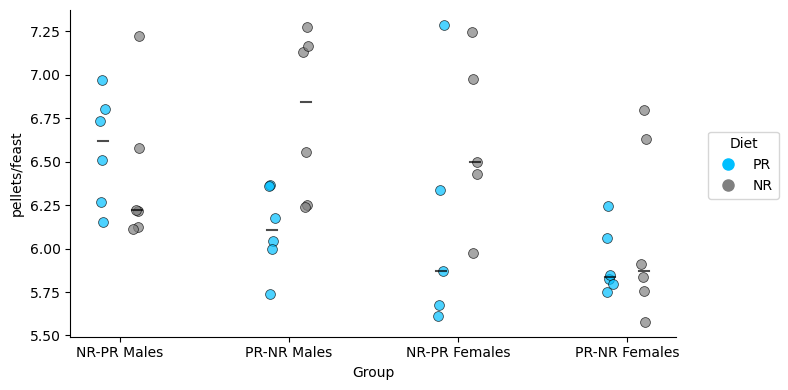

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data extraction using your actual function
nrpr_avg = get_data_fields(mice, ["pr_mega_meal_size","nr_mega_meal_size"], nrpr_male_selector)
prnr_avg = get_data_fields(mice, ["pr_mega_meal_size", "nr_mega_meal_size"], prnr_male_selector)
nrprf_avg = get_data_fields(mice, ["pr_mega_meal_size","nr_mega_meal_size"], nrpr_female_selector)
prnrf_avg = get_data_fields(mice, ["pr_mega_meal_size","nr_mega_meal_size"], prnr_female_selector)

# Combine all data for easier plotting
data = [nrpr_avg[0], nrpr_avg[1], prnr_avg[0], prnr_avg[1],
        nrprf_avg[0], nrprf_avg[1], prnrf_avg[0], prnrf_avg[1]]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Reduced offset for compactness
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis with smaller size for compactness
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot with reduced jitter and smaller markers
jitter_strength = 0.02  # Reduced jitter for more compact spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Smaller markers

# Add median lines with slight adjustments for compactness
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend by manually adding it
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics with tighter spacing
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("pellets/feast")

# Remove the background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Save the figure if needed
# fig.savefig("pellets_scatter_plot_compact.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


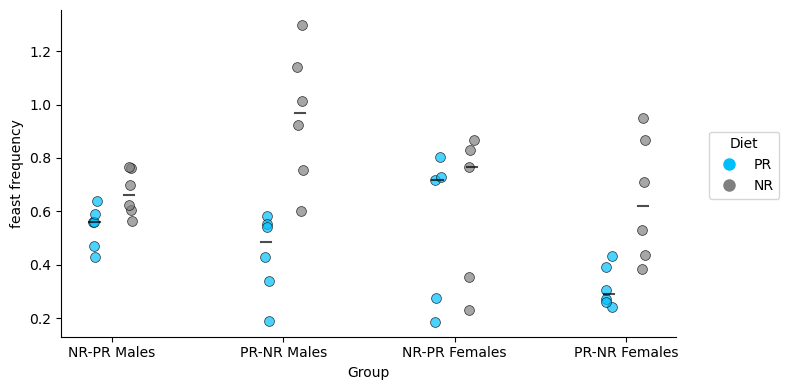

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data extraction using your actual function
nrpr_avg = get_data_fields(mice, ["pr_mega_meal_frequency","nr_mega_meal_frequency"], nrpr_male_selector)
prnr_avg = get_data_fields(mice, ["pr_mega_meal_frequency", "nr_mega_meal_frequency"], prnr_male_selector)
nrprf_avg = get_data_fields(mice, ["pr_mega_meal_frequency","nr_mega_meal_frequency"], nrpr_female_selector)
prnrf_avg = get_data_fields(mice, ["pr_mega_meal_frequency","nr_mega_meal_frequency"], prnr_female_selector)

# Combine all data for easier plotting
data = [nrpr_avg[0], nrpr_avg[1], prnr_avg[0], prnr_avg[1],
        nrprf_avg[0], nrprf_avg[1], prnrf_avg[0], prnrf_avg[1]]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Reduced offset for compactness
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis with smaller size for compactness
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot with reduced jitter and smaller markers
jitter_strength = 0.02  # Reduced jitter for more compact spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Smaller markers

# Add median lines with slight adjustments for compactness
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend by manually adding it
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics with tighter spacing
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("feast frequency")

# Remove the background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Save the figure if needed
# fig.savefig("pellets_scatter_plot_compact.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


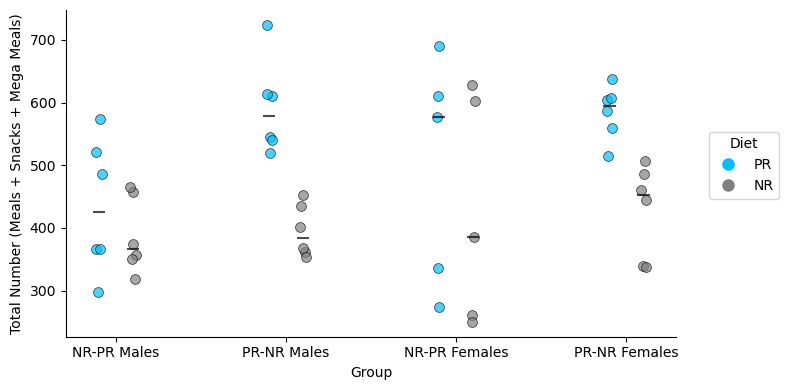

In [19]:
# Data extraction including meals, snacks, and mega_meals
nrpr_meals = get_data_fields(mice, ["pr_number_of_meals", "nr_number_of_meals"], nrpr_male_selector)
prnr_meals = get_data_fields(mice, ["pr_number_of_meals", "nr_number_of_meals"], prnr_male_selector)
nrprf_meals = get_data_fields(mice, ["pr_number_of_meals", "nr_number_of_meals"], nrpr_female_selector)
prnrf_meals = get_data_fields(mice, ["pr_number_of_meals", "nr_number_of_meals"], prnr_female_selector)

nrpr_snacks = get_data_fields(mice, ["pr_number_of_snacks", "nr_number_of_snacks"], nrpr_male_selector)
prnr_snacks = get_data_fields(mice, ["pr_number_of_snacks", "nr_number_of_snacks"], prnr_male_selector)
nrprf_snacks = get_data_fields(mice, ["pr_number_of_snacks", "nr_number_of_snacks"], nrpr_female_selector)
prnrf_snacks = get_data_fields(mice, ["pr_number_of_snacks", "nr_number_of_snacks"], prnr_female_selector)

nrpr_mega = get_data_fields(mice, ["pr_number_of_mega_meals", "nr_number_of_mega_meals"], nrpr_male_selector)
prnr_mega = get_data_fields(mice, ["pr_number_of_mega_meals", "nr_number_of_mega_meals"], prnr_male_selector)
nrprf_mega = get_data_fields(mice, ["pr_number_of_mega_meals", "nr_number_of_mega_meals"], nrpr_female_selector)
prnrf_mega = get_data_fields(mice, ["pr_number_of_mega_meals", "nr_number_of_mega_meals"], prnr_female_selector)

# Sum meals, snacks, and mega_meals
nrpr_sum = [np.add(nrpr_meals[0], np.add(nrpr_snacks[0], nrpr_mega[0])), 
            np.add(nrpr_meals[1], np.add(nrpr_snacks[1], nrpr_mega[1]))]
prnr_sum = [np.add(prnr_meals[0], np.add(prnr_snacks[0], prnr_mega[0])),
            np.add(prnr_meals[1], np.add(prnr_snacks[1], prnr_mega[1]))]
nrprf_sum = [np.add(nrprf_meals[0], np.add(nrprf_snacks[0], nrprf_mega[0])),
             np.add(nrprf_meals[1], np.add(nrprf_snacks[1], nrprf_mega[1]))]
prnrf_sum = [np.add(prnrf_meals[0], np.add(prnrf_snacks[0], prnrf_mega[0])),
             np.add(prnrf_meals[1], np.add(prnrf_snacks[1], prnrf_mega[1]))]


# Combine all summed data for easier plotting
data = [nrpr_sum[0], nrpr_sum[1], prnr_sum[0], prnr_sum[1],
        nrprf_sum[0], nrprf_sum[1], prnrf_sum[0], prnrf_sum[1]]


# Create a figure and axis with smaller size for compactness
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot with reduced jitter and smaller markers for summed values
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Smaller markers

# Add median lines with slight adjustments for compactness
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics with tighter spacing
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("Total Number (Meals + Snacks + Mega Meals)")

# Remove the background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()


C:\Users\hta031\AppData\Local\Temp\ipykernel_36180\2768516654.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_2_pr_meals['pr_mega_meals_per_day'] = order_2_pr_meals['pr_mega_meals_per_day'].apply(eval)


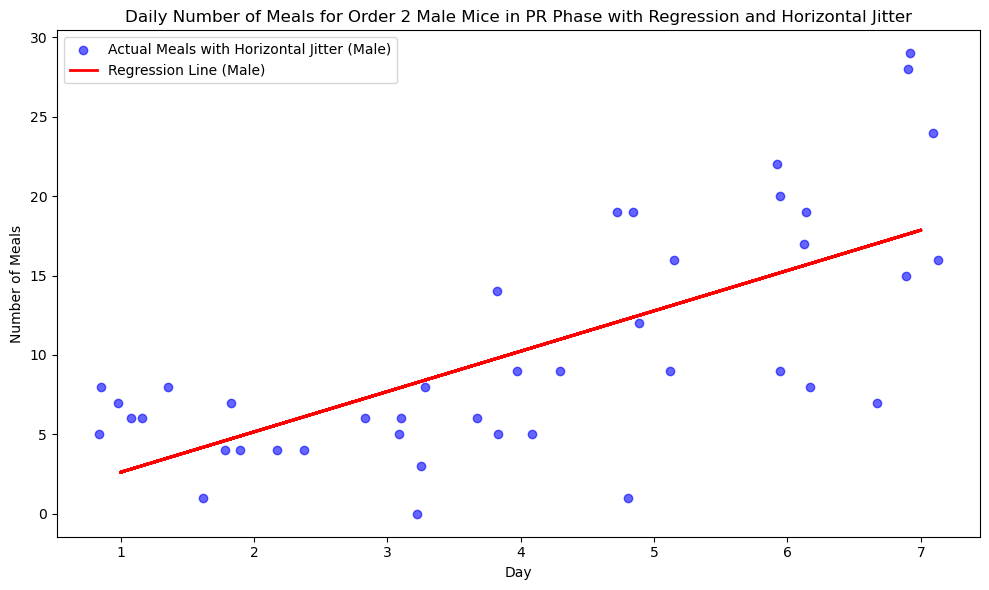

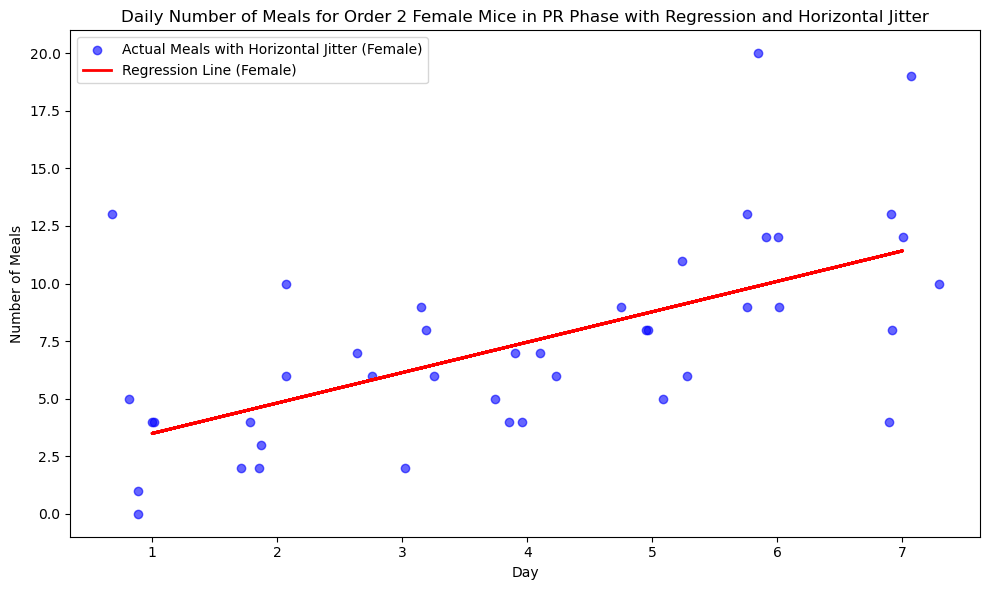

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load your dataset
file_path = "../results/FED_PROTEIN_FINAL_ULTIMATE_DATA_WITHOUT_IMI_IPI_LISTS.csv"
data = pd.read_csv(file_path)

# Filter the data for Order 2 mice in the PR phase
order_2_pr_meals = data[(data['order'] == 2) & (data['pr_mega_meals_per_day'].notna())]

# Convert string lists to actual lists
order_2_pr_meals['pr_mega_meals_per_day'] = order_2_pr_meals['pr_mega_meals_per_day'].apply(eval)

def plot_regression_by_sex_with_horizontal_jitter(data, sex_label):
    # Prepare the data for regression
    daily_meals = []
    days = []
    mouse_ids = []

    for idx, row in data.iterrows():
        daily_meals.extend(row['pr_mega_meals_per_day'])
        days.extend(range(1, len(row['pr_mega_meals_per_day']) + 1))
        mouse_ids.extend([row['mouse_id']] * len(row['pr_mega_meals_per_day']))

    regression_data = pd.DataFrame({
        'days': days,
        'daily_meals': daily_meals,
        'mouse_id': mouse_ids
    })

    # Add jitter to the x-axis (days) for horizontal spread
    jitter = np.random.normal(0, 0.2, size=len(regression_data['days']))  # Small horizontal jitter
    regression_data['days_jittered'] = regression_data['days'] + jitter

    # Perform linear regression
    X = np.array(regression_data['days']).reshape(-1, 1)
    y = regression_data['daily_meals']
    model = LinearRegression().fit(X, y)
    regression_data['predicted_meals'] = model.predict(X)

    # Plot the data points with jitter and a regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(regression_data['days_jittered'], regression_data['daily_meals'], color='blue', label=f'Actual Meals with Horizontal Jitter ({sex_label})', alpha=0.6, marker='o')
    plt.plot(regression_data['days'], regression_data['predicted_meals'], color='red', label=f'Regression Line ({sex_label})', linewidth=2)
    plt.title(f'Daily Number of Meals for Order 2 {sex_label} Mice in PR Phase with Regression and Horizontal Jitter')
    plt.xlabel('Day')
    plt.ylabel('Number of Meals')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Separate the data for male and female mice
male_data = order_2_pr_meals[order_2_pr_meals['sex'] == 'M']
female_data = order_2_pr_meals[order_2_pr_meals['sex'] == 'F']

# Plot for male mice with horizontal jitter
plot_regression_by_sex_with_horizontal_jitter(male_data, 'Male')

# Plot for female mice with horizontal jitter
plot_regression_by_sex_with_horizontal_jitter(female_data, 'Female')


C:\Users\hta031\AppData\Local\Temp\ipykernel_36180\1153054723.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_2_meals['pr_mega_meals_per_day'] = order_2_meals['pr_mega_meals_per_day'].apply(eval)
C:\Users\hta031\AppData\Local\Temp\ipykernel_36180\1153054723.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_2_meals['nr_mega_meals_per_day'] = order_2_meals['nr_mega_meals_per_day'].apply(eval)


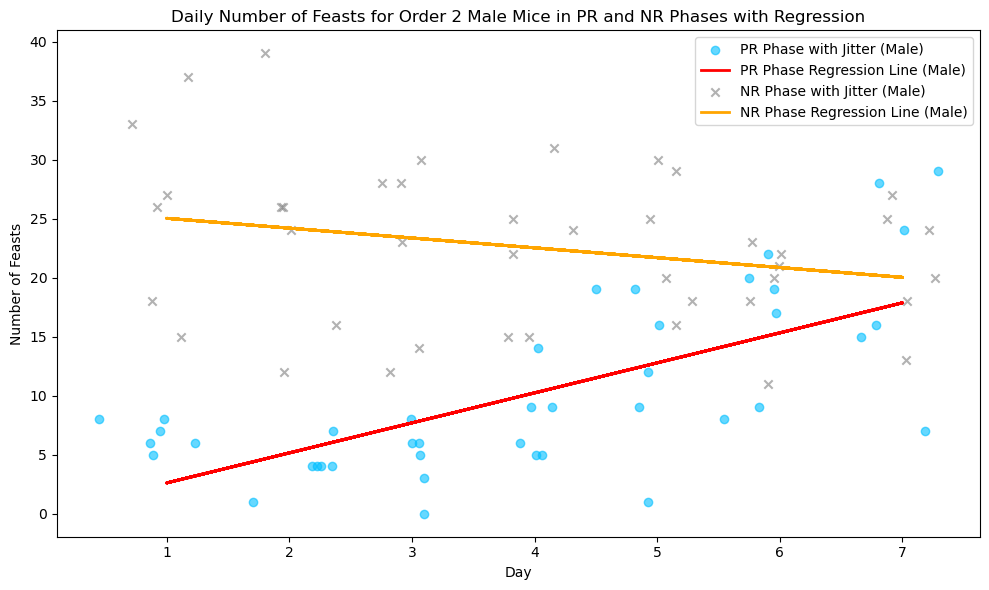

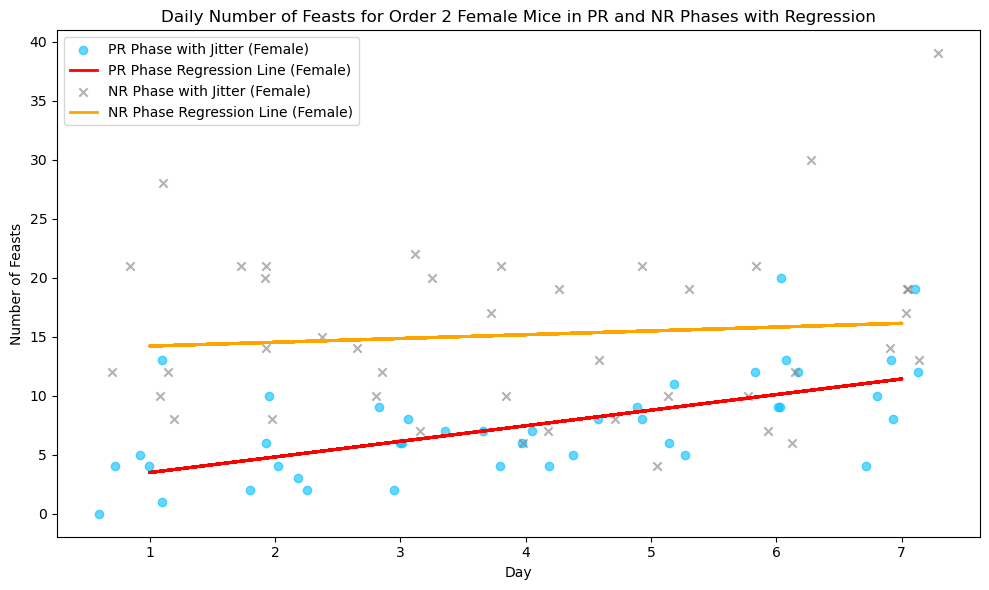

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load your dataset
file_path = '../results/FED_PROTEIN_FINAL_ULTIMATE_DATA_WITHOUT_IMI_IPI_LISTS.csv' 
data = pd.read_csv(file_path)

# Filter the data for Order 2 mice where both PR and NR phase data is available
order_2_meals = data[(data['order'] == 2) & (data['pr_mega_meals_per_day'].notna()) & (data['nr_mega_meals_per_day'].notna())]

# Convert string lists to actual lists for both PR and NR phases
order_2_meals['pr_mega_meals_per_day'] = order_2_meals['pr_mega_meals_per_day'].apply(eval)
order_2_meals['nr_mega_meals_per_day'] = order_2_meals['nr_mega_meals_per_day'].apply(eval)

def plot_regression_by_sex_with_horizontal_jitter(data, sex_label):
    # Prepare the data for PR phase regression
    pr_daily_meals = []
    pr_days = []
    mouse_ids = []

    # Prepare the data for NR phase regression
    nr_daily_meals = []
    nr_days = []

    for idx, row in data.iterrows():
        # PR phase
        pr_daily_meals.extend(row['pr_mega_meals_per_day'])
        pr_days.extend(range(1, len(row['pr_mega_meals_per_day']) + 1))
        mouse_ids.extend([row['mouse_id']] * len(row['pr_mega_meals_per_day']))

        # NR phase
        nr_daily_meals.extend(row['nr_mega_meals_per_day'])
        nr_days.extend(range(1, len(row['nr_mega_meals_per_day']) + 1))

    # Data for PR phase
    pr_regression_data = pd.DataFrame({
        'days': pr_days,
        'daily_meals': pr_daily_meals,
        'mouse_id': mouse_ids
    })

    # Data for NR phase
    nr_regression_data = pd.DataFrame({
        'days': nr_days,
        'daily_meals': nr_daily_meals,
        'mouse_id': mouse_ids
    })

    # Add horizontal jitter to the x-axis for PR and NR phases
    pr_jitter = np.random.normal(0, 0.2, size=len(pr_regression_data['days']))
    pr_regression_data['days_jittered'] = pr_regression_data['days'] + pr_jitter

    nr_jitter = np.random.normal(0, 0.2, size=len(nr_regression_data['days']))
    nr_regression_data['days_jittered'] = nr_regression_data['days'] + nr_jitter

    # Perform linear regression for PR phase
    X_pr = np.array(pr_regression_data['days']).reshape(-1, 1)
    y_pr = pr_regression_data['daily_meals']
    pr_model = LinearRegression().fit(X_pr, y_pr)
    pr_regression_data['predicted_meals'] = pr_model.predict(X_pr)

    # Perform linear regression for NR phase
    X_nr = np.array(nr_regression_data['days']).reshape(-1, 1)
    y_nr = nr_regression_data['daily_meals']
    nr_model = LinearRegression().fit(X_nr, y_nr)
    nr_regression_data['predicted_meals'] = nr_model.predict(X_nr)

    # Plot the data points with jitter and regression lines for PR and NR phases
    plt.figure(figsize=(10, 6))

    # PR phase plot
    plt.scatter(pr_regression_data['days_jittered'], pr_regression_data['daily_meals'], color='deepskyblue', label=f'PR Phase with Jitter ({sex_label})', alpha=0.6, marker='o')
    plt.plot(pr_regression_data['days'], pr_regression_data['predicted_meals'], color='red', label=f'PR Phase Regression Line ({sex_label})', linewidth=2)

    # NR phase plot
    plt.scatter(nr_regression_data['days_jittered'], nr_regression_data['daily_meals'], color='grey', label=f'NR Phase with Jitter ({sex_label})', alpha=0.6, marker='x')
    plt.plot(nr_regression_data['days'], nr_regression_data['predicted_meals'], color='orange', label=f'NR Phase Regression Line ({sex_label})', linewidth=2)

    plt.title(f'Daily Number of Feasts for Order 2 {sex_label} Mice in PR and NR Phases with Regression')
    plt.xlabel('Day')
    plt.ylabel('Number of Feasts')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Separate the data for male and female mice
male_data = order_2_meals[order_2_meals['sex'] == 'M']
female_data = order_2_meals[order_2_meals['sex'] == 'F']

# Plot for male mice with horizontal jitter
plot_regression_by_sex_with_horizontal_jitter(male_data, 'Male')

# Plot for female mice with horizontal jitter
plot_regression_by_sex_with_horizontal_jitter(female_data, 'Female')


C:\Users\hta031\AppData\Local\Temp\ipykernel_36180\1565210425.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_2_meals['pr_meals_per_day'] = order_2_meals['pr_meals_per_day'].apply(eval)
C:\Users\hta031\AppData\Local\Temp\ipykernel_36180\1565210425.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_2_meals['nr_meals_per_day'] = order_2_meals['nr_meals_per_day'].apply(eval)


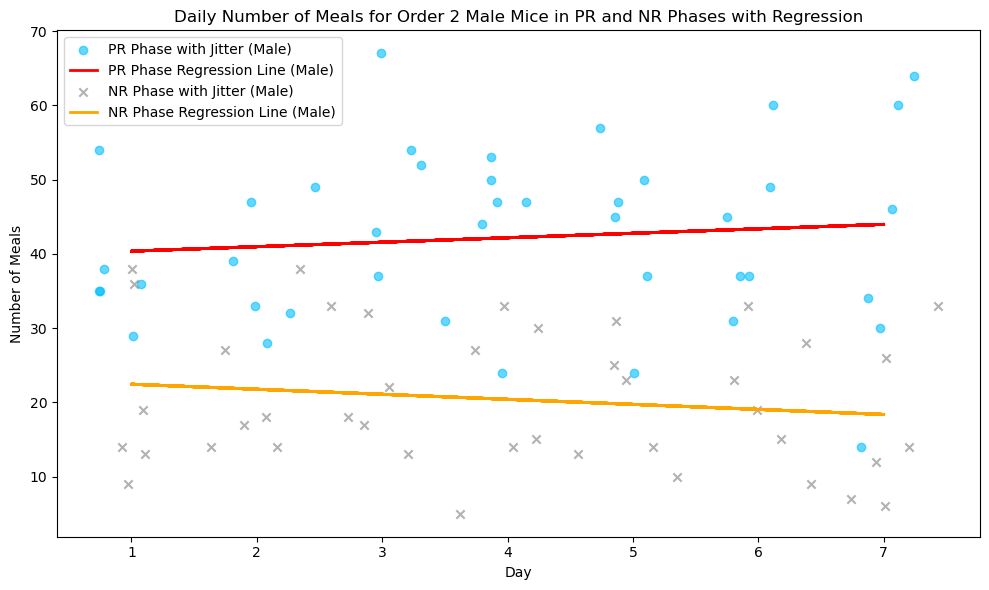

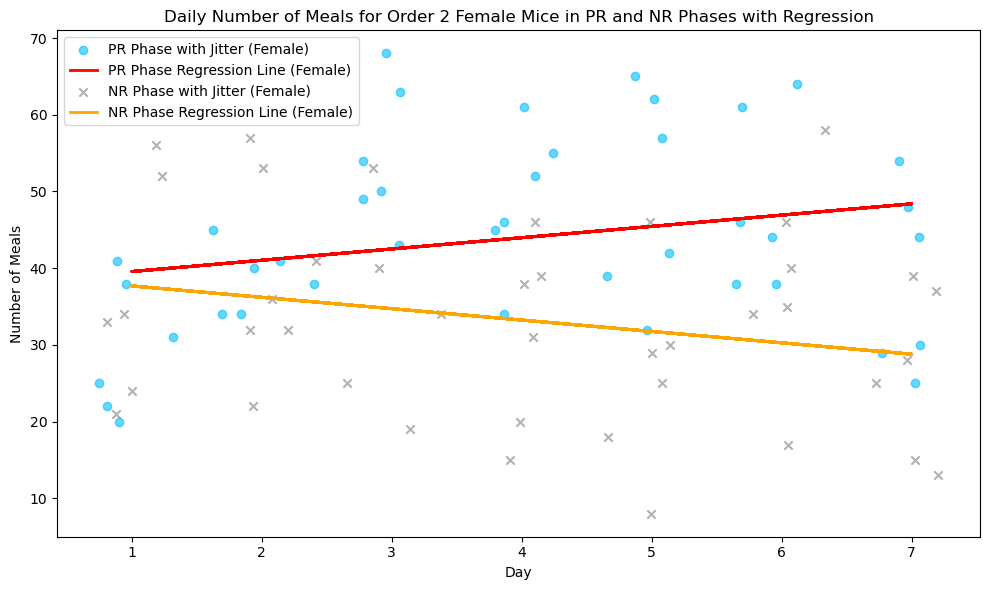

In [28]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load your dataset
file_path = '../results/FED_PROTEIN_FINAL_ULTIMATE_DATA_WITHOUT_IMI_IPI_LISTS.csv' 
data = pd.read_csv(file_path)

# Filter the data for Order 2 mice where both PR and NR phase data is available
order_2_meals = data[(data['order'] == 2) & (data['pr_meals_per_day'].notna()) & (data['nr_meals_per_day'].notna())]

# Convert string lists to actual lists for both PR and NR phases
order_2_meals['pr_meals_per_day'] = order_2_meals['pr_meals_per_day'].apply(eval)
order_2_meals['nr_meals_per_day'] = order_2_meals['nr_meals_per_day'].apply(eval)

def plot_regression_by_sex_with_horizontal_jitter(data, sex_label):
    # Prepare the data for PR phase regression
    pr_daily_meals = []
    pr_days = []
    mouse_ids = []

    # Prepare the data for NR phase regression
    nr_daily_meals = []
    nr_days = []

    for idx, row in data.iterrows():
        # PR phase
        pr_daily_meals.extend(row['pr_meals_per_day'])
        pr_days.extend(range(1, len(row['pr_meals_per_day']) + 1))
        mouse_ids.extend([row['mouse_id']] * len(row['pr_meals_per_day']))

        # NR phase
        nr_daily_meals.extend(row['nr_meals_per_day'])
        nr_days.extend(range(1, len(row['nr_meals_per_day']) + 1))

    # Data for PR phase
    pr_regression_data = pd.DataFrame({
        'days': pr_days,
        'daily_meals': pr_daily_meals,
        'mouse_id': mouse_ids
    })

    # Data for NR phase
    nr_regression_data = pd.DataFrame({
        'days': nr_days,
        'daily_meals': nr_daily_meals,
        'mouse_id': mouse_ids
    })

    # Add horizontal jitter to the x-axis for PR and NR phases
    pr_jitter = np.random.normal(0, 0.2, size=len(pr_regression_data['days']))
    pr_regression_data['days_jittered'] = pr_regression_data['days'] + pr_jitter

    nr_jitter = np.random.normal(0, 0.2, size=len(nr_regression_data['days']))
    nr_regression_data['days_jittered'] = nr_regression_data['days'] + nr_jitter

    # Perform linear regression for PR phase
    X_pr = np.array(pr_regression_data['days']).reshape(-1, 1)
    y_pr = pr_regression_data['daily_meals']
    pr_model = LinearRegression().fit(X_pr, y_pr)
    pr_regression_data['predicted_meals'] = pr_model.predict(X_pr)

    # Perform linear regression for NR phase
    X_nr = np.array(nr_regression_data['days']).reshape(-1, 1)
    y_nr = nr_regression_data['daily_meals']
    nr_model = LinearRegression().fit(X_nr, y_nr)
    nr_regression_data['predicted_meals'] = nr_model.predict(X_nr)

    # Plot the data points with jitter and regression lines for PR and NR phases
    plt.figure(figsize=(10, 6))

    # PR phase plot
    plt.scatter(pr_regression_data['days_jittered'], pr_regression_data['daily_meals'], color='deepskyblue', label=f'PR Phase with Jitter ({sex_label})', alpha=0.6, marker='o')
    plt.plot(pr_regression_data['days'], pr_regression_data['predicted_meals'], color='red', label=f'PR Phase Regression Line ({sex_label})', linewidth=2)

    # NR phase plot
    plt.scatter(nr_regression_data['days_jittered'], nr_regression_data['daily_meals'], color='grey', label=f'NR Phase with Jitter ({sex_label})', alpha=0.6, marker='x')
    plt.plot(nr_regression_data['days'], nr_regression_data['predicted_meals'], color='orange', label=f'NR Phase Regression Line ({sex_label})', linewidth=2)

    plt.title(f'Daily Number of Meals for Order 2 {sex_label} Mice in PR and NR Phases with Regression')
    plt.xlabel('Day')
    plt.ylabel('Number of Meals')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Separate the data for male and female mice
male_data = order_2_meals[order_2_meals['sex'] == 'M']
female_data = order_2_meals[order_2_meals['sex'] == 'F']

# Plot for male mice with horizontal jitter
plot_regression_by_sex_with_horizontal_jitter(male_data, 'Male')

# Plot for female mice with horizontal jitter
plot_regression_by_sex_with_horizontal_jitter(female_data, 'Female')


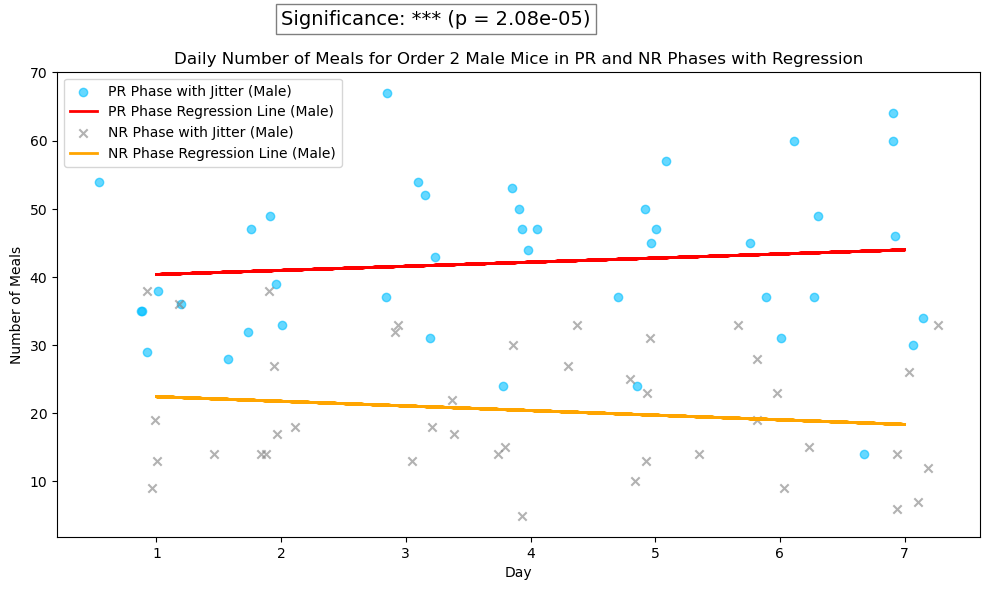

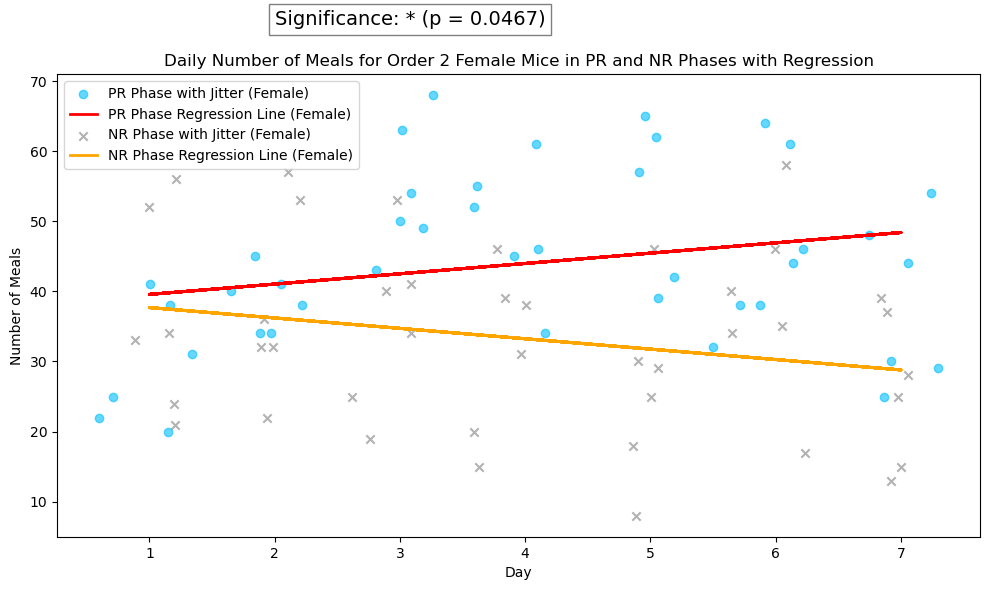

In [29]:
# Function to add significance annotations more prominently on the plot
def plot_regression_with_significance_adjusted(data, sex_label, p_value_annotation):
    # Prepare the data for PR phase regression
    pr_daily_meals = []
    pr_days = []
    mouse_ids = []

    # Prepare the data for NR phase regression
    nr_daily_meals = []
    nr_days = []

    for idx, row in data.iterrows():
        # PR phase
        pr_daily_meals.extend(row['pr_meals_per_day'])
        pr_days.extend(range(1, len(row['pr_meals_per_day']) + 1))
        mouse_ids.extend([row['mouse_id']] * len(row['pr_meals_per_day']))

        # NR phase
        nr_daily_meals.extend(row['nr_meals_per_day'])
        nr_days.extend(range(1, len(row['nr_meals_per_day']) + 1))

    # Data for PR phase
    pr_regression_data = pd.DataFrame({
        'days': pr_days,
        'daily_meals': pr_daily_meals,
        'mouse_id': mouse_ids
    })

    # Data for NR phase
    nr_regression_data = pd.DataFrame({
        'days': nr_days,
        'daily_meals': nr_daily_meals,
        'mouse_id': mouse_ids
    })

    # Add horizontal jitter to the x-axis for PR and NR phases
    pr_jitter = np.random.normal(0, 0.2, size=len(pr_regression_data['days']))
    pr_regression_data['days_jittered'] = pr_regression_data['days'] + pr_jitter

    nr_jitter = np.random.normal(0, 0.2, size=len(nr_regression_data['days']))
    nr_regression_data['days_jittered'] = nr_regression_data['days'] + nr_jitter

    # Perform linear regression for PR phase
    X_pr = np.array(pr_regression_data['days']).reshape(-1, 1)
    y_pr = pr_regression_data['daily_meals']
    pr_model = LinearRegression().fit(X_pr, y_pr)
    pr_regression_data['predicted_meals'] = pr_model.predict(X_pr)

    # Perform linear regression for NR phase
    X_nr = np.array(nr_regression_data['days']).reshape(-1, 1)
    y_nr = nr_regression_data['daily_meals']
    nr_model = LinearRegression().fit(X_nr, y_nr)
    nr_regression_data['predicted_meals'] = nr_model.predict(X_nr)

    # Plot the data points with jitter and regression lines for PR and NR phases
    plt.figure(figsize=(10, 6))

    # PR phase plot
    plt.scatter(pr_regression_data['days_jittered'], pr_regression_data['daily_meals'], color='deepskyblue', label=f'PR Phase with Jitter ({sex_label})', alpha=0.6, marker='o')
    plt.plot(pr_regression_data['days'], pr_regression_data['predicted_meals'], color='red', label=f'PR Phase Regression Line ({sex_label})', linewidth=2)

    # NR phase plot
    plt.scatter(nr_regression_data['days_jittered'], nr_regression_data['daily_meals'], color='grey', label=f'NR Phase with Jitter ({sex_label})', alpha=0.6, marker='x')
    plt.plot(nr_regression_data['days'], nr_regression_data['predicted_meals'], color='orange', label=f'NR Phase Regression Line ({sex_label})', linewidth=2)

    # Add statistical significance (p-value) to the plot with clearer positioning
    y_max = max(max(y_pr), max(y_nr)) + 10  # Ensuring a higher position for better visibility
    plt.text(2, y_max, f'Significance: {p_value_annotation}', fontsize=14, color='black', bbox=dict(facecolor='white', alpha=0.5))

    plt.title(f'Daily Number of Meals for Order 2 {sex_label} Mice in PR and NR Phases with Regression')
    plt.xlabel('Day')
    plt.ylabel('Number of Meals')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot for male mice with statistical significance (***)
plot_regression_with_significance_adjusted(male_data, 'Male', '*** (p = 2.08e-05)')

# Plot for female mice with statistical significance (*)
plot_regression_with_significance_adjusted(female_data, 'Female', '* (p = 0.0467)')


C:\Users\hta031\AppData\Local\Temp\ipykernel_36180\4149691773.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_1_males['pr_meals_per_day'] = order_1_males['pr_meals_per_day'].apply(eval)
C:\Users\hta031\AppData\Local\Temp\ipykernel_36180\4149691773.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_2_males['pr_meals_per_day'] = order_2_males['pr_meals_per_day'].apply(eval)


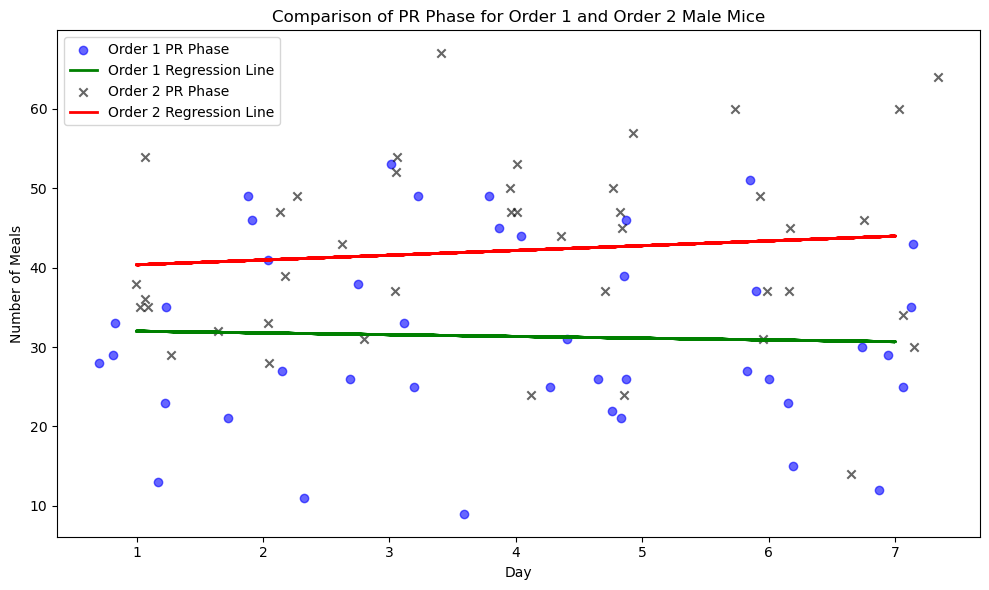

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load your dataset
file_path = '../results/FED_PROTEIN_FINAL_ULTIMATE_DATA_WITHOUT_IMI_IPI_LISTS.csv' 
data = pd.read_csv(file_path)

# Filter the data for Order 1 and Order 2 male mice where PR phase data is available
order_1_males = data[(data['order'] == 1) & (data['sex'] == 'M') & (data['pr_meals_per_day'].notna())]
order_2_males = data[(data['order'] == 2) & (data['sex'] == 'M') & (data['pr_meals_per_day'].notna())]

# Convert string lists to actual lists for PR phase
order_1_males['pr_meals_per_day'] = order_1_males['pr_meals_per_day'].apply(eval)
order_2_males['pr_meals_per_day'] = order_2_males['pr_meals_per_day'].apply(eval)

def plot_pr_phase_comparison(order_1_data, order_2_data):
    # Prepare the data for PR phase regression for Order 1
    pr_1_meals = []
    pr_1_days = []
    
    for idx, row in order_1_data.iterrows():
        pr_1_meals.extend(row['pr_meals_per_day'])
        pr_1_days.extend(range(1, len(row['pr_meals_per_day']) + 1))
    
    # Prepare the data for PR phase regression for Order 2
    pr_2_meals = []
    pr_2_days = []

    for idx, row in order_2_data.iterrows():
        pr_2_meals.extend(row['pr_meals_per_day'])
        pr_2_days.extend(range(1, len(row['pr_meals_per_day']) + 1))
    
    # Add jitter to the x-axis for both groups
    pr_1_jitter = np.random.normal(0, 0.2, size=len(pr_1_days))
    pr_2_jitter = np.random.normal(0, 0.2, size=len(pr_2_days))
    
    # Perform linear regression for Order 1
    X_pr_1 = np.array(pr_1_days).reshape(-1, 1)
    y_pr_1 = pr_1_meals
    pr_model_1 = LinearRegression().fit(X_pr_1, y_pr_1)
    predicted_pr_1 = pr_model_1.predict(X_pr_1)
    
    # Perform linear regression for Order 2
    X_pr_2 = np.array(pr_2_days).reshape(-1, 1)
    y_pr_2 = pr_2_meals
    pr_model_2 = LinearRegression().fit(X_pr_2, y_pr_2)
    predicted_pr_2 = pr_model_2.predict(X_pr_2)

    # Plot the data points with jitter and regression lines for both orders
    plt.figure(figsize=(10, 6))
    
    # PR phase for Order 1 males
    plt.scatter(pr_1_days + pr_1_jitter, pr_1_meals, color='blue', alpha=0.6, label='Order 1 PR Phase', marker='o')
    plt.plot(pr_1_days, predicted_pr_1, color='green', label='Order 1 Regression Line', linewidth=2)
    
    # PR phase for Order 2 males
    plt.scatter(pr_2_days + pr_2_jitter, pr_2_meals, color='black', alpha=0.6, label='Order 2 PR Phase', marker='x')
    plt.plot(pr_2_days, predicted_pr_2, color='red', label='Order 2 Regression Line', linewidth=2)

    plt.title('Comparison of PR Phase for Order 1 and Order 2 Male Mice')
    plt.xlabel('Day')
    plt.ylabel('Number of Meals')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot the PR phase comparison for Order 1 and Order 2 male mice
plot_pr_phase_comparison(order_1_males, order_2_males)


C:\Users\hta031\AppData\Local\Temp\ipykernel_36180\1204187058.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_1_males['nr_meals_per_day'] = order_1_males['nr_meals_per_day'].apply(eval)
C:\Users\hta031\AppData\Local\Temp\ipykernel_36180\1204187058.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_2_males['nr_meals_per_day'] = order_2_males['nr_meals_per_day'].apply(eval)


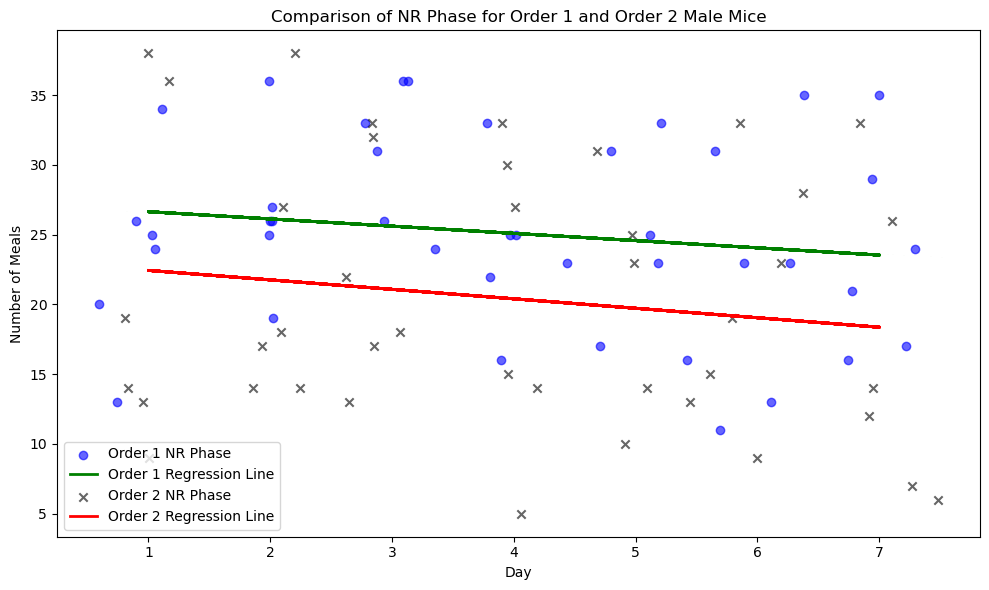

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load your dataset
file_path = '../results/FED_PROTEIN_FINAL_ULTIMATE_DATA_WITHOUT_IMI_IPI_LISTS.csv' 
data = pd.read_csv(file_path)

# Filter the data for Order 1 and Order 2 male mice where PR phase data is available
order_1_males = data[(data['order'] == 1) & (data['sex'] == 'M') & (data['nr_meals_per_day'].notna())]
order_2_males = data[(data['order'] == 2) & (data['sex'] == 'M') & (data['nr_meals_per_day'].notna())]

# Convert string lists to actual lists for PR phase
order_1_males['nr_meals_per_day'] = order_1_males['nr_meals_per_day'].apply(eval)
order_2_males['nr_meals_per_day'] = order_2_males['nr_meals_per_day'].apply(eval)

def plot_pr_phase_comparison(order_1_data, order_2_data):
    # Prepare the data for PR phase regression for Order 1
    pr_1_meals = []
    pr_1_days = []
    
    for idx, row in order_1_data.iterrows():
        pr_1_meals.extend(row['nr_meals_per_day'])
        pr_1_days.extend(range(1, len(row['nr_meals_per_day']) + 1))
    
    # Prepare the data for PR phase regression for Order 2
    pr_2_meals = []
    pr_2_days = []

    for idx, row in order_2_data.iterrows():
        pr_2_meals.extend(row['nr_meals_per_day'])
        pr_2_days.extend(range(1, len(row['nr_meals_per_day']) + 1))
    
    # Add jitter to the x-axis for both groups
    pr_1_jitter = np.random.normal(0, 0.2, size=len(pr_1_days))
    pr_2_jitter = np.random.normal(0, 0.2, size=len(pr_2_days))
    
    # Perform linear regression for Order 1
    X_pr_1 = np.array(pr_1_days).reshape(-1, 1)
    y_pr_1 = pr_1_meals
    pr_model_1 = LinearRegression().fit(X_pr_1, y_pr_1)
    predicted_pr_1 = pr_model_1.predict(X_pr_1)
    
    # Perform linear regression for Order 2
    X_pr_2 = np.array(pr_2_days).reshape(-1, 1)
    y_pr_2 = pr_2_meals
    pr_model_2 = LinearRegression().fit(X_pr_2, y_pr_2)
    predicted_pr_2 = pr_model_2.predict(X_pr_2)

    # Plot the data points with jitter and regression lines for both orders
    plt.figure(figsize=(10, 6))
    
    # PR phase for Order 1 males
    plt.scatter(pr_1_days + pr_1_jitter, pr_1_meals, color='blue', alpha=0.6, label='Order 1 NR Phase', marker='o')
    plt.plot(pr_1_days, predicted_pr_1, color='green', label='Order 1 Regression Line', linewidth=2)
    
    # PR phase for Order 2 males
    plt.scatter(pr_2_days + pr_2_jitter, pr_2_meals, color='black', alpha=0.6, label='Order 2 NR Phase', marker='x')
    plt.plot(pr_2_days, predicted_pr_2, color='red', label='Order 2 Regression Line', linewidth=2)

    plt.title('Comparison of NR Phase for Order 1 and Order 2 Male Mice')
    plt.xlabel('Day')
    plt.ylabel('Number of Meals')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot the PR phase comparison for Order 1 and Order 2 male mice
plot_pr_phase_comparison(order_1_males, order_2_males)


C:\Users\hta031\AppData\Local\Temp\ipykernel_36180\620823334.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_1_males['nr_mega_meals_per_day'] = order_1_males['nr_mega_meals_per_day'].apply(eval)
C:\Users\hta031\AppData\Local\Temp\ipykernel_36180\620823334.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_2_males['nr_mega_meals_per_day'] = order_2_males['nr_mega_meals_per_day'].apply(eval)


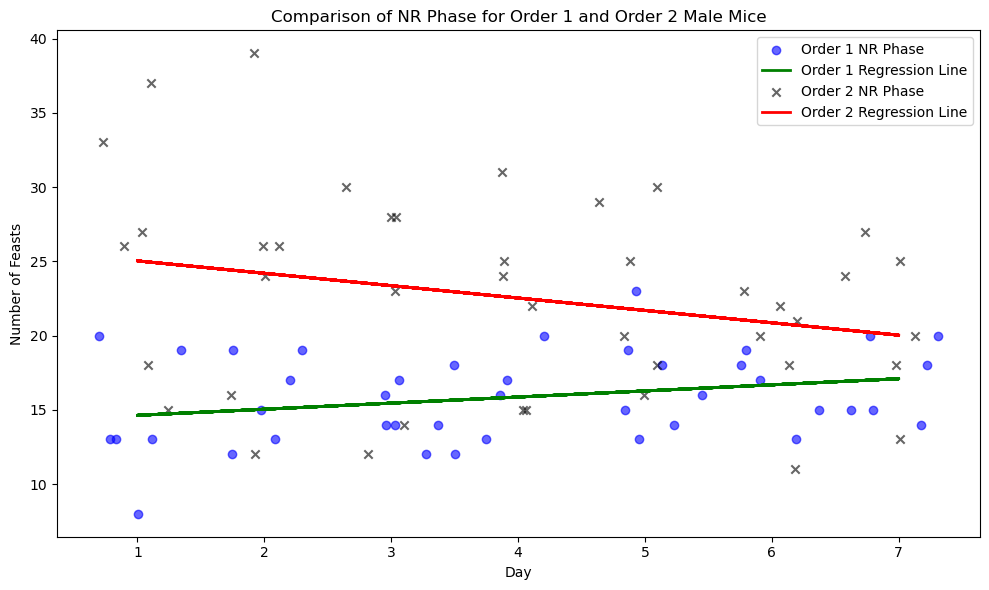

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load your dataset
file_path = '../results/FED_PROTEIN_FINAL_ULTIMATE_DATA_WITHOUT_IMI_IPI_LISTS.csv' 
data = pd.read_csv(file_path)

# Filter the data for Order 1 and Order 2 male mice where PR phase data is available
order_1_males = data[(data['order'] == 1) & (data['sex'] == 'M') & (data['nr_mega_meals_per_day'].notna())]
order_2_males = data[(data['order'] == 2) & (data['sex'] == 'M') & (data['nr_mega_meals_per_day'].notna())]

# Convert string lists to actual lists for PR phase
order_1_males['nr_mega_meals_per_day'] = order_1_males['nr_mega_meals_per_day'].apply(eval)
order_2_males['nr_mega_meals_per_day'] = order_2_males['nr_mega_meals_per_day'].apply(eval)

def plot_pr_phase_comparison(order_1_data, order_2_data):
    # Prepare the data for PR phase regression for Order 1
    pr_1_meals = []
    pr_1_days = []
    
    for idx, row in order_1_data.iterrows():
        pr_1_meals.extend(row['nr_mega_meals_per_day'])
        pr_1_days.extend(range(1, len(row['nr_mega_meals_per_day']) + 1))
    
    # Prepare the data for PR phase regression for Order 2
    pr_2_meals = []
    pr_2_days = []

    for idx, row in order_2_data.iterrows():
        pr_2_meals.extend(row['nr_mega_meals_per_day'])
        pr_2_days.extend(range(1, len(row['nr_mega_meals_per_day']) + 1))
    
    # Add jitter to the x-axis for both groups
    pr_1_jitter = np.random.normal(0, 0.2, size=len(pr_1_days))
    pr_2_jitter = np.random.normal(0, 0.2, size=len(pr_2_days))
    
    # Perform linear regression for Order 1
    X_pr_1 = np.array(pr_1_days).reshape(-1, 1)
    y_pr_1 = pr_1_meals
    pr_model_1 = LinearRegression().fit(X_pr_1, y_pr_1)
    predicted_pr_1 = pr_model_1.predict(X_pr_1)
    
    # Perform linear regression for Order 2
    X_pr_2 = np.array(pr_2_days).reshape(-1, 1)
    y_pr_2 = pr_2_meals
    pr_model_2 = LinearRegression().fit(X_pr_2, y_pr_2)
    predicted_pr_2 = pr_model_2.predict(X_pr_2)

    # Plot the data points with jitter and regression lines for both orders
    plt.figure(figsize=(10, 6))
    
    # PR phase for Order 1 males
    plt.scatter(pr_1_days + pr_1_jitter, pr_1_meals, color='blue', alpha=0.6, label='Order 1 NR Phase', marker='o')
    plt.plot(pr_1_days, predicted_pr_1, color='green', label='Order 1 Regression Line', linewidth=2)
    
    # PR phase for Order 2 males
    plt.scatter(pr_2_days + pr_2_jitter, pr_2_meals, color='black', alpha=0.6, label='Order 2 NR Phase', marker='x')
    plt.plot(pr_2_days, predicted_pr_2, color='red', label='Order 2 Regression Line', linewidth=2)

    plt.title('Comparison of NR Phase for Order 1 and Order 2 Male Mice')
    plt.xlabel('Day')
    plt.ylabel('Number of Feasts')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot the PR phase comparison for Order 1 and Order 2 male mice
plot_pr_phase_comparison(order_1_males, order_2_males)


C:\Users\hta031\AppData\Local\Temp\ipykernel_36180\4184702484.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_2_males_imi['pr_imi'] = order_2_males_imi['pr_imi'].apply(eval)


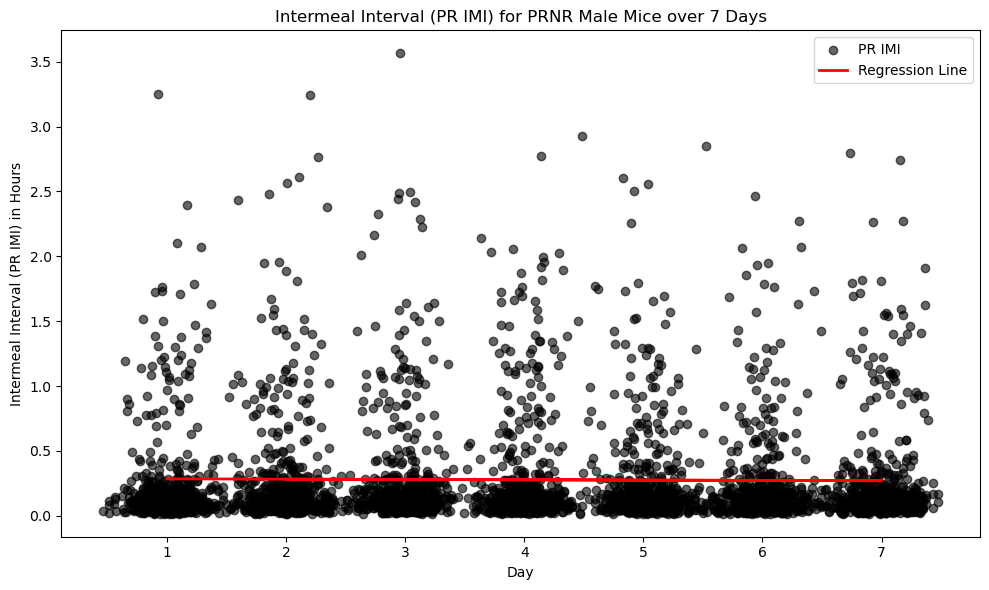

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load your dataset
file_path = '../results/FED_PROTEIN_FINAL)ULTIMATE_IMI_DATA.csv'
imi_data = pd.read_csv(file_path)

# Filter the data for Order 2 male mice
order_2_males_imi = imi_data[(imi_data['order'] == 2) & (imi_data['sex'] == 'M')]

# Convert string lists to actual lists for pr_imi
order_2_males_imi['pr_imi'] = order_2_males_imi['pr_imi'].apply(eval)

# Prepare data to display all IMI values per day with jitter
imi_values_all = []
day_labels_all = []

# Populate the lists with IMI values for each day
for idx, row in order_2_males_imi.iterrows():
    pr_imi = row['pr_imi']
    for i, imi in enumerate(pr_imi):
        day_index = i % 7  # Group within the 7-day window
        imi_values_all.append(imi)
        day_labels_all.append(day_index + 1)  # Days labeled from 1 to 7

# Apply horizontal jitter to the day labels for better visualization
day_labels_jittered = day_labels_all + np.random.normal(0, 0.2, size=len(day_labels_all))

# Perform linear regression on all data points
X_all = np.array(day_labels_all).reshape(-1, 1)
y_all = np.array(imi_values_all)
imi_model_all = LinearRegression().fit(X_all, y_all)
predicted_imi_all = imi_model_all.predict(X_all)

# Plot the IMI data points with horizontal jitter and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(day_labels_jittered, imi_values_all, color='black', alpha=0.6, label="PR IMI", marker='o')
plt.plot(day_labels_all, predicted_imi_all, color='red', label='Regression Line', linewidth=2)
plt.title('Intermeal Interval (PR IMI) for PRNR Male Mice over 7 Days')
plt.xlabel('Day')
plt.ylabel('Intermeal Interval (PR IMI) in Hours')
plt.xticks(list(range(1, 8)))  # Ensure the x-axis shows 1 to 7 for the days
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\hta031\AppData\Local\Temp\ipykernel_36180\3526840921.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_2_males_imi['nr_imi'] = order_2_males_imi['nr_imi'].apply(eval)


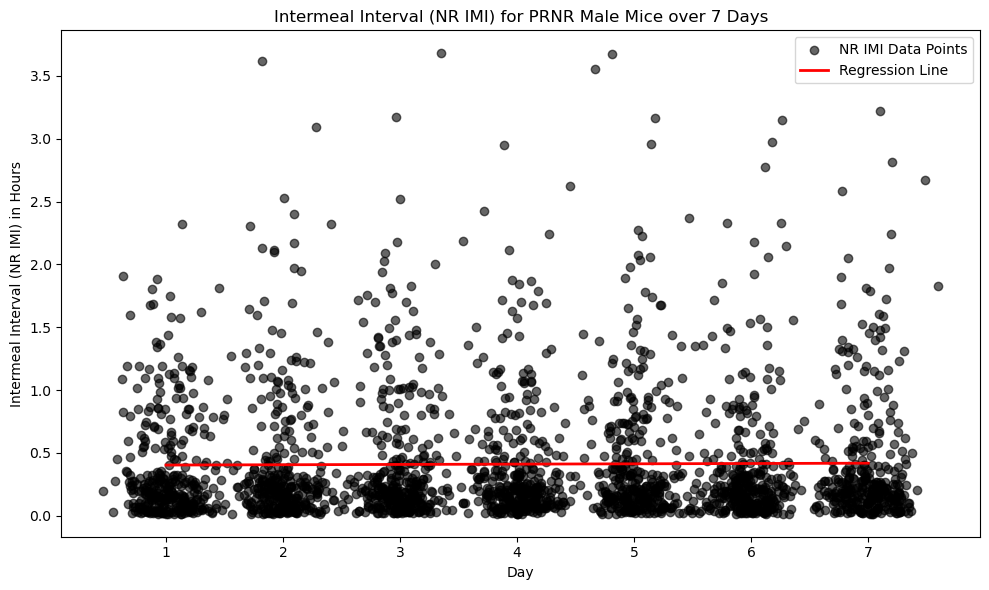

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load your dataset
file_path = '../results/FED_PROTEIN_FINAL)ULTIMATE_IMI_DATA.csv'
imi_data = pd.read_csv(file_path)

# Filter the data for Order 2 male mice
order_2_males_imi = imi_data[(imi_data['order'] == 2) & (imi_data['sex'] == 'M')]

# Convert string lists to actual lists for pr_imi
order_2_males_imi['nr_imi'] = order_2_males_imi['nr_imi'].apply(eval)

# Prepare data to display all IMI values per day with jitter
imi_values_all = []
day_labels_all = []

# Populate the lists with IMI values for each day
for idx, row in order_2_males_imi.iterrows():
    pr_imi = row['nr_imi']
    for i, imi in enumerate(pr_imi):
        day_index = i % 7  # Group within the 7-day window
        imi_values_all.append(imi)
        day_labels_all.append(day_index + 1)  # Days labeled from 1 to 7

# Apply horizontal jitter to the day labels for better visualization
day_labels_jittered = day_labels_all + np.random.normal(0, 0.2, size=len(day_labels_all))

# Perform linear regression on all data points
X_all = np.array(day_labels_all).reshape(-1, 1)
y_all = np.array(imi_values_all)
imi_model_all = LinearRegression().fit(X_all, y_all)
predicted_imi_all = imi_model_all.predict(X_all)

# Plot the IMI data points with horizontal jitter and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(day_labels_jittered, imi_values_all, color='black', alpha=0.6, label='NR IMI Data Points', marker='o')
plt.plot(day_labels_all, predicted_imi_all, color='red', label='Regression Line', linewidth=2)
plt.title('Intermeal Interval (NR IMI) for PRNR Male Mice over 7 Days')
plt.xlabel('Day')
plt.ylabel('Intermeal Interval (NR IMI) in Hours')
plt.xticks(list(range(1, 8)))  # Ensure the x-axis shows 1 to 7 for the days
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\hta031\AppData\Local\Temp\ipykernel_36180\3121890271.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_2_males_imi['pr_imi'] = order_2_males_imi['pr_imi'].apply(eval)
C:\Users\hta031\AppData\Local\Temp\ipykernel_36180\3121890271.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_1_males_imi['pr_imi'] = order_1_males_imi['pr_imi'].apply(eval)


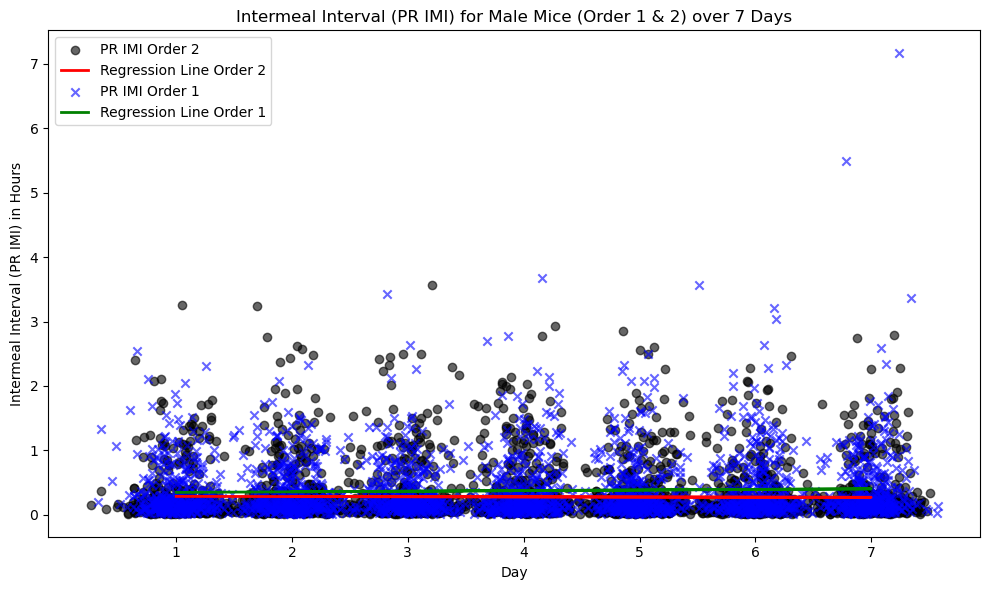

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load your dataset
file_path = '../results/FED_PROTEIN_FINAL)ULTIMATE_IMI_DATA.csv'
imi_data = pd.read_csv(file_path)

# Filter the data for Order 2 male mice
order_2_males_imi = imi_data[(imi_data['order'] == 2) & (imi_data['sex'] == 'M')]

# Convert string lists to actual lists for pr_imi for Order 2
order_2_males_imi['pr_imi'] = order_2_males_imi['pr_imi'].apply(eval)

# Prepare data to display all IMI values per day with jitter for Order 2 males
imi_values_all = []
day_labels_all = []

for idx, row in order_2_males_imi.iterrows():
    pr_imi = row['pr_imi']
    for i, imi in enumerate(pr_imi):
        day_index = i % 7  # Group within the 7-day window
        imi_values_all.append(imi)
        day_labels_all.append(day_index + 1)  # Days labeled from 1 to 7

# Apply horizontal jitter to the day labels for better visualization (Order 2 males)
day_labels_jittered = day_labels_all + np.random.normal(0, 0.2, size=len(day_labels_all))

# Perform linear regression on all data points (Order 2 males)
X_all = np.array(day_labels_all).reshape(-1, 1)
y_all = np.array(imi_values_all)
imi_model_all = LinearRegression().fit(X_all, y_all)
predicted_imi_all = imi_model_all.predict(X_all)

# Filter the data for Order 1 male mice
order_1_males_imi = imi_data[(imi_data['order'] == 1) & (imi_data['sex'] == 'M')]

# Convert string lists to actual lists for pr_imi for Order 1
order_1_males_imi['pr_imi'] = order_1_males_imi['pr_imi'].apply(eval)

# Prepare data for Order 1 males
imi_values_order_1 = []
day_labels_order_1 = []

for idx, row in order_1_males_imi.iterrows():
    pr_imi = row['pr_imi']
    for i, imi in enumerate(pr_imi):
        day_index = i % 7  # Group within the 7-day window
        imi_values_order_1.append(imi)
        day_labels_order_1.append(day_index + 1)  # Days labeled from 1 to 7

# Apply horizontal jitter to the day labels for better visualization (Order 1 males)
day_labels_order_1_jittered = day_labels_order_1 + np.random.normal(0, 0.2, size=len(day_labels_order_1))

# Perform linear regression on all data points (Order 1 males)
X_order_1 = np.array(day_labels_order_1).reshape(-1, 1)
y_order_1 = np.array(imi_values_order_1)
imi_model_order_1 = LinearRegression().fit(X_order_1, y_order_1)
predicted_imi_order_1 = imi_model_order_1.predict(X_order_1)

# Plot the IMI data points for both Order 2 and Order 1 males
plt.figure(figsize=(10, 6))

# Plot for Order 2 males (black points, red regression line)
plt.scatter(day_labels_jittered, imi_values_all, color='black', alpha=0.6, label="PR IMI Order 2", marker='o')
plt.plot(day_labels_all, predicted_imi_all, color='red', label='Regression Line Order 2', linewidth=2)

# Plot for Order 1 males (blue points, green regression line)
plt.scatter(day_labels_order_1_jittered, imi_values_order_1, color='blue', alpha=0.6, label="PR IMI Order 1", marker='x')
plt.plot(day_labels_order_1, predicted_imi_order_1, color='green', label='Regression Line Order 1', linewidth=2)

plt.title('Intermeal Interval (PR IMI) for Male Mice (Order 1 & 2) over 7 Days')
plt.xlabel('Day')
plt.ylabel('Intermeal Interval (PR IMI) in Hours')
plt.xticks(list(range(1, 8)))  # Ensure the x-axis shows 1 to 7 for the days
plt.legend()
plt.tight_layout()
plt.show()


# Cells below gets imi and ipi for kde plots

In [5]:
import csv
from datetime import datetime
import numpy as np
import trompy as tp

def get_FEDevents(filename, eventname):
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']
    
    try:
        file = open(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []
    
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = []
    for row in csvreader:
        rows.append(row)

    # Check if rows are empty
    if len(rows) == 0:
        print(f"No data found in file: {filename}")
        return []

    # Determine which format should be used
    try:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[0])
        date_format = formats[0]
    except ValueError:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[1])
        date_format = formats[1]

    timestamps = []
    for row in rows: 
        if row[7] == eventname:  # Check event column
            date_time_obj = datetime.strptime(row[0], date_format)
            timestamps.append(date_time_obj)

    if len(timestamps) == 0:
        print(f"No {eventname} events found in file: {filename}")
        return []

    t0 = rows[0][0]
    day = t0.split()[0] 
    lightson = day + " 07:00:00"
    refpoint = datetime.strptime(lightson, date_format)
    
    pellettimes = []
    for t in timestamps:
        Deltat = t - refpoint
        Deltatinseconds = Deltat.total_seconds()
        Deltatinhours = Deltatinseconds / 3600
        pellettimes.append(Deltatinhours)

    return pellettimes
def get_data_subset(dictionary, selectors, verbose=True):
    output_dictionary = dictionary.copy()
    for key, value in selectors.items():
        for mouse_id in dictionary.keys():
            try:
                if output_dictionary[mouse_id][key] != value:
                    output_dictionary.pop(mouse_id)
            except KeyError: 
                pass

    if verbose:
        print("{} items in output dictionary".format(len(output_dictionary.keys())))
    
    return output_dictionary

def get_data_fields(dictionary, fields, selectors):
    output_list = []
    reduced_dictionary = get_data_subset(dictionary, selectors)
    
    if len(reduced_dictionary.keys()) > 0:
        for field in fields:
            output_sublist = []
            try:
                for key in reduced_dictionary.keys():
                    output_sublist.append(reduced_dictionary[key][field])
            except KeyError:
                print("{} is not a key in selected dictionary".format(field))
                return
            output_list.append(output_sublist)
    else:
        print("No data in fields in selected dictionary")

    if len(output_list) == 1:
        output_list = output_list[0]
        
    return output_list

# Function to get meal, snack, and mega meal metrics, including mega_meal_frequency and mega_meal_size
def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60):
    if not pellettimes:
        return (0, 0, 0, 0, 0, 0, 0, 0, [[0]*24]*7, [[0]*24]*7, [[0]*24]*7, 0, 0, 0, 0, [], [])

    IPIs = np.diff(np.array(pellettimes))
    meals = []
    snacks = []
    mega_meals = []
    IMIs = []
    current_event = [pellettimes[0]]

    # Hourly tracking for each day
    hourly_meals_per_day = [[0]*24 for _ in range(7)]
    hourly_snacks_per_day = [[0]*24 for _ in range(7)]
    hourly_mega_meals_per_day = [[0]*24 for _ in range(7)]

    for i, ipi in enumerate(IPIs):
        if ipi <= meal_threshold:
            current_event.append(pellettimes[i + 1])
        else:
            if len(current_event) == 1:
                snacks.append(current_event)
                day_index = int(current_event[0] // 24)
                hour = int(current_event[0]) % 24
                if day_index < 7:  # Make sure we are within the 7-day boundary
                    hourly_snacks_per_day[day_index][hour] += 1
            elif 2 <= len(current_event) <= 4:
                meals.append(current_event)
                day_index = int(current_event[0] // 24)
                hour = int(current_event[0]) % 24
                if day_index < 7:
                    hourly_meals_per_day[day_index][hour] += 1
            elif len(current_event) >= 5:
                mega_meals.append(current_event)
                day_index = int(current_event[0] // 24)
                hour = int(current_event[0]) % 24
                if day_index < 7:
                    hourly_mega_meals_per_day[day_index][hour] += 1
            IMIs.append(ipi)  # Store IMI as a list of timestamps
            current_event = [pellettimes[i + 1]]

    # Handle the last sequence
    if current_event:
        day_index = int(current_event[0] // 24)
        hour = int(current_event[0]) % 24
        if len(current_event) == 1:
            snacks.append(current_event)
            if day_index < 7:
                hourly_snacks_per_day[day_index][hour] += 1
        elif 2 <= len(current_event) <= 4:
            meals.append(current_event)
            if day_index < 7:
                hourly_meals_per_day[day_index][hour] += 1
        elif len(current_event) >= 5:
            mega_meals.append(current_event)
            if day_index < 7:
                hourly_mega_meals_per_day[day_index][hour] += 1

    nmeals = len(meals)
    nsnacks = len(snacks)
    n_mega_meals = len(mega_meals)  # Add the number of mega meals

    total_pellets = len(pellettimes)
    mealsize = sum(len(meal) for meal in meals) / nmeals if nmeals else 0
    snack_size = sum(len(snack) for snack in snacks) / nsnacks if nsnacks else 0
    total_observation_period = max(pellettimes) - min(pellettimes)
    meal_frequency = nmeals / total_observation_period if total_observation_period > 0 else 0
    snack_frequency = nsnacks / total_observation_period if total_observation_period > 0 else 0
    mega_meal_frequency = n_mega_meals / total_observation_period if total_observation_period > 0 else 0
    average_mega_meal_size = sum(len(meal) for meal in mega_meals) / n_mega_meals if n_mega_meals else 0

    return (mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, 
            mega_meal_frequency, average_mega_meal_size, hourly_meals_per_day, 
            hourly_snacks_per_day, hourly_mega_meals_per_day, meals, snacks, mega_meals, n_mega_meals, IPIs, IMIs)


# Function to get events (meals, snacks, mega meals) per day based on timestamps
def get_events_per_day(events, days=7):
    events_per_day = [0] * days  # Initialize with zeros for the duration of the phase
    for event_list in events:
        if len(event_list) > 0:
            event_day = int(event_list[0] // 24)
            if event_day < days:
                events_per_day[event_day] += 1
    return events_per_day

# Function to calculate pellets per day
def get_pellets_per_day(timestamps, days=7):
    pellets_per_day = [0] * days
    for day in range(days):
        pellets = [t for t in timestamps if (t > day * 24) and (t < (day + 1) * 24)]
        n_pellets = len(pellets)
        pellets_per_day[day] = n_pellets

    return pellets_per_day


# Load the metafile and process the data
metafile = "..\\FEDProtein_METAFILE.xls"
rows, header = tp.metafilereader(metafile, sheetname="METAFILE")

mice = {}
for row in rows:
    mouse_id = row[1]
    if mouse_id not in mice.keys():
        mice[mouse_id] = {}
        mice[mouse_id]["sex"] = row[4]
        mice[mouse_id]["order"] = row[5]

for key in mice.keys():
    for row in rows:
        if row[1] == key and row[3] == "FF":
            filename = "..\\data\\{}".format(row[0])
            if row[2] == "GRAIN":
                mice[key]["grain_timestamps"] = get_FEDevents(filename, "Pellet")
            elif row[2] == "PR":
                mice[key]["pr_timestamps"] = get_FEDevents(filename, "Pellet")
            elif row[2] == "NR":
                mice[key]["nr_timestamps"] = get_FEDevents(filename, "Pellet")
            else:
                print(row[2], "is not a valid type of pellet for", key)

# Add meal, snack, mega meal metrics, and IMI, IPI calculations to the dictionary
for key in mice.keys():
    grain_timestamps = mice[key].get("grain_timestamps", [])
    pr_timestamps = mice[key].get("pr_timestamps", [])
    nr_timestamps = mice[key].get("nr_timestamps", [])

        # Get metrics for GRAIN, PR, and NR phases
    grain_metrics = get_meal_and_snack_metrics(grain_timestamps)
    pr_metrics = get_meal_and_snack_metrics(pr_timestamps)
    nr_metrics = get_meal_and_snack_metrics(nr_timestamps)

    # GRAIN phase
    (
        mice[key]["grain_meal_size"],
        mice[key]["grain_snack_size"],
        mice[key]["grain_number_of_meals"],
        mice[key]["grain_meal_frequency"],
        mice[key]["grain_number_of_snacks"],
        mice[key]["grain_snack_frequency"],
        mice[key]["grain_mega_meal_frequency"],
        mice[key]["grain_mega_meal_size"],
        mice[key]["grain_hourly_meals"],
        mice[key]["grain_hourly_snacks"],
        mice[key]["grain_hourly_mega_meals"],
        grain_meals,
        grain_snacks,
        grain_mega_meals,
        mice[key]["grain_number_of_mega_meals"],
        mice[key]["grain_ipi"],       # IPI for grain phase
        mice[key]["grain_imi"]        # IMI for grain phase
    ) = grain_metrics

    # PR phase
    (
        mice[key]["pr_meal_size"],
        mice[key]["pr_snack_size"],
        mice[key]["pr_number_of_meals"],
        mice[key]["pr_meal_frequency"],
        mice[key]["pr_number_of_snacks"],
        mice[key]["pr_snack_frequency"],
        mice[key]["pr_mega_meal_frequency"],
        mice[key]["pr_mega_meal_size"],
        mice[key]["pr_hourly_meals"],
        mice[key]["pr_hourly_snacks"],
        mice[key]["pr_hourly_mega_meals"],
        pr_meals,
        pr_snacks,
        pr_mega_meals,
        mice[key]["pr_number_of_mega_meals"],
        mice[key]["pr_ipi"],          # IPI for PR phase
        mice[key]["pr_imi"]           # IMI for PR phase
    ) = pr_metrics

    # NR phase
    (
        mice[key]["nr_meal_size"],
        mice[key]["nr_snack_size"],
        mice[key]["nr_number_of_meals"],
        mice[key]["nr_meal_frequency"],
        mice[key]["nr_number_of_snacks"],
        mice[key]["nr_snack_frequency"],
        mice[key]["nr_mega_meal_frequency"],
        mice[key]["nr_mega_meal_size"],
        mice[key]["nr_hourly_meals"],
        mice[key]["nr_hourly_snacks"],
        mice[key]["nr_hourly_mega_meals"],
        nr_meals,
        nr_snacks,
        nr_mega_meals,
        mice[key]["nr_number_of_mega_meals"],
        mice[key]["nr_ipi"],          # IPI for NR phase
        mice[key]["nr_imi"]           # IMI for NR phase
    ) = nr_metrics

    # Events per day and pellets per day (as previously done)
    mice[key]["grain_meals_per_day"] = get_events_per_day(grain_meals, days=3)
    mice[key]["pr_meals_per_day"] = get_events_per_day(pr_meals, days=7)
    mice[key]["nr_meals_per_day"] = get_events_per_day(nr_meals, days=7)

    mice[key]["grain_snacks_per_day"] = get_events_per_day(grain_snacks, days=3)
    mice[key]["pr_snacks_per_day"] = get_events_per_day(pr_snacks, days=7)
    mice[key]["nr_snacks_per_day"] = get_events_per_day(nr_snacks, days=7)

    mice[key]["grain_mega_meals_per_day"] = get_events_per_day(grain_mega_meals, days=3)
    mice[key]["pr_mega_meals_per_day"] = get_events_per_day(pr_mega_meals, days=7)
    mice[key]["nr_mega_meals_per_day"] = get_events_per_day(nr_mega_meals, days=7)

    mice[key]["grain_pellets_per_day"] = get_pellets_per_day(mice[key]["grain_timestamps"], days=3)
    mice[key]["pr_pellets_per_day"] = get_pellets_per_day(mice[key]["pr_timestamps"], days=7)
    mice[key]["nr_pellets_per_day"] = get_pellets_per_day(mice[key]["nr_timestamps"], days=7)

# Now combine events and pellets per day for the entire 17-day time course (as before)
for key in mice.keys():
    # Combine pellets per day
    mice[key]["all_pellets_per_day"] = (
        mice[key].get("grain_pellets_per_day", [0] * 3) +
        mice[key].get("pr_pellets_per_day", [0] * 7) +
        mice[key].get("nr_pellets_per_day", [0] * 7)
    )

    # Combine meals per day
    mice[key]["all_meals_per_day"] = (
        mice[key].get("grain_meals_per_day", [0] * 3) +
        mice[key].get("pr_meals_per_day", [0] * 7) +
        mice[key].get("nr_meals_per_day", [0] * 7)
    )

    # Combine snacks per day
    mice[key]["all_snacks_per_day"] = (
        mice[key].get("grain_snacks_per_day", [0] * 3) +
        mice[key].get("pr_snacks_per_day", [0] * 7) +
        mice[key].get("nr_snacks_per_day", [0] * 7)
    )

    # Combine mega meals per day
    mice[key]["all_mega_meals_per_day"] = (
        mice[key].get("grain_mega_meals_per_day", [0] * 3) +
        mice[key].get("pr_mega_meals_per_day", [0] * 7) +
        mice[key].get("nr_mega_meals_per_day", [0] * 7)
    )

# Output the results to check the data structure
for key, value in mice.items():
    print(f"Mouse {key}:")
    print("  Pellets per day:", mice[key]["all_pellets_per_day"])
    print("  Meals per day:", mice[key]["all_meals_per_day"])
    print("  Snacks per day:", mice[key]["all_snacks_per_day"])
    print("  Mega Meals per hour:", mice[key]["nr_hourly_mega_meals"])
    print("  Mega Meals Frequency:", mice[key]["nr_mega_meal_frequency"])
    print("  Mega Meals Size:", mice[key]["nr_mega_meal_size"])
    print("  IPI for Grain phase:", mice[key]["grain_ipi"])
    print("  IMI for Grain phase:", mice[key]["grain_imi"])
    print("  IPI for PR phase:", mice[key]["pr_ipi"])
    print("  IMI for PR phase:", mice[key]["pr_imi"])
    print("  IPI for NR phase:", mice[key]["nr_ipi"])
    print("  IMI for NR phase:", mice[key]["nr_imi"])



Mouse FEDXA01:
  Pellets per day: [340, 271, 224, 161, 155, 176, 184, 215, 231, 240, 246, 234, 222, 211, 241, 223, 219]
  Meals per day: [43, 25, 23, 35, 28, 31, 24, 24, 31, 14, 9, 18, 18, 15, 13, 9, 6]
  Snacks per day: [30, 18, 25, 32, 44, 52, 62, 28, 25, 13, 13, 14, 14, 19, 18, 12, 13]
  Mega Meals per hour: [[0, 0, 0, 2, 1, 2, 1, 0, 1, 0, 2, 1, 1, 1, 1, 2, 3, 3, 1, 2, 0, 1, 1, 1], [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 2, 1, 2, 3, 3, 2, 1, 2, 0, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 0, 1, 0, 0, 3], [0, 2, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 0, 1, 1, 1, 0], [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 2, 1, 4, 2, 3, 2, 0, 1, 0, 1, 1], [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 0, 2], [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 2, 1, 1, 1, 1, 1, 2]]
  Mega Meals Frequency: 1.0133227626203154
  Mega Meals Size: 7.27810650887574
  IPI for Grain phase: [2.77777778e-04 5.55555556e-04 2.77777778e-04 2.77777778e-04
 7.13

In [78]:
import csv

# Function to save specific key values to CSV (excluding timestamp, IMI, and IPI data)
def save_selected_data_to_csv(mice_data, output_filename):
    # Specify the fields to include (exclude timestamp, IMI, and IPI related data)
    selected_fields = [
        "sex", "order", 
        "grain_meal_size", "grain_snack_size", "grain_number_of_meals", "grain_meal_frequency", 
        "grain_number_of_snacks", "grain_snack_frequency", "grain_mega_meal_frequency", "grain_mega_meal_size", 
        "grain_hourly_meals", "grain_hourly_snacks", "grain_hourly_mega_meals", 
        "grain_number_of_mega_meals", 
        "pr_meal_size", "pr_snack_size", "pr_number_of_meals", "pr_meal_frequency", 
        "pr_number_of_snacks", "pr_snack_frequency", "pr_mega_meal_frequency", "pr_mega_meal_size", 
        "pr_hourly_meals", "pr_hourly_snacks", "pr_hourly_mega_meals", 
        "pr_number_of_mega_meals", 
        "nr_meal_size", "nr_snack_size", "nr_number_of_meals", "nr_meal_frequency", 
        "nr_number_of_snacks", "nr_snack_frequency", "nr_mega_meal_frequency", "nr_mega_meal_size", 
        "nr_hourly_meals", "nr_hourly_snacks", "nr_hourly_mega_meals", 
        "nr_number_of_mega_meals", 
        "grain_meals_per_day", "pr_meals_per_day", "nr_meals_per_day", 
        "grain_snacks_per_day", "pr_snacks_per_day", "nr_snacks_per_day", 
        "grain_mega_meals_per_day", "pr_mega_meals_per_day", "nr_mega_meals_per_day", 
        "grain_pellets_per_day", "pr_pellets_per_day", "nr_pellets_per_day", 
        "all_pellets_per_day", "all_meals_per_day", "all_snacks_per_day", "all_mega_meals_per_day"
    ]
    
    # Add 'mouse_id' as the first field to identify each mouse
    fieldnames = ['mouse_id'] + selected_fields
    
    with open(output_filename, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        
        # Write the header
        writer.writeheader()
        
        # Write data for each mouse
        for mouse_id, mouse_data in mice_data.items():
            row_data = {'mouse_id': mouse_id}
            # Filter the data to include only the selected fields
            for field in selected_fields:
                row_data[field] = mouse_data.get(field, None)  # Default to None if the key is missing
            writer.writerow(row_data)

# Example usage
output_filename = 'filtered_mice_data.csv'
save_selected_data_to_csv(mice, output_filename)


In [79]:
import csv

# Function to save IMI data to a separate CSV
def save_imi_to_csv(mice_data, output_filename):
    with open(output_filename, mode='w', newline='') as file:
        fieldnames = ['mouse_id', 'sex', 'order', 'grain_imi', 'pr_imi', 'nr_imi']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        
        # Write the header
        writer.writeheader()
        
        # Write IMI data for each mouse
        for mouse_id, mouse_data in mice_data.items():
            row_data = {
                'mouse_id': mouse_id,
                'sex': mouse_data.get('sex', None),
                'order': mouse_data.get('order', None),
                'grain_imi': mouse_data.get('grain_imi', []),  # Add IMI for each phase
                'pr_imi': mouse_data.get('pr_imi', []),
                'nr_imi': mouse_data.get('nr_imi', [])
            }
            writer.writerow(row_data)

# Function to save IPI data to a separate CSV
def save_ipi_to_csv(mice_data, output_filename):
    with open(output_filename, mode='w', newline='') as file:
        fieldnames = ['mouse_id', 'sex', 'order', 'grain_ipi', 'pr_ipi', 'nr_ipi']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        
        # Write the header
        writer.writeheader()
        
        # Write IPI data for each mouse
        for mouse_id, mouse_data in mice_data.items():
            row_data = {
                'mouse_id': mouse_id,
                'sex': mouse_data.get('sex', None),
                'order': mouse_data.get('order', None),
                'grain_ipi': mouse_data.get('grain_ipi', []),  # Add IPI for each phase
                'pr_ipi': mouse_data.get('pr_ipi', []),
                'nr_ipi': mouse_data.get('nr_ipi', [])
            }
            writer.writerow(row_data)

# Example usage
imi_output_filename = 'mice_imi_data.csv'
ipi_output_filename = 'mice_ipi_data.csv'

# Save IMI data
save_imi_to_csv(mice, imi_output_filename)

# Save IPI data
save_ipi_to_csv(mice, ipi_output_filename)


In [93]:
mice["FEDXB01"].keys()

nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 


nrpr_m_mega_meals = get_data_fields(mice, ["nr_hourly_meals"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_meals_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_snacks_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_meals_per_day"], prnr_female_selector)

6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


In [43]:
nrpr_m_mega_meals

[[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 2, 0, 0, 4, 2, 0, 1, 0, 0, 1],
  [0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 0, 0, 2, 1, 1, 0, 1, 2],
  [2, 2, 0, 1, 3, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2, 0, 2, 1, 1, 0, 1, 3],
  [0, 0, 0, 1, 1, 0, 1, 1, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 3],
  [0, 1, 2, 0, 1, 0, 1, 0, 1, 0, 0, 0, 3, 3, 3, 1, 1, 1, 1, 3, 0, 1, 0, 0],
  [2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 3, 2, 2, 0, 4, 1, 0, 1, 0, 2],
  [0, 3, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 4, 0, 1, 1, 1, 2, 0, 2, 0]],
 [[0, 0, 1, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 5, 3, 1, 3, 4, 3, 0, 2, 3, 1],
  [0, 3, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 3, 4, 3, 4, 1, 4, 0, 3, 3, 0, 3],
  [1, 1, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 3, 4, 3, 5, 2, 4, 0, 1, 2, 2, 3],
  [1, 2, 0, 1, 2, 0, 0, 1, 1, 1, 1, 0, 2, 2, 3, 0, 2, 0, 1, 0, 0, 2, 0, 3],
  [2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 1, 1, 0, 1, 1],
  [1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 1],
  [3, 1, 0,

6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
['green']
['grey']


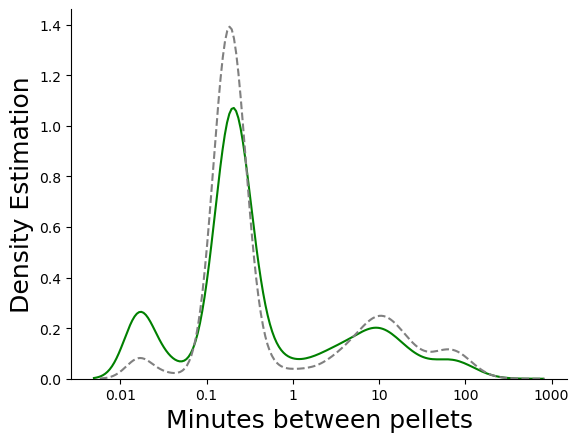

In [94]:
def interpellet_interval_plot(data, ax=[], colors=[], fill=False, labels=[], linestyle="-", **kwargs):
    """
    FED3 Viz: Plot a histogram of interpellet intervals for multiple devices.
    Parameters
    ----------
    FEDs : list of FED3_File objects
        FED3 files (loaded by load.FED3_File)
    kde : bool
        Whether or not to include kernel density estimation, which plots
        probability density (rather than count) and includes a fit line (see
        seaborn.distplot)
    **kwargs :
        ax : matplotlib.axes.Axes
            Axes to plot on, a new Figure and Axes are
            created if not passed
        date_filter : array
            A two-element array of datetimes (start, end) used to filter
            the data
        **kwargs also allows FED3 Viz to pass all settings to all functions.
    Returns
    -------
    fig : matplotlib.figure.Figure
    """

    if ax == []:
        f, ax = plt.subplots()

    if len(colors) != len(data):
        colors = ["grey"] * len(data)
    print(colors)

    if len(labels) != len(data):
        labels = [str(n) for n in range(len(data))]

    for idx, group in enumerate(data):

        y = tp.flatten_list(group)
        y = [np.log10(val*60) for val in y if val > 0]
            
        sns.kdeplot(y, ax=ax,
                    color=colors[idx],
                    fill=fill,
                    label=labels[idx],
                    linestyle=linestyle)

    ax.set_ylabel('Density Estimation',fontsize = 18)
    ax.set_xlabel('Minutes between pellets',fontsize = 18)

    ax.set_xticks(range(-2,4))
    ax.set_xticklabels([10**num for num in range(-2,4)])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}

IPIs_m_nrpr_gr = get_data_fields(mice, ["grain_ipi"], nrpr_male_selector)
IPIs_m_nrpr_nr = get_data_fields(mice, ["nr_ipi"], nrpr_male_selector)

IPIs_m_prnr_pr = get_data_fields(mice, ["grain_ipi"], prnr_male_selector)
IPIs_m_prnr_nr = get_data_fields(mice, ["grain_ipi"], prnr_male_selector)

f, ax = plt.subplots()

interpellet_interval_plot([IPIs_m_nrpr_gr],
                           colors=["green"],
                           linestyle="-",
                           ax=ax)

interpellet_interval_plot([IPIs_m_nrpr_nr],
                           colors=["grey"],
                           linestyle="--",
                           ax=ax)


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
['black']


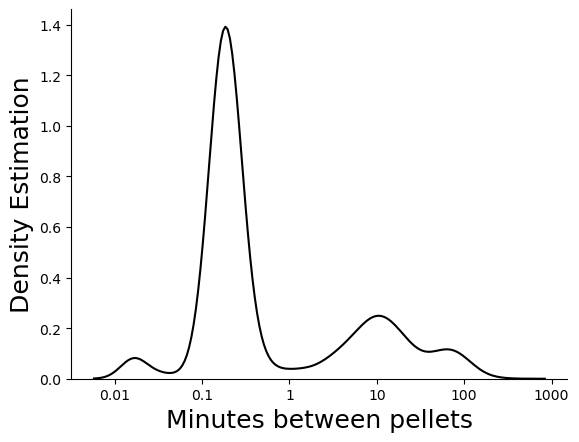

In [97]:
def interpellet_interval_plot(data, ax=[], colors=[], fill=False, labels=[], linestyle="-", **kwargs):
    """
    FED3 Viz: Plot a histogram of interpellet intervals for multiple devices.
    Parameters
    ----------
    FEDs : list of FED3_File objects
        FED3 files (loaded by load.FED3_File)
    kde : bool
        Whether or not to include kernel density estimation, which plots
        probability density (rather than count) and includes a fit line (see
        seaborn.distplot)
    **kwargs :
        ax : matplotlib.axes.Axes
            Axes to plot on, a new Figure and Axes are
            created if not passed
        date_filter : array
            A two-element array of datetimes (start, end) used to filter
            the data
        **kwargs also allows FED3 Viz to pass all settings to all functions.
    Returns
    -------
    fig : matplotlib.figure.Figure
    """

    if ax == []:
        f, ax = plt.subplots()

    if len(colors) != len(data):
        colors = ["grey"] * len(data)
    print(colors)

    if len(labels) != len(data):
        labels = [str(n) for n in range(len(data))]

    for idx, group in enumerate(data):

        y = tp.flatten_list(group)
        y = [np.log10(val*60) for val in y if val > 0]
            
        sns.kdeplot(y, ax=ax,
                    color=colors[idx],
                    fill=fill,
                    label=labels[idx],
                    linestyle=linestyle)

    ax.set_ylabel('Density Estimation',fontsize = 18)
    ax.set_xlabel('Minutes between pellets',fontsize = 18)

    ax.set_xticks(range(-2,4))
    ax.set_xticklabels([10**num for num in range(-2,4)])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}

IPIs_m_nrpr_gr = get_data_fields(mice, ["grain_ipi"], nrpr_male_selector)
IPIs_m_nrpr_nr = get_data_fields(mice, ["nr_ipi"], nrpr_male_selector)

IPIs_m_prnr_pr = get_data_fields(mice, ["grain_ipi"], prnr_male_selector)
IPIs_m_prnr_nr = get_data_fields(mice, ["grain_ipi"], prnr_male_selector)

f, ax = plt.subplots()

interpellet_interval_plot([IPIs_m_nrpr_nr],
                           colors=["black"],
                           linestyle="-",
                           ax=ax)

# interpellet_interval_plot([IPIs_m_nrpr_nr],
#                            colors=["grey"],
#                            linestyle="--",
#                            ax=ax)


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
['green']
['grey']


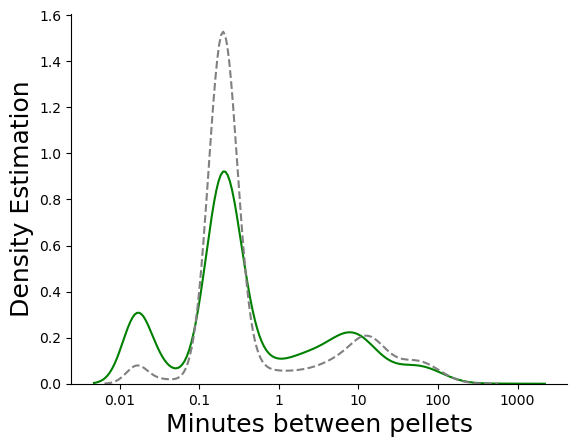

In [80]:
def interpellet_interval_plot(data, ax=[], colors=[], fill=False, labels=[], linestyle="-", **kwargs):
    """
    FED3 Viz: Plot a histogram of interpellet intervals for multiple devices.
    Parameters
    ----------
    FEDs : list of FED3_File objects
        FED3 files (loaded by load.FED3_File)
    kde : bool
        Whether or not to include kernel density estimation, which plots
        probability density (rather than count) and includes a fit line (see
        seaborn.distplot)
    **kwargs :
        ax : matplotlib.axes.Axes
            Axes to plot on, a new Figure and Axes are
            created if not passed
        date_filter : array
            A two-element array of datetimes (start, end) used to filter
            the data
        **kwargs also allows FED3 Viz to pass all settings to all functions.
    Returns
    -------
    fig : matplotlib.figure.Figure
    """

    if ax == []:
        f, ax = plt.subplots()

    if len(colors) != len(data):
        colors = ["grey"] * len(data)
    print(colors)

    if len(labels) != len(data):
        labels = [str(n) for n in range(len(data))]

    for idx, group in enumerate(data):

        y = tp.flatten_list(group)
        y = [np.log10(val*60) for val in y if val > 0]
            
        sns.kdeplot(y, ax=ax,
                    color=colors[idx],
                    fill=fill,
                    label=labels[idx],
                    linestyle=linestyle)

    ax.set_ylabel('Density Estimation',fontsize = 18)
    ax.set_xlabel('Minutes between pellets',fontsize = 18)

    ax.set_xticks(range(-2,4))
    ax.set_xticklabels([10**num for num in range(-2,4)])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}

IPIs_m_nrpr_gr = get_data_fields(mice, ["grain_ipi"], prnr_male_selector)
IPIs_m_nrpr_nr = get_data_fields(mice, ["nr_ipi"], prnr_male_selector)

IPIs_m_prnr_pr = get_data_fields(mice, ["grain_ipi"], prnr_male_selector)
IPIs_m_prnr_nr = get_data_fields(mice, ["grain_ipi"], prnr_male_selector)

f, ax = plt.subplots()

interpellet_interval_plot([IPIs_m_nrpr_gr],
                           colors=["green"],
                           linestyle="-",
                           ax=ax)

interpellet_interval_plot([IPIs_m_nrpr_nr],
                           colors=["grey"],
                           linestyle="--",
                           ax=ax)


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
5 items in output dictionary


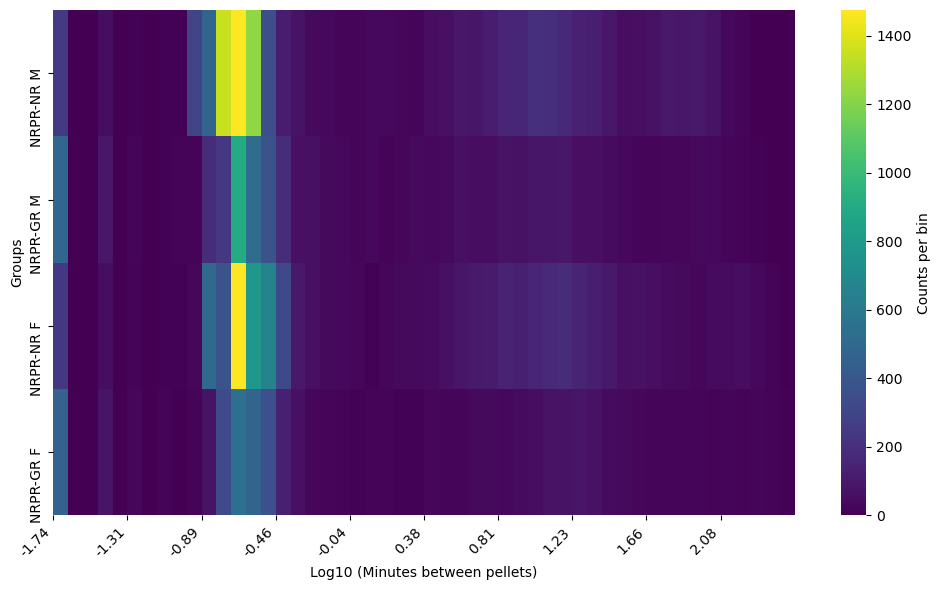

In [116]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def interpellet_interval_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], bins=50, tick_step=5, **kwargs):
    """
    FED3 Viz: Create a heatmap of inter-pellet intervals for four groups, with X-axis binned.

    Parameters
    ----------
    data1 : list
        List contains IPI data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains IPI data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains IPI data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains IPI data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    bins : int, optional
        Number of bins for grouping IPIs on the X-axis, by default 50.
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 5.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """

    if ax is None:
        fig, ax = plt.subplots()

    # Flatten and log-transform the data for all groups
    flattened1 = tp.flatten_list(data1)
    log_transformed1 = [np.log10(val * 60) for val in flattened1 if val > 0]

    flattened2 = tp.flatten_list(data2)
    log_transformed2 = [np.log10(val * 60) for val in flattened2 if val > 0]
    
    flattened3 = tp.flatten_list(data3)
    log_transformed3 = [np.log10(val * 60) for val in flattened3 if val > 0]
    
    flattened4 = tp.flatten_list(data4)
    log_transformed4 = [np.log10(val * 60) for val in flattened4 if val > 0]

    # Bin the data for all groups
    hist1, bin_edges = np.histogram(log_transformed1, bins=bins)
    hist2, _ = np.histogram(log_transformed2, bins=bins)
    hist3, _ = np.histogram(log_transformed3, bins=bins)
    hist4, _ = np.histogram(log_transformed4, bins=bins)

    # Create a 2D array from the histogram data, stacking the four groups
    data_matrix = np.array([hist1, hist2, hist3, hist4])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Counts per bin'}, **kwargs)

    # Set labels
    ax.set_yticks([0.5, 1.5, 2.5, 3.5])
    ax.set_yticklabels(labels)
    ax.set_xlabel('Log10 (Minutes between pellets)')
    ax.set_ylabel('Groups')

    # Set X-axis labels as bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Only show every nth tick to avoid label overlap
    ax.set_xticks(np.arange(0, len(bin_centers), tick_step))
    ax.set_xticklabels([f"{center:.2f}" for center in bin_centers[::tick_step]], rotation=45, ha='right')

    # Adjust the plot to prevent label overlapping
    plt.tight_layout()

    return ax

# Fetching the data for the four groups
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

IPIs_m_nrpr_nr = get_data_fields(mice, ["nr_ipi"], nrpr_male_selector)
IPIs_m_prnr_nr = get_data_fields(mice, ["grain_ipi"], nrpr_male_selector)
IPIs_f_nrpr_nr = get_data_fields(mice, ["nr_ipi"], nrpr_female_selector)
IPIs_f_prnr_nr = get_data_fields(mice, ["grain_ipi"], nrpr_female_selector)

# Plotting the heatmap with all four groups on the same plot
fig, ax = plt.subplots(figsize=(10, 6))

interpellet_interval_heatmap(IPIs_m_nrpr_nr, IPIs_m_prnr_nr, IPIs_f_nrpr_nr, IPIs_f_prnr_nr, ax=ax, 
                             labels=["NRPR-NR M", "NRPR-GR M", "NRPR-NR F", "NRPR-GR F"], 
                             bins=50, tick_step=5)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary


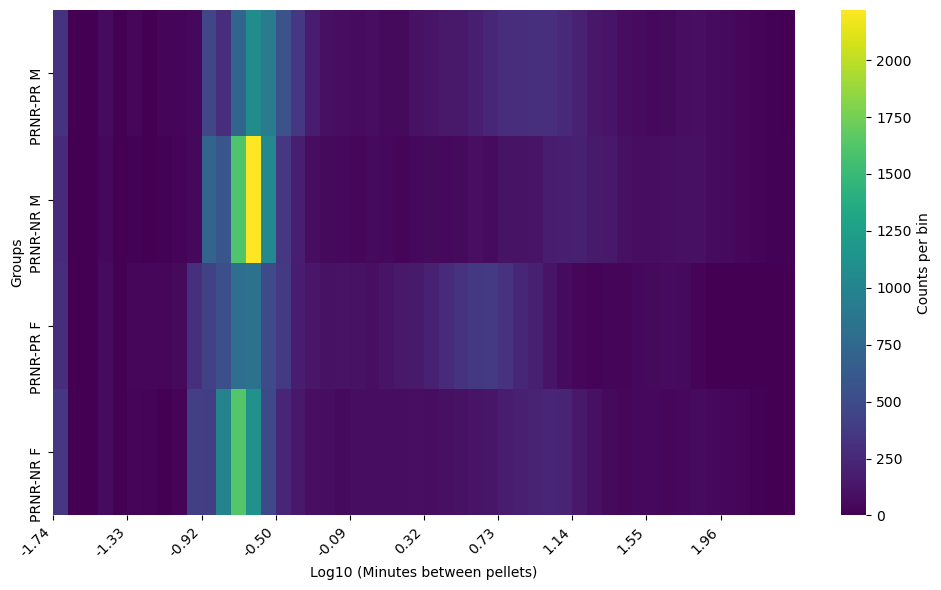

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def interpellet_interval_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], bins=50, tick_step=5, **kwargs):
    """
    FED3 Viz: Create a heatmap of inter-pellet intervals for four groups, with X-axis binned.

    Parameters
    ----------
    data1 : list
        List contains IPI data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains IPI data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains IPI data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains IPI data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    bins : int, optional
        Number of bins for grouping IPIs on the X-axis, by default 50.
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 5.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """

    if ax is None:
        fig, ax = plt.subplots()

    # Flatten and log-transform the data for all groups
    flattened1 = tp.flatten_list(data1)
    log_transformed1 = [np.log10(val * 60) for val in flattened1 if val > 0]

    flattened2 = tp.flatten_list(data2)
    log_transformed2 = [np.log10(val * 60) for val in flattened2 if val > 0]
    
    flattened3 = tp.flatten_list(data3)
    log_transformed3 = [np.log10(val * 60) for val in flattened3 if val > 0]
    
    flattened4 = tp.flatten_list(data4)
    log_transformed4 = [np.log10(val * 60) for val in flattened4 if val > 0]

    # Bin the data for all groups
    hist1, bin_edges = np.histogram(log_transformed1, bins=bins)
    hist2, _ = np.histogram(log_transformed2, bins=bins)
    hist3, _ = np.histogram(log_transformed3, bins=bins)
    hist4, _ = np.histogram(log_transformed4, bins=bins)

    # Create a 2D array from the histogram data, stacking the four groups
    data_matrix = np.array([hist1, hist2, hist3, hist4])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Counts per bin'}, **kwargs)

    # Set labels
    ax.set_yticks([0.5, 1.5, 2.5, 3.5])
    ax.set_yticklabels(labels)
    ax.set_xlabel('Log10 (Minutes between pellets)')
    ax.set_ylabel('Groups')

    # Set X-axis labels as bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Only show every nth tick to avoid label overlap
    ax.set_xticks(np.arange(0, len(bin_centers), tick_step))
    ax.set_xticklabels([f"{center:.2f}" for center in bin_centers[::tick_step]], rotation=45, ha='right')

    # Adjust the plot to prevent label overlapping
    plt.tight_layout()

    return ax

# Fetching the data for the four groups
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

IPIs_m_nrpr_nr = get_data_fields(mice, ["pr_ipi"], prnr_male_selector)
IPIs_m_prnr_nr = get_data_fields(mice, ["nr_ipi"], prnr_male_selector)
IPIs_f_nrpr_nr = get_data_fields(mice, ["pr_ipi"], prnr_female_selector)
IPIs_f_prnr_nr = get_data_fields(mice, ["nr_ipi"], prnr_female_selector)

# Plotting the heatmap with all four groups on the same plot
fig, ax = plt.subplots(figsize=(10, 6))

interpellet_interval_heatmap(IPIs_m_nrpr_nr, IPIs_m_prnr_nr, IPIs_f_nrpr_nr, IPIs_f_prnr_nr, ax=ax, 
                             labels=["PRNR-PR M", "PRNR-NR M", "PRNR-PR F", "PRNR-NR F"], 
                             bins=50, tick_step=5)

plt.show()


6 items in output dictionary
pr_ipi is not a key in selected dictionary
6 items in output dictionary
nr_ipi is not a key in selected dictionary
6 items in output dictionary
pr_ipi is not a key in selected dictionary
6 items in output dictionary
nr_ipi is not a key in selected dictionary
['grey', 'deepskyblue']
Cannot flatten list. Maybe is in the wrong format. Returning empty list.
Cannot flatten list. Maybe is in the wrong format. Returning empty list.
['grey', 'deepskyblue']
Cannot flatten list. Maybe is in the wrong format. Returning empty list.
Cannot flatten list. Maybe is in the wrong format. Returning empty list.


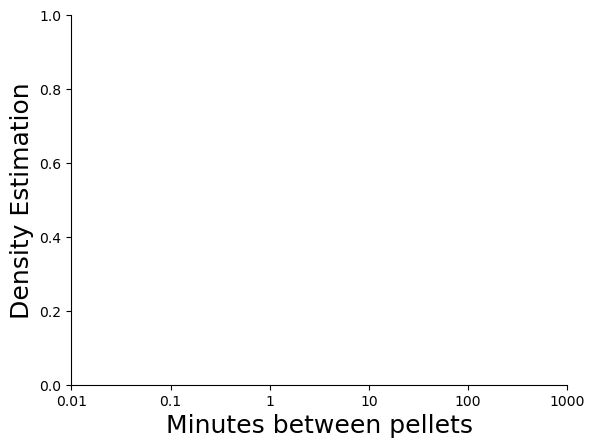

In [91]:
def interpellet_interval_plot(data, ax=[], colors=[], fill=False, labels=[], linestyle="-", **kwargs):
    """
    FED3 Viz: Plot a histogram of interpellet intervals for multiple devices.
    Parameters
    ----------
    FEDs : list of FED3_File objects
        FED3 files (loaded by load.FED3_File)
    kde : bool
        Whether or not to include kernel density estimation, which plots
        probability density (rather than count) and includes a fit line (see
        seaborn.distplot)
    **kwargs :
        ax : matplotlib.axes.Axes
            Axes to plot on, a new Figure and Axes are
            created if not passed
        date_filter : array
            A two-element array of datetimes (start, end) used to filter
            the data
        **kwargs also allows FED3 Viz to pass all settings to all functions.
    Returns
    -------
    fig : matplotlib.figure.Figure
    """

    if ax == []:
        f, ax = plt.subplots()

    if len(colors) != len(data):
        colors = ["grey"] * len(data)
    print(colors)

    if len(labels) != len(data):
        labels = [str(n) for n in range(len(data))]

    for idx, group in enumerate(data):

        y = tp.flatten_list(group)
        y = [np.log10(val*60) for val in y if val > 0]
            
        sns.kdeplot(y, ax=ax,
                    color=colors[idx],
                    fill=fill,
                    label=labels[idx],
                    linestyle=linestyle)

    ax.set_ylabel('Density Estimation',fontsize = 18)
    ax.set_xlabel('Minutes between pellets',fontsize = 18)

    ax.set_xticks(range(-2,4))
    ax.set_xticklabels([10**num for num in range(-2,4)])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}

IPIs_m_nrpr_pr = get_data_fields(mice, ["pr_ipi"], nrpr_male_selector)
IPIs_m_nrpr_nr = get_data_fields(mice, ["nr_ipi"], nrpr_male_selector)

IPIs_m_prnr_pr = get_data_fields(mice, ["pr_ipi"], prnr_male_selector)
IPIs_m_prnr_nr = get_data_fields(mice, ["nr_ipi"], prnr_male_selector)

f, ax = plt.subplots()

interpellet_interval_plot([IPIs_m_nrpr_nr, IPIs_m_nrpr_pr],
                           colors=["grey", "deepskyblue"],
                           linestyle="-",
                           ax=ax)

interpellet_interval_plot([IPIs_m_prnr_nr, IPIs_m_prnr_pr],
                           colors=["grey", "deepskyblue"],
                           linestyle="--",
                           ax=ax)


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
['grey', 'deepskyblue']
['grey', 'deepskyblue']


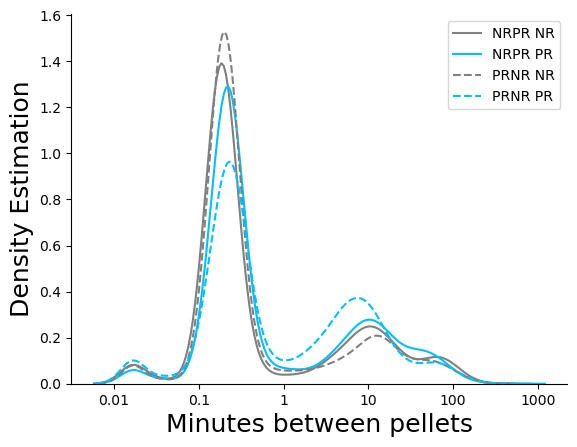

In [61]:
def interpellet_interval_plot(data, ax=[], colors=[], fill=False, labels=[], linestyle="-", **kwargs):
    """
    FED3 Viz: Plot a histogram of interpellet intervals for multiple devices.
    Parameters
    ----------
    FEDs : list of FED3_File objects
        FED3 files (loaded by load.FED3_File)
    kde : bool
        Whether or not to include kernel density estimation, which plots
        probability density (rather than count) and includes a fit line (see
        seaborn.distplot)
    **kwargs :
        ax : matplotlib.axes.Axes
            Axes to plot on, a new Figure and Axes are
            created if not passed
        date_filter : array
            A two-element array of datetimes (start, end) used to filter
            the data
        **kwargs also allows FED3 Viz to pass all settings to all functions.
    Returns
    -------
    fig : matplotlib.figure.Figure
    """

    if ax == []:
        f, ax = plt.subplots()

    if len(colors) != len(data):
        colors = ["grey"] * len(data)
    print(colors)

    if len(labels) != len(data):
        labels = [str(n) for n in range(len(data))]

    for idx, group in enumerate(data):
        y = tp.flatten_list(group)
        y = [np.log10(val * 60) for val in y if val > 0]

        sns.kdeplot(y, ax=ax,
                    color=colors[idx],
                    fill=fill,
                    label=labels[idx],  # Label for legend
                    linestyle=linestyle)

    ax.set_ylabel('Density Estimation', fontsize=18)
    ax.set_xlabel('Minutes between pellets', fontsize=18)

    ax.set_xticks(range(-2, 4))
    ax.set_xticklabels([10**num for num in range(-2, 4)])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Add the legend
    ax.legend()

nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}

IPIs_m_nrpr_pr = get_data_fields(mice, ["pr_ipi"], nrpr_male_selector)
IPIs_m_nrpr_nr = get_data_fields(mice, ["nr_ipi"], nrpr_male_selector)

IPIs_m_prnr_pr = get_data_fields(mice, ["pr_ipi"], prnr_male_selector)
IPIs_m_prnr_nr = get_data_fields(mice, ["nr_ipi"], prnr_male_selector)

f, ax = plt.subplots()

# First plot with solid lines
interpellet_interval_plot([IPIs_m_nrpr_nr, IPIs_m_nrpr_pr],
                          colors=["grey", "deepskyblue"],
                          linestyle="-",
                          labels=["NRPR NR", "NRPR PR"],  # Add labels for legend
                          ax=ax)

# Second plot with dashed lines
interpellet_interval_plot([IPIs_m_prnr_nr, IPIs_m_prnr_pr],
                          colors=["grey", "deepskyblue"],
                          linestyle="--",
                          labels=["PRNR NR", "PRNR PR"],  # Add labels for legend
                          ax=ax)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
['grey', 'deepskyblue']
['grey', 'deepskyblue']


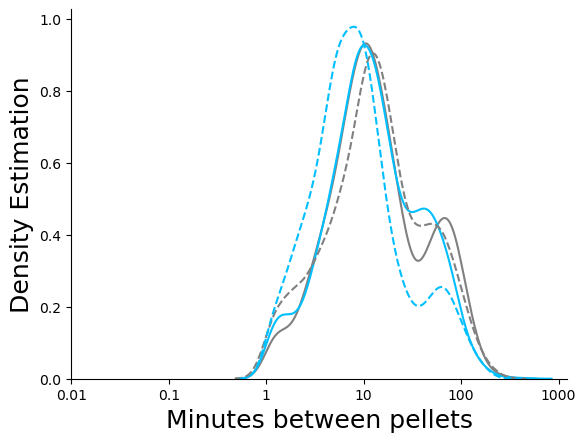

In [37]:
def interpellet_interval_plot(data, ax=[], colors=[], fill=False, labels=[], linestyle="-", **kwargs):
    """
    FED3 Viz: Plot a histogram of interpellet intervals for multiple devices.
    Parameters
    ----------
    FEDs : list of FED3_File objects
        FED3 files (loaded by load.FED3_File)
    kde : bool
        Whether or not to include kernel density estimation, which plots
        probability density (rather than count) and includes a fit line (see
        seaborn.distplot)
    **kwargs :
        ax : matplotlib.axes.Axes
            Axes to plot on, a new Figure and Axes are
            created if not passed
        date_filter : array
            A two-element array of datetimes (start, end) used to filter
            the data
        **kwargs also allows FED3 Viz to pass all settings to all functions.
    Returns
    -------
    fig : matplotlib.figure.Figure
    """

    if ax == []:
        f, ax = plt.subplots()

    if len(colors) != len(data):
        colors = ["grey"] * len(data)
    print(colors)

    if len(labels) != len(data):
        labels = [str(n) for n in range(len(data))]

    for idx, group in enumerate(data):

        y = tp.flatten_list(group)
        y = [np.log10(val*60) for val in y if val > 0]
            
        sns.kdeplot(y, ax=ax,
                    color=colors[idx],
                    fill=fill,
                    label=labels[idx],
                    linestyle=linestyle)

    ax.set_ylabel('Density Estimation',fontsize = 18)
    ax.set_xlabel('Minutes between pellets',fontsize = 18)

    ax.set_xticks(range(-2,4))
    ax.set_xticklabels([10**num for num in range(-2,4)])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}

IPIs_m_nrpr_pr = get_data_fields(mice, ["pr_imi"], nrpr_male_selector)
IPIs_m_nrpr_nr = get_data_fields(mice, ["nr_imi"], nrpr_male_selector)

IPIs_m_prnr_pr = get_data_fields(mice, ["pr_imi"], prnr_male_selector)
IPIs_m_prnr_nr = get_data_fields(mice, ["nr_imi"], prnr_male_selector)

f, ax = plt.subplots()

interpellet_interval_plot([IPIs_m_nrpr_nr, IPIs_m_nrpr_pr],
                           colors=["grey", "deepskyblue"],
                           linestyle="-",
                           ax=ax)

interpellet_interval_plot([IPIs_m_prnr_nr, IPIs_m_prnr_pr],
                           colors=["grey", "deepskyblue"],
                           linestyle="--",
                           ax=ax)

6 items in output dictionary


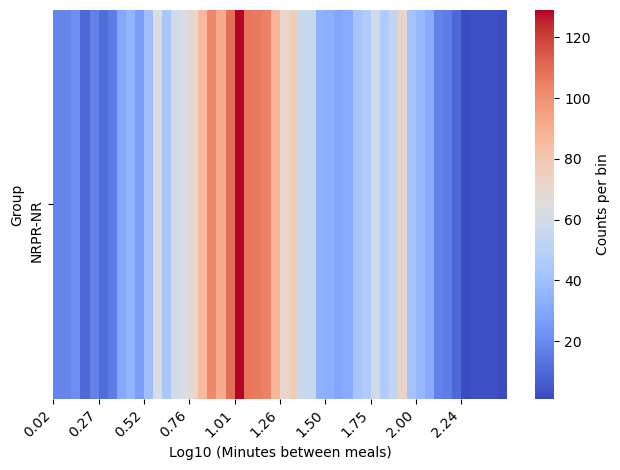

In [48]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def intermeal_interval_heatmap(data, ax=None, label="NRPR-NR", bins=50, tick_step=5, **kwargs):
    """
    FED3 Viz: Create a heatmap of intermeal intervals for a single group, with X-axis binned.

    Parameters
    ----------
    data : list
        List contains IMI data for a group (e.g., NRPR-NR).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    label : str, optional
        Label for the dataset (group), by default "NRPR-NR"
    bins : int, optional
        Number of bins for grouping IMIs on the X-axis, by default 50.
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 5.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """

    if ax is None:
        fig, ax = plt.subplots()

    # Flatten and log-transform the data
    flattened = tp.flatten_list(data)
    log_transformed = [np.log10(val * 60) for val in flattened if val > 0]
    
    # Bin the data into specified number of bins
    hist, bin_edges = np.histogram(log_transformed, bins=bins)

    # Create a 2D array from the histogram data
    data_matrix = np.array([hist])  # Single-row matrix

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="coolwarm", cbar_kws={'label': 'Counts per bin'}, **kwargs)

    # Set labels
    ax.set_yticks([0.5])
    ax.set_yticklabels([label])
    ax.set_xlabel('Log10 (Minutes between meals)')
    ax.set_ylabel('Group')

    # Set X-axis labels as bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Only show every nth tick to avoid label overlap
    ax.set_xticks(np.arange(0, len(bin_centers), tick_step))
    ax.set_xticklabels([f"{center:.2f}" for center in bin_centers[::tick_step]], rotation=45, ha='right')

    # Adjust the plot to prevent label overlapping
    plt.tight_layout()

    return ax


# Fetching the data for the NRPR_NR group for IMI
nrpr_male_selector = {"order": 1, "sex": "M"}
IMIs_m_nrpr_nr = get_data_fields(mice, ["nr_imi"], nrpr_male_selector)

# Plotting the heatmap for NRPR_NR IMI
fig, ax = plt.subplots()
intermeal_interval_heatmap(IMIs_m_nrpr_nr, ax=ax, label="NRPR-NR", bins=50, tick_step=5)
plt.show()


6 items in output dictionary
6 items in output dictionary


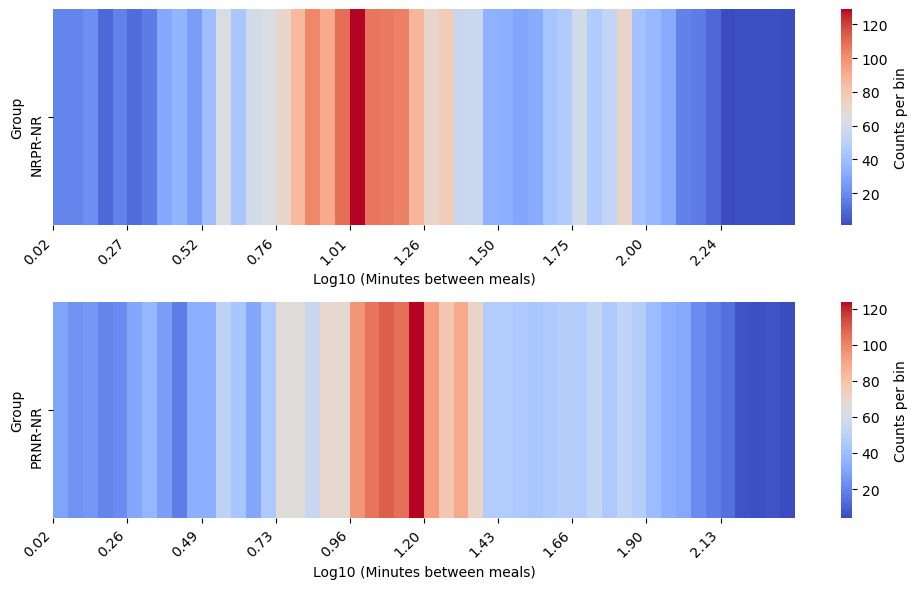

In [49]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def intermeal_interval_heatmap(data, ax=None, label="NRPR-NR", bins=50, tick_step=5, **kwargs):
    """
    FED3 Viz: Create a heatmap of intermeal intervals for a single group, with X-axis binned.

    Parameters
    ----------
    data : list
        List contains IMI data for a group (e.g., NRPR-NR).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    label : str, optional
        Label for the dataset (group), by default "NRPR-NR"
    bins : int, optional
        Number of bins for grouping IMIs on the X-axis, by default 50.
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 5.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """

    if ax is None:
        fig, ax = plt.subplots()

    # Flatten and log-transform the data
    flattened = tp.flatten_list(data)
    log_transformed = [np.log10(val * 60) for val in flattened if val > 0]
    
    # Bin the data into specified number of bins
    hist, bin_edges = np.histogram(log_transformed, bins=bins)

    # Create a 2D array from the histogram data
    data_matrix = np.array([hist])  # Single-row matrix

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="coolwarm", cbar_kws={'label': 'Counts per bin'}, **kwargs)

    # Set labels
    ax.set_yticks([0.5])
    ax.set_yticklabels([label])
    ax.set_xlabel('Log10 (Minutes between meals)')
    ax.set_ylabel('Group')

    # Set X-axis labels as bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Only show every nth tick to avoid label overlap
    ax.set_xticks(np.arange(0, len(bin_centers), tick_step))
    ax.set_xticklabels([f"{center:.2f}" for center in bin_centers[::tick_step]], rotation=45, ha='right')

    # Adjust the plot to prevent label overlapping
    plt.tight_layout()

    return ax


# Fetching the data for the NRPR_NR group and the PRNR_NR group for IMI
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}

IMIs_m_nrpr_nr = get_data_fields(mice, ["nr_imi"], nrpr_male_selector)
IMIs_m_prnr_nr = get_data_fields(mice, ["nr_imi"], prnr_male_selector)

# Creating subplots for both groups
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Plotting the heatmap for NRPR_NR IMI
intermeal_interval_heatmap(IMIs_m_nrpr_nr, ax=axs[0], label="NRPR-NR", bins=50, tick_step=5)

# Plotting the heatmap for PRNR_NR IMI
intermeal_interval_heatmap(IMIs_m_prnr_nr, ax=axs[1], label="PRNR-NR", bins=50, tick_step=5)

plt.show()


6 items in output dictionary
6 items in output dictionary


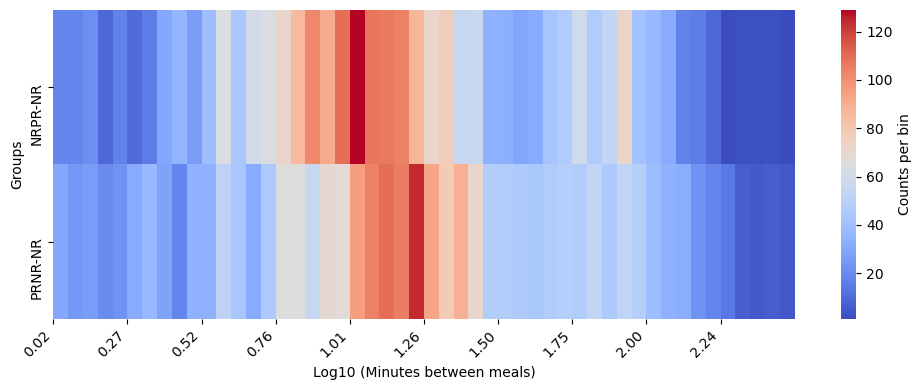

In [50]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def intermeal_interval_heatmap(data1, data2, ax=None, labels=["NRPR-NR", "PRNR-NR"], bins=50, tick_step=5, **kwargs):
    """
    FED3 Viz: Create a heatmap of intermeal intervals for two groups, with X-axis binned.

    Parameters
    ----------
    data1 : list
        List contains IMI data for group 1 (e.g., NRPR-NR).
    data2 : list
        List contains IMI data for group 2 (e.g., PRNR-NR).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR", "PRNR-NR"].
    bins : int, optional
        Number of bins for grouping IMIs on the X-axis, by default 50.
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 5.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """

    if ax is None:
        fig, ax = plt.subplots()

    # Flatten and log-transform the data for both groups
    flattened1 = tp.flatten_list(data1)
    log_transformed1 = [np.log10(val * 60) for val in flattened1 if val > 0]

    flattened2 = tp.flatten_list(data2)
    log_transformed2 = [np.log10(val * 60) for val in flattened2 if val > 0]
    
    # Bin the data for both groups
    hist1, bin_edges = np.histogram(log_transformed1, bins=bins)
    hist2, _ = np.histogram(log_transformed2, bins=bins)

    # Create a 2D array from the histogram data, stacking the two groups
    data_matrix = np.array([hist1, hist2])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="coolwarm", cbar_kws={'label': 'Counts per bin'}, **kwargs)

    # Set labels
    ax.set_yticks([0.5, 1.5])
    ax.set_yticklabels(labels)
    ax.set_xlabel('Log10 (Minutes between meals)')
    ax.set_ylabel('Groups')

    # Set X-axis labels as bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Only show every nth tick to avoid label overlap
    ax.set_xticks(np.arange(0, len(bin_centers), tick_step))
    ax.set_xticklabels([f"{center:.2f}" for center in bin_centers[::tick_step]], rotation=45, ha='right')

    # Adjust the plot to prevent label overlapping
    plt.tight_layout()

    return ax

# Fetching the data for the NRPR_NR group and the PRNR_NR group for IMI
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}

IMIs_m_nrpr_nr = get_data_fields(mice, ["nr_imi"], nrpr_male_selector)
IMIs_m_prnr_nr = get_data_fields(mice, ["nr_imi"], prnr_male_selector)

# Plotting the heatmap with both groups on the same plot
fig, ax = plt.subplots(figsize=(10, 4))

intermeal_interval_heatmap(IMIs_m_nrpr_nr, IMIs_m_prnr_nr, ax=ax, labels=["NRPR-NR", "PRNR-NR"], bins=50, tick_step=5)

plt.show()


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


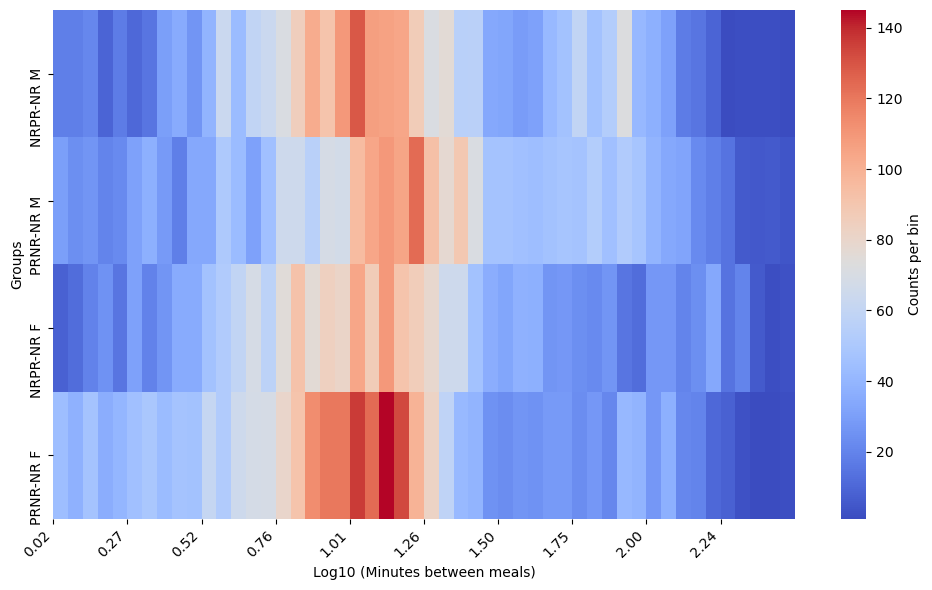

In [54]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def intermeal_interval_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], bins=50, tick_step=5, **kwargs):
    """
    FED3 Viz: Create a heatmap of intermeal intervals for four groups, with X-axis binned.

    Parameters
    ----------
    data1 : list
        List contains IMI data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains IMI data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains IMI data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains IMI data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    bins : int, optional
        Number of bins for grouping IMIs on the X-axis, by default 50.
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 5.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """

    if ax is None:
        fig, ax = plt.subplots()

    # Flatten and log-transform the data for all groups
    flattened1 = tp.flatten_list(data1)
    log_transformed1 = [np.log10(val * 60) for val in flattened1 if val > 0]

    flattened2 = tp.flatten_list(data2)
    log_transformed2 = [np.log10(val * 60) for val in flattened2 if val > 0]
    
    flattened3 = tp.flatten_list(data3)
    log_transformed3 = [np.log10(val * 60) for val in flattened3 if val > 0]
    
    flattened4 = tp.flatten_list(data4)
    log_transformed4 = [np.log10(val * 60) for val in flattened4 if val > 0]

    # Bin the data for all groups
    hist1, bin_edges = np.histogram(log_transformed1, bins=bins)
    hist2, _ = np.histogram(log_transformed2, bins=bins)
    hist3, _ = np.histogram(log_transformed3, bins=bins)
    hist4, _ = np.histogram(log_transformed4, bins=bins)

    # Create a 2D array from the histogram data, stacking the four groups
    data_matrix = np.array([hist1, hist2, hist3, hist4])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="coolwarm", cbar_kws={'label': 'Counts per bin'}, **kwargs)

    # Set labels
    ax.set_yticks([0.5, 1.5, 2.5, 3.5])
    ax.set_yticklabels(labels)
    ax.set_xlabel('Log10 (Minutes between meals)')
    ax.set_ylabel('Groups')

    # Set X-axis labels as bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Only show every nth tick to avoid label overlap
    ax.set_xticks(np.arange(0, len(bin_centers), tick_step))
    ax.set_xticklabels([f"{center:.2f}" for center in bin_centers[::tick_step]], rotation=45, ha='right')

    # Adjust the plot to prevent label overlapping
    plt.tight_layout()

    return ax

# Fetching the data for the four groups
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

IMIs_m_nrpr_nr = get_data_fields(mice, ["nr_imi"], nrpr_male_selector)
IMIs_m_prnr_nr = get_data_fields(mice, ["nr_imi"], prnr_male_selector)
IMIs_f_nrpr_nr = get_data_fields(mice, ["nr_imi"], nrpr_female_selector)
IMIs_f_prnr_nr = get_data_fields(mice, ["nr_imi"], prnr_female_selector)

# Plotting the heatmap with all four groups on the same plot
fig, ax = plt.subplots(figsize=(10, 6))

intermeal_interval_heatmap(IMIs_m_nrpr_nr, IMIs_m_prnr_nr, IMIs_f_nrpr_nr, IMIs_f_prnr_nr, ax=ax, 
                           labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], 
                           bins=50, tick_step=5)

plt.show()


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


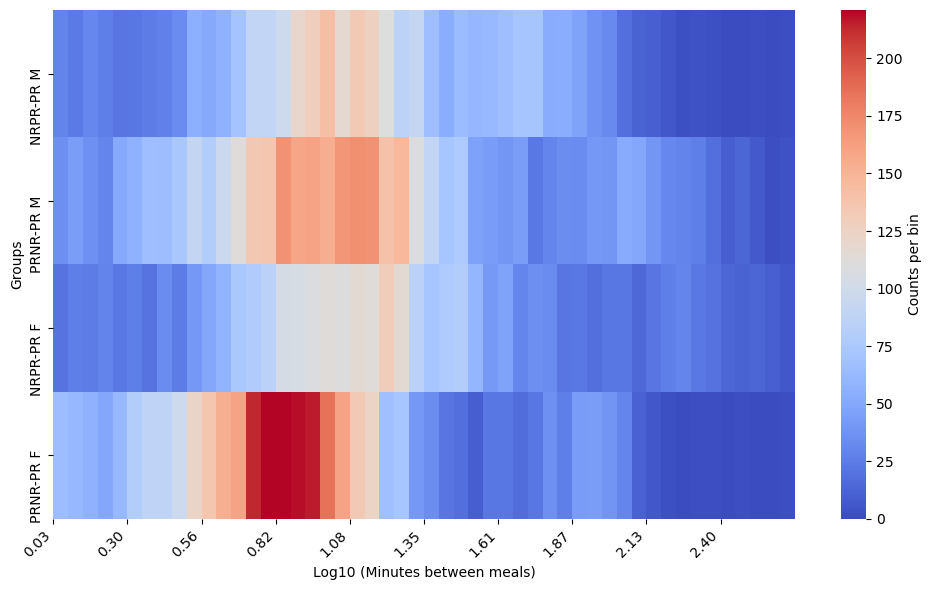

In [56]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def intermeal_interval_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], bins=50, tick_step=5, **kwargs):
    """
    FED3 Viz: Create a heatmap of intermeal intervals for four groups, with X-axis binned.

    Parameters
    ----------
    data1 : list
        List contains IMI data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains IMI data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains IMI data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains IMI data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    bins : int, optional
        Number of bins for grouping IMIs on the X-axis, by default 50.
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 5.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """

    if ax is None:
        fig, ax = plt.subplots()

    # Flatten and log-transform the data for all groups
    flattened1 = tp.flatten_list(data1)
    log_transformed1 = [np.log10(val * 60) for val in flattened1 if val > 0]

    flattened2 = tp.flatten_list(data2)
    log_transformed2 = [np.log10(val * 60) for val in flattened2 if val > 0]
    
    flattened3 = tp.flatten_list(data3)
    log_transformed3 = [np.log10(val * 60) for val in flattened3 if val > 0]
    
    flattened4 = tp.flatten_list(data4)
    log_transformed4 = [np.log10(val * 60) for val in flattened4 if val > 0]

    # Bin the data for all groups
    hist1, bin_edges = np.histogram(log_transformed1, bins=bins)
    hist2, _ = np.histogram(log_transformed2, bins=bins)
    hist3, _ = np.histogram(log_transformed3, bins=bins)
    hist4, _ = np.histogram(log_transformed4, bins=bins)

    # Create a 2D array from the histogram data, stacking the four groups
    data_matrix = np.array([hist1, hist2, hist3, hist4])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="coolwarm", cbar_kws={'label': 'Counts per bin'}, **kwargs)

    # Set labels
    ax.set_yticks([0.5, 1.5, 2.5, 3.5])
    ax.set_yticklabels(labels)
    ax.set_xlabel('Log10 (Minutes between meals)')
    ax.set_ylabel('Groups')

    # Set X-axis labels as bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Only show every nth tick to avoid label overlap
    ax.set_xticks(np.arange(0, len(bin_centers), tick_step))
    ax.set_xticklabels([f"{center:.2f}" for center in bin_centers[::tick_step]], rotation=45, ha='right')

    # Adjust the plot to prevent label overlapping
    plt.tight_layout()

    return ax

# Fetching the data for the four groups
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

IMIs_m_nrpr_nr = get_data_fields(mice, ["pr_imi"], nrpr_male_selector)
IMIs_m_prnr_nr = get_data_fields(mice, ["pr_imi"], prnr_male_selector)
IMIs_f_nrpr_nr = get_data_fields(mice, ["pr_imi"], nrpr_female_selector)
IMIs_f_prnr_nr = get_data_fields(mice, ["pr_imi"], prnr_female_selector)

# Plotting the heatmap with all four groups on the same plot
fig, ax = plt.subplots(figsize=(10, 6))

intermeal_interval_heatmap(IMIs_m_nrpr_nr, IMIs_m_prnr_nr, IMIs_f_nrpr_nr, IMIs_f_prnr_nr, ax=ax, 
                           labels=["NRPR-PR M", "PRNR-PR M", "NRPR-PR F", "PRNR-PR F"], 
                           bins=50, tick_step=5)

plt.show()


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


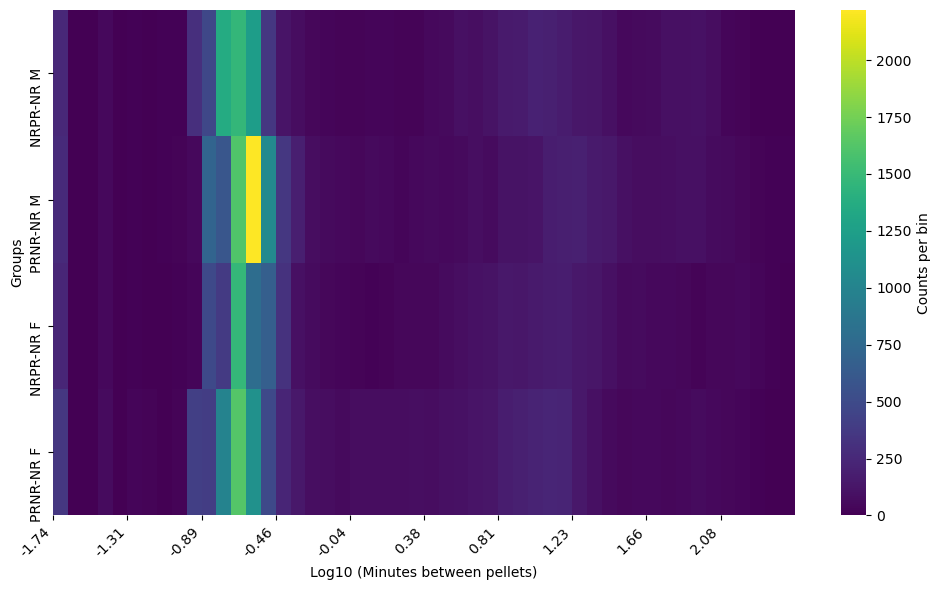

In [62]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def interpellet_interval_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], bins=50, tick_step=5, **kwargs):
    """
    FED3 Viz: Create a heatmap of inter-pellet intervals for four groups, with X-axis binned.

    Parameters
    ----------
    data1 : list
        List contains IPI data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains IPI data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains IPI data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains IPI data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    bins : int, optional
        Number of bins for grouping IPIs on the X-axis, by default 50.
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 5.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """

    if ax is None:
        fig, ax = plt.subplots()

    # Flatten and log-transform the data for all groups
    flattened1 = tp.flatten_list(data1)
    log_transformed1 = [np.log10(val * 60) for val in flattened1 if val > 0]

    flattened2 = tp.flatten_list(data2)
    log_transformed2 = [np.log10(val * 60) for val in flattened2 if val > 0]
    
    flattened3 = tp.flatten_list(data3)
    log_transformed3 = [np.log10(val * 60) for val in flattened3 if val > 0]
    
    flattened4 = tp.flatten_list(data4)
    log_transformed4 = [np.log10(val * 60) for val in flattened4 if val > 0]

    # Bin the data for all groups
    hist1, bin_edges = np.histogram(log_transformed1, bins=bins)
    hist2, _ = np.histogram(log_transformed2, bins=bins)
    hist3, _ = np.histogram(log_transformed3, bins=bins)
    hist4, _ = np.histogram(log_transformed4, bins=bins)

    # Create a 2D array from the histogram data, stacking the four groups
    data_matrix = np.array([hist1, hist2, hist3, hist4])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Counts per bin'}, **kwargs)

    # Set labels
    ax.set_yticks([0.5, 1.5, 2.5, 3.5])
    ax.set_yticklabels(labels)
    ax.set_xlabel('Log10 (Minutes between pellets)')
    ax.set_ylabel('Groups')

    # Set X-axis labels as bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Only show every nth tick to avoid label overlap
    ax.set_xticks(np.arange(0, len(bin_centers), tick_step))
    ax.set_xticklabels([f"{center:.2f}" for center in bin_centers[::tick_step]], rotation=45, ha='right')

    # Adjust the plot to prevent label overlapping
    plt.tight_layout()

    return ax

# Fetching the data for the four groups
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

IPIs_m_nrpr_nr = get_data_fields(mice, ["nr_ipi"], nrpr_male_selector)
IPIs_m_prnr_nr = get_data_fields(mice, ["nr_ipi"], prnr_male_selector)
IPIs_f_nrpr_nr = get_data_fields(mice, ["nr_ipi"], nrpr_female_selector)
IPIs_f_prnr_nr = get_data_fields(mice, ["nr_ipi"], prnr_female_selector)

# Plotting the heatmap with all four groups on the same plot
fig, ax = plt.subplots(figsize=(10, 6))

interpellet_interval_heatmap(IPIs_m_nrpr_nr, IPIs_m_prnr_nr, IPIs_f_nrpr_nr, IPIs_f_prnr_nr, ax=ax, 
                             labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], 
                             bins=50, tick_step=5)

plt.show()







What Happens in the cell above:
Histogram Bin Count: The heatmap is based on the distribution of inter-pellet intervals (IPI), which means you're taking the time between pellets for each mouse, transforming the data (log-transform), and then binning the data into groups (bins). Each bin represents a range of values for the log-transformed IPI data.

One Line Per Group: Since you're creating histograms (one for each group), the heatmap will have one row for each group. Each row represents the distribution of IPIs for that group across the binned log-transformed values (i.e., the counts of IPIs falling into each bin). The X-axis shows the log-transformed time between pellets, while the Y-axis represents different groups.

For example, the histogram might show how many IPIs for each group fall into a range like "log10(0.5-1 minute)" or "log10(2-3 minutes)." This results in one long line per group because we're looking at the distribution across time intervals, not the time-series data itself.
Binning: The X-axis bins represent time intervals (in minutes between pellets) that are log-transformed. You're showing how many IPIs fall into each time bin for each group.

Why the heatmap shows one long line per group:
In this heatmap, each voxel (cell) represents how many inter-pellet intervals (IPIs) fall into a particular bin (a time range) for each group.
Since you're binning the data, and each bin represents a specific range of time intervals, there’s only one row per group because you're visualizing the distribution of IPIs, not the raw IPI data across time.
The Y-axis corresponds to groups, and the X-axis corresponds to log10 of the IPI bins (interval between pellets).
Comparison to the Previous Heatmaps:
In your hourly meals heatmaps, each row represented a mouse's feeding behavior across hours, and multiple rows per group were shown.
In this IPI heatmap, you’re dealing with a distribution of intervals, so you have only one row per group because you are summarizing how many IPIs fall into each time bin, rather than plotting the data across hours/days.
To Summarize:
Each row in the current heatmap corresponds to a group (like "NRPR-NR M") and represents the frequency distribution of inter-pellet intervals (IPI) in log10 minutes.
Each cell in a row shows the number of intervals (IPIs) that fall into a specific time bin for that group.
Therefore, the heatmap has only one row per group because the data is summarized as a distribution across bins (time intervals), not as a time series.

In [58]:
mice["FEDXB01"].keys()

nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 


nrpr_m_mega_meals = get_data_fields(mice, ["nr_ipi"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_meals_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_snacks_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_meals_per_day"], prnr_female_selector)

6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


In [84]:
np.set_printoptions(threshold=np.inf)  # This sets the threshold to infinity, so the full array is printed
nrpr_m_mega_meals

[array([5.44444444e-02, 4.19444444e-02, 1.25777778e+00, 2.77777778e-04,
        8.33333333e-03, 6.38888889e-03, 5.83333333e-03, 6.38888889e-03,
        1.29388889e+00, 4.72222222e-03, 4.44444444e-03, 3.61111111e-03,
        4.72222222e-03, 3.88888889e-03, 3.88888889e-03, 1.28277778e+00,
        4.16666667e-03, 3.88888889e-03, 3.61111111e-03, 2.77777778e-04,
        6.94444444e-03, 6.66666667e-03, 1.99444444e-01, 3.61111111e-03,
        3.61111111e-03, 6.38888889e-03, 1.94083333e+00, 5.83333333e-03,
        2.77777778e-04, 4.44444444e-03, 4.16666667e-03, 4.72222222e-03,
        6.66666667e-03, 4.44444444e-03, 4.72222222e-03, 1.31805556e+00,
        3.88888889e-03, 4.44444444e-03, 8.33333333e-03, 4.44444444e-03,
        5.00000000e-03, 6.94444444e-03, 5.27777778e-03, 1.97222222e-02,
        1.75222222e+00, 3.61111111e-03, 4.16666667e-03, 4.16666667e-03,
        3.33333333e-03, 4.44444444e-03, 6.11111111e-03, 3.33333333e-02,
        3.61111111e-03, 5.00000000e-03, 6.30833333e-01, 3.611111

6 items in output dictionary
6 items in output dictionary


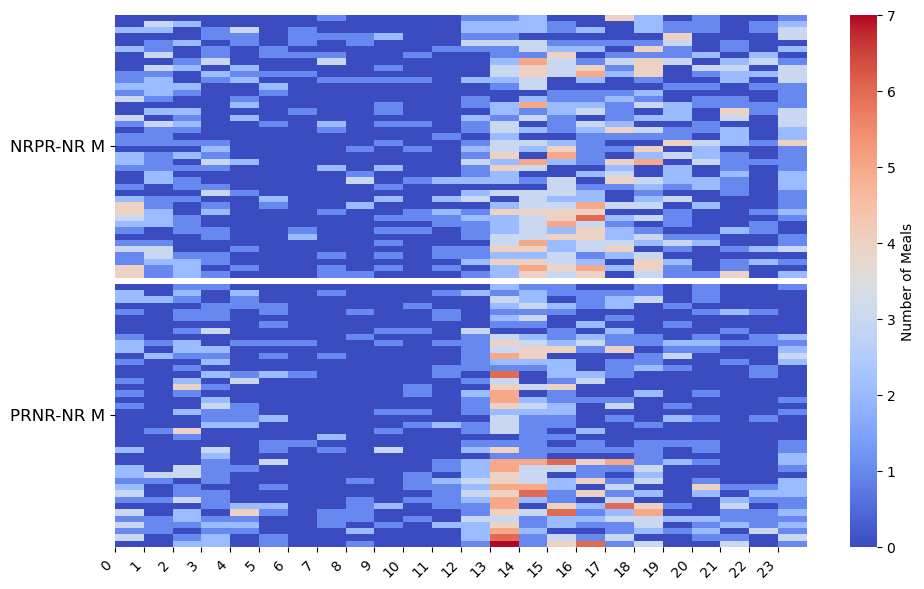

In [74]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, ax=None, labels=["NRPR-NR M", "PRNR-NR M"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly meals for two groups of male mice, ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains nr_hourly_meals data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains nr_hourly_meals data for group 2 (e.g., PRNR-NR M).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Flatten the hourly meals data and convert into a 2D array
    hourly_meals1 = np.array(tp.flatten_list(data1))
    hourly_meals2 = np.array(tp.flatten_list(data2))

    # Add padding between the two datasets
    padding = np.full((1, hourly_meals1.shape[1]), np.nan)  # NaN for clear separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="coolwarm", cbar_kws={'label': 'Number of Meals'}, **kwargs)

    # Set Y-tick labels and positions, ensuring separation
    ax.set_yticks([hourly_meals1.shape[0] / 2, hourly_meals1.shape[0] + 1 + hourly_meals2.shape[0] / 2])
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=12)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly meals data for NRPR-NR and PRNR-NR male mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}

nr_hourly_meals_m_nrpr = get_data_fields(mice, ["nr_hourly_meals"], nrpr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_meals"], prnr_male_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 6))

hourly_meals_heatmap(nr_hourly_meals_m_nrpr, nr_hourly_meals_m_prnr, ax=ax, 
                     labels=["NRPR-NR M", "PRNR-NR M"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary


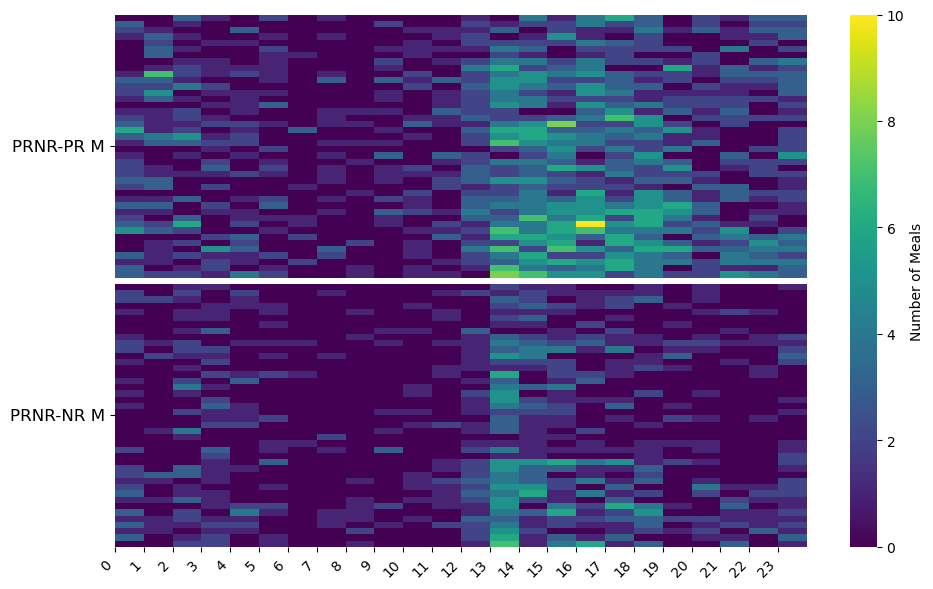

In [80]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, ax=None, labels=["NRPR-NR M", "PRNR-NR M"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly meals for two groups of male mice, ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains nr_hourly_meals data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains nr_hourly_meals data for group 2 (e.g., PRNR-NR M).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Flatten the hourly meals data and convert into a 2D array
    hourly_meals1 = np.array(tp.flatten_list(data1))
    hourly_meals2 = np.array(tp.flatten_list(data2))

    # Add padding between the two datasets
    padding = np.full((1, hourly_meals1.shape[1]), np.nan)  # NaN for clear separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Meals'}, **kwargs)

    # Set Y-tick labels and positions, ensuring separation
    ax.set_yticks([hourly_meals1.shape[0] / 2, hourly_meals1.shape[0] + 1 + hourly_meals2.shape[0] / 2])
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=12)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly meals data for NRPR-NR and PRNR-NR male mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_meals"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_meals"], prnr_male_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 6))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, ax=ax, 
                     labels=["PRNR-PR M", "PRNR-NR M"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary


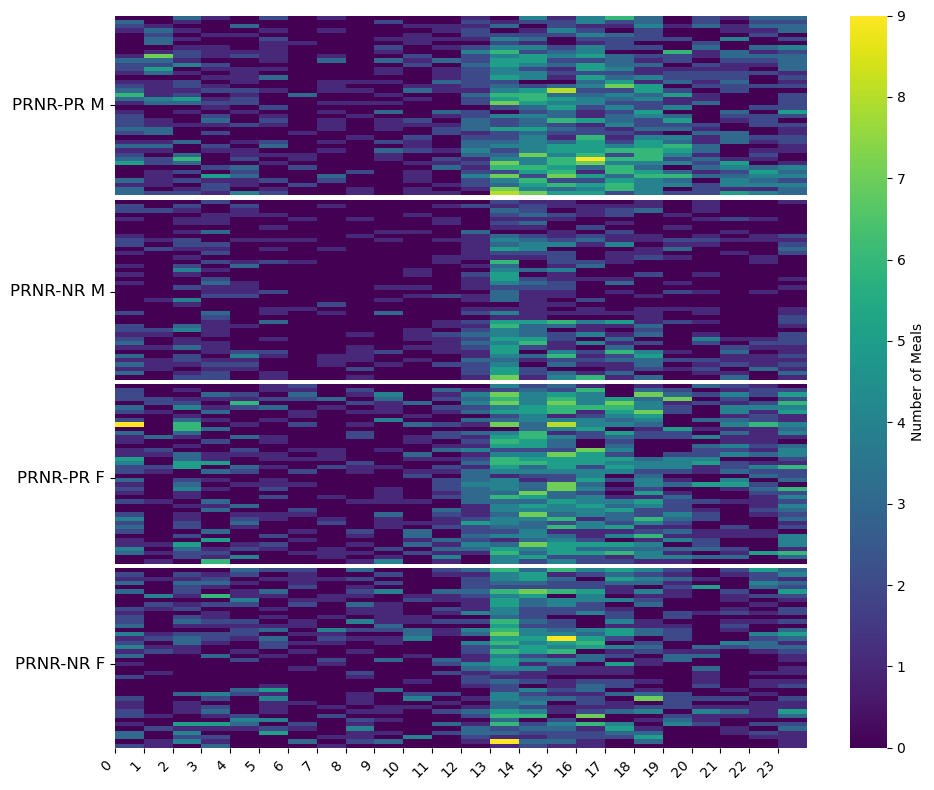

In [71]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly meals for four groups of male and female mice, ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly meals data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly meals data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly meals data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly meals data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Flatten the hourly meals data and convert into a 2D array
    hourly_meals1 = np.array(tp.flatten_list(data1))
    hourly_meals2 = np.array(tp.flatten_list(data2))
    hourly_meals3 = np.array(tp.flatten_list(data3))
    hourly_meals4 = np.array(tp.flatten_list(data4))

    # Add padding between the datasets
    padding = np.full((1, hourly_meals1.shape[1]), np.nan)  # NaN for clear separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Meals'}, **kwargs)

    # Set Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    y_positions = np.cumsum(group_lengths) - np.array(group_lengths) / 2 + np.arange(len(group_lengths)) * 1.5  # Add 1.5 space between groups
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=12)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly meals data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_meals"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_meals"], prnr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_meals"], prnr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_meals"], prnr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["PRNR-PR M", "PRNR-NR M", "PRNR-PR F", "PRNR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary


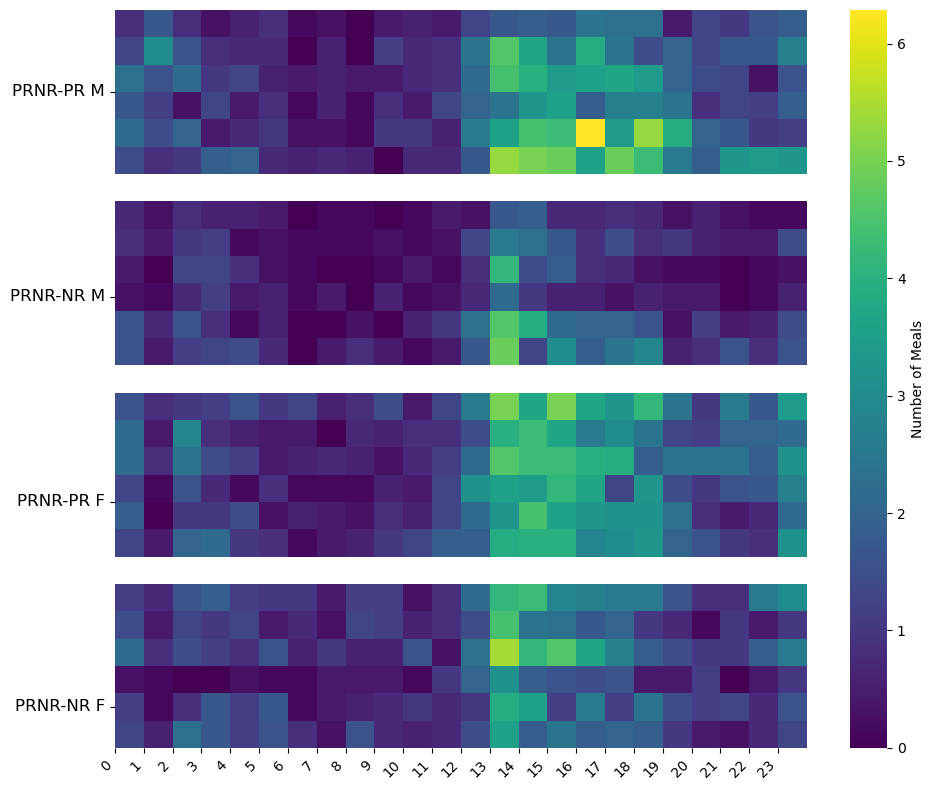

In [66]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly meals for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly meals data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly meals data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly meals data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly meals data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Meals'}, **kwargs)

    # Set Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    y_positions = np.cumsum(group_lengths) - np.array(group_lengths) / 2 + np.arange(len(group_lengths)) * 1.5  # Add 1.5 space between groups
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=12)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly meals data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_meals"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_meals"], prnr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_meals"], prnr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_meals"], prnr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["PRNR-PR M", "PRNR-NR M", "PRNR-PR F", "PRNR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
5 items in output dictionary


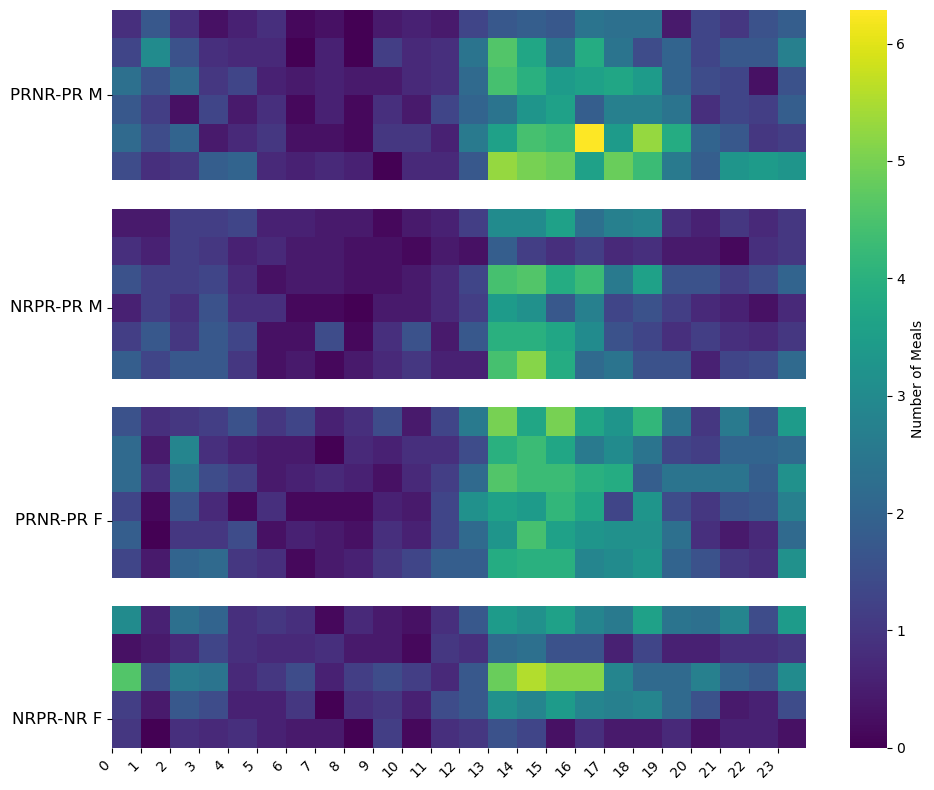

In [64]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly meals for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly meals data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly meals data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly meals data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly meals data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Meals'}, **kwargs)

    # Set Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    y_positions = np.cumsum(group_lengths) - np.array(group_lengths) / 2 + np.arange(len(group_lengths)) * 1.5  # Add 1.5 space between groups
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=12)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly meals data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_meals"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_meals"], nrpr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_meals"], prnr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_meals"], nrpr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["PRNR-PR M", "NRPR-PR M", "PRNR-PR F", "NRPR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
5 items in output dictionary


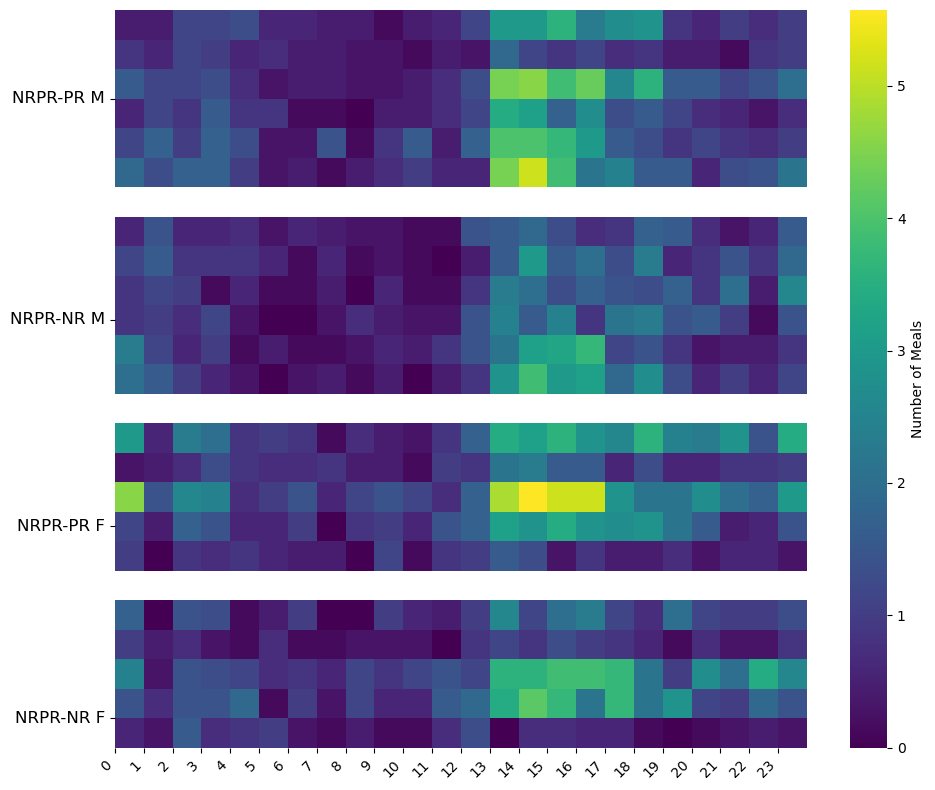

In [62]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly meals for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly meals data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly meals data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly meals data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly meals data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24)
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24)
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24)
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (5, 24)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Meals'}, **kwargs)

    # Set Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    y_positions = np.cumsum(group_lengths) - np.array(group_lengths) / 2 + np.arange(len(group_lengths)) * 1.5  # Add 1.5 space between groups
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=12)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly meals data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_meals"], nrpr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_meals"], nrpr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_meals"], nrpr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_meals"], nrpr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["NRPR-PR M", "NRPR-NR M", "NRPR-PR F", "NRPR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
5 items in output dictionary


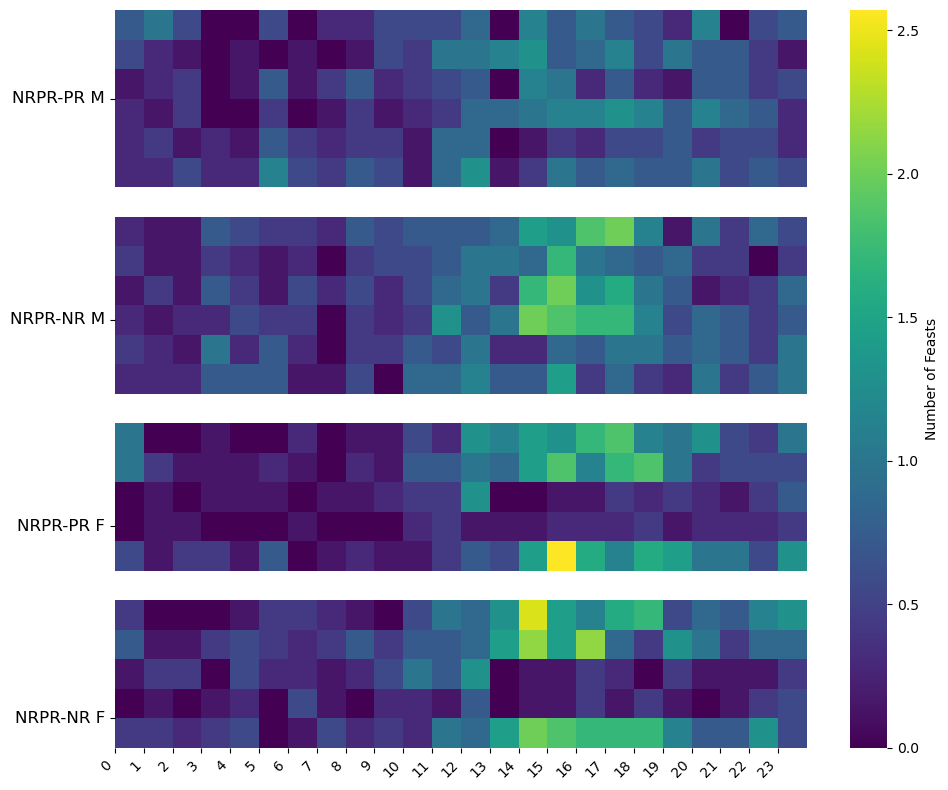

In [60]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly meals for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly meals data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly meals data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly meals data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly meals data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24)
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24)
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24)
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (5, 24)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Feasts'}, **kwargs)

    # Set Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    y_positions = np.cumsum(group_lengths) - np.array(group_lengths) / 2 + np.arange(len(group_lengths)) * 1.5  # Add 1.5 space between groups
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=12)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly mega meals data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_mega_meals"], nrpr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_mega_meals"], nrpr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_mega_meals"], nrpr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_mega_meals"], nrpr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["NRPR-PR M", "NRPR-NR M", "NRPR-PR F", "NRPR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
5 items in output dictionary


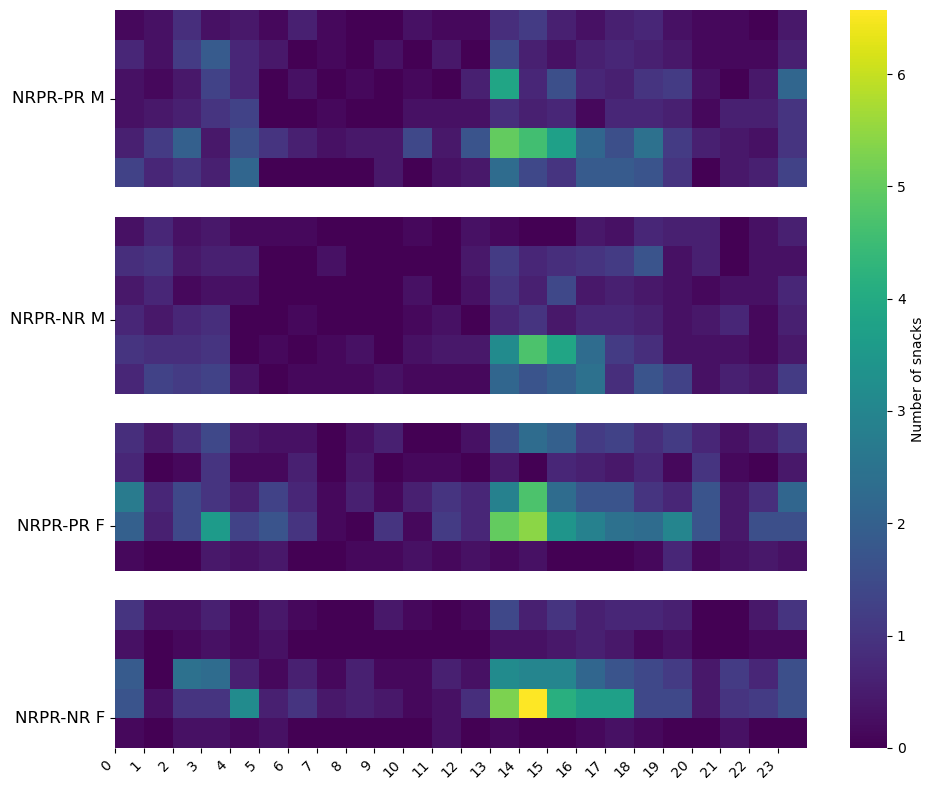

In [58]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly meals for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly meals data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly meals data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly meals data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly meals data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24)
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24)
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24)
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (5, 24)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of snacks'}, **kwargs)

    # Set Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    y_positions = np.cumsum(group_lengths) - np.array(group_lengths) / 2 + np.arange(len(group_lengths)) * 1.5  # Add 1.5 space between groups
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=12)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly meals data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_snacks"], nrpr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_snacks"], nrpr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_snacks"], nrpr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_snacks"], nrpr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["NRPR-PR M", "NRPR-NR M", "NRPR-PR F", "NRPR-NR F"], tick_step=1)

plt.show()


# Cell below ,  includes hourly pellet intake

In [6]:
import csv
from datetime import datetime
import numpy as np
import trompy as tp

def get_FEDevents(filename, eventname):
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']
    
    try:
        file = open(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []
    
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = []
    for row in csvreader:
        rows.append(row)

    # Check if rows are empty
    if len(rows) == 0:
        print(f"No data found in file: {filename}")
        return []

    # Determine which format should be used
    try:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[0])
        date_format = formats[0]
    except ValueError:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[1])
        date_format = formats[1]

    timestamps = []
    for row in rows: 
        if row[7] == eventname:  # Check event column
            date_time_obj = datetime.strptime(row[0], date_format)
            timestamps.append(date_time_obj)

    if len(timestamps) == 0:
        print(f"No {eventname} events found in file: {filename}")
        return []

    t0 = rows[0][0]
    day = t0.split()[0] 
    lightson = day + " 07:00:00"
    refpoint = datetime.strptime(lightson, date_format)
    
    pellettimes = []
    for t in timestamps:
        Deltat = t - refpoint
        Deltatinseconds = Deltat.total_seconds()
        Deltatinhours = Deltatinseconds / 3600
        pellettimes.append(Deltatinhours)

    return pellettimes

def get_data_subset(dictionary, selectors, verbose=True):
    output_dictionary = dictionary.copy()
    for key, value in selectors.items():
        for mouse_id in dictionary.keys():
            try:
                if output_dictionary[mouse_id][key] != value:
                    output_dictionary.pop(mouse_id)
            except KeyError: 
                pass

    if verbose:
        print("{} items in output dictionary".format(len(output_dictionary.keys())))
    
    return output_dictionary

def get_data_fields(dictionary, fields, selectors):
    output_list = []
    reduced_dictionary = get_data_subset(dictionary, selectors)
    
    if len(reduced_dictionary.keys()) > 0:
        for field in fields:
            output_sublist = []
            try:
                for key in reduced_dictionary.keys():
                    output_sublist.append(reduced_dictionary[key][field])
            except KeyError:
                print("{} is not a key in selected dictionary".format(field))
                return
            output_list.append(output_sublist)
    else:
        print("No data in fields in selected dictionary")

    if len(output_list) == 1:
        output_list = output_list[0]
        
    return output_list
# Function to get meal, snack, mega meal metrics, and hourly pellet intake
def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60):
    if not pellettimes:
        return (0, 0, 0, 0, 0, 0, 0, 0, [[0]*24]*7, [[0]*24]*7, [[0]*24]*7, [[0]*24]*7, 0, 0, 0, 0)

    IPIs = np.diff(np.array(pellettimes))
    meals = []
    snacks = []
    mega_meals = []
    current_event = [pellettimes[0]]

    # Hourly tracking for each day
    hourly_meals_per_day = [[0]*24 for _ in range(7)]
    hourly_snacks_per_day = [[0]*24 for _ in range(7)]
    hourly_mega_meals_per_day = [[0]*24 for _ in range(7)]
    hourly_pellet_intake = [[0]*24 for _ in range(7)]  # New addition to track pellet intake per hour

    for i, ipi in enumerate(IPIs):
        hour = int(pellettimes[i] % 24)
        day_index = int(pellettimes[i] // 24)
        if day_index < 7:
            hourly_pellet_intake[day_index][hour] += 1  # Increment pellet count for the hour

        if ipi <= meal_threshold:
            current_event.append(pellettimes[i + 1])
        else:
            if len(current_event) == 1:
                snacks.append(current_event)
                if day_index < 7:
                    hourly_snacks_per_day[day_index][hour] += 1
            elif 2 <= len(current_event) <= 4:
                meals.append(current_event)
                if day_index < 7:
                    hourly_meals_per_day[day_index][hour] += 1
            elif len(current_event) >= 5:
                mega_meals.append(current_event)
                if day_index < 7:
                    hourly_mega_meals_per_day[day_index][hour] += 1
            current_event = [pellettimes[i + 1]]

    # Handle the last sequence
    if current_event:
        hour = int(current_event[0] % 24)
        day_index = int(current_event[0] // 24)
        if len(current_event) == 1:
            snacks.append(current_event)
            if day_index < 7:
                hourly_snacks_per_day[day_index][hour] += 1
        elif 2 <= len(current_event) <= 4:
            meals.append(current_event)
            if day_index < 7:
                hourly_meals_per_day[day_index][hour] += 1
        elif len(current_event) >= 5:
            mega_meals.append(current_event)
            if day_index < 7:
                hourly_mega_meals_per_day[day_index][hour] += 1

    nmeals = len(meals)
    nsnacks = len(snacks)
    n_mega_meals = len(mega_meals)

    total_pellets = len(pellettimes)
    mealsize = sum(len(meal) for meal in meals) / nmeals if nmeals else 0
    snack_size = sum(len(snack) for snack in snacks) / nsnacks if nsnacks else 0
    total_observation_period = max(pellettimes) - min(pellettimes)
    meal_frequency = nmeals / total_observation_period if total_observation_period > 0 else 0
    snack_frequency = nsnacks / total_observation_period if total_observation_period > 0 else 0
    mega_meal_frequency = n_mega_meals / total_observation_period if total_observation_period > 0 else 0
    average_mega_meal_size = sum(len(meal) for meal in mega_meals) / n_mega_meals if n_mega_meals else 0

    return (mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, 
            mega_meal_frequency, average_mega_meal_size, hourly_meals_per_day, 
            hourly_snacks_per_day, hourly_mega_meals_per_day, hourly_pellet_intake, meals, snacks, mega_meals, n_mega_meals)



# Function to get events (meals, snacks, mega meals) per day based on timestamps
def get_events_per_day(events, days=7):
    events_per_day = [0] * days  # Initialize with zeros for the duration of the phase
    for event_list in events:
        if len(event_list) > 0:
            event_day = int(event_list[0] // 24)
            if event_day < days:
                events_per_day[event_day] += 1
    return events_per_day

# Function to calculate pellets per day
def get_pellets_per_day(timestamps, days=7):
    pellets_per_day = [0] * days
    for day in range(days):
        pellets = [t for t in timestamps if (t > day * 24) and (t < (day + 1) * 24)]
        n_pellets = len(pellets)
        pellets_per_day[day] = n_pellets

    return pellets_per_day


# Function to calculate inter-pellet intervals (IPI)
def get_interpellet_intervals(pellettimes):
    IPIs = np.diff(pellettimes)
    return IPIs

# Function to calculate intermeal intervals (IMI)
def get_intermeal_interval(pellettimes, meal_threshold=1/60):
    IPIs = np.diff(pellettimes)
    IMIs = [x for x in IPIs if x > meal_threshold]
    average_IMI = np.mean(IMIs) if IMIs else 0  # Handle case with no IMIs
    return average_IMI

# Load the metafile and process the data
metafile = "..\\FEDProtein_METAFILE.xls"
rows, header = tp.metafilereader(metafile, sheetname="METAFILE")

mice = {}
for row in rows:
    mouse_id = row[1]
    if mouse_id not in mice.keys():
        mice[mouse_id] = {}
        mice[mouse_id]["sex"] = row[4]
        mice[mouse_id]["order"] = row[5]

for key in mice.keys():
    for row in rows:
        if row[1] == key and row[3] == "FF":
            filename = "..\\data\\{}".format(row[0])
            if row[2] == "GRAIN":
                mice[key]["grain_timestamps"] = get_FEDevents(filename, "Pellet")
            elif row[2] == "PR":
                mice[key]["pr_timestamps"] = get_FEDevents(filename, "Pellet")
            elif row[2] == "NR":
                mice[key]["nr_timestamps"] = get_FEDevents(filename, "Pellet")
            else:
                print(row[2], "is not a valid type of pellet for", key)

# Add meal, snack, mega meal metrics, and IMI, IPI calculations to the dictionary
for key in mice.keys():
    grain_timestamps = mice[key].get("grain_timestamps", [])
    pr_timestamps = mice[key].get("pr_timestamps", [])
    nr_timestamps = mice[key].get("nr_timestamps", [])

    # Get metrics for GRAIN, PR, and NR phases
    grain_metrics = get_meal_and_snack_metrics(grain_timestamps)
    pr_metrics = get_meal_and_snack_metrics(pr_timestamps)
    nr_metrics = get_meal_and_snack_metrics(nr_timestamps)

    # GRAIN phase
    (
        mice[key]["grain_meal_size"],
        mice[key]["grain_snack_size"],
        mice[key]["grain_number_of_meals"],
        mice[key]["grain_meal_frequency"],
        mice[key]["grain_number_of_snacks"],
        mice[key]["grain_snack_frequency"],
        mice[key]["grain_mega_meal_frequency"],
        mice[key]["grain_mega_meal_size"],
        mice[key]["grain_hourly_meals"],
        mice[key]["grain_hourly_snacks"],
        mice[key]["grain_hourly_mega_meals"],
        mice[key]["grain_hourly_pellet_intake"],
        grain_meals,
        grain_snacks,
        grain_mega_meals,
        mice[key]["grain_number_of_mega_meals"]  # Store the number of mega meals
    ) = grain_metrics

    # PR phase
    (
        mice[key]["pr_meal_size"],
        mice[key]["pr_snack_size"],
        mice[key]["pr_number_of_meals"],
        mice[key]["pr_meal_frequency"],
        mice[key]["pr_number_of_snacks"],
        mice[key]["pr_snack_frequency"],
        mice[key]["pr_mega_meal_frequency"],
        mice[key]["pr_mega_meal_size"],
        mice[key]["pr_hourly_meals"],
        mice[key]["pr_hourly_snacks"],
        mice[key]["pr_hourly_mega_meals"],
        mice[key]["pr_hourly_pellet_intake"],
        pr_meals,
        pr_snacks,
        pr_mega_meals,
        mice[key]["pr_number_of_mega_meals"]  # Store the number of mega meals
    ) = pr_metrics

    # NR phase
    (
        mice[key]["nr_meal_size"],
        mice[key]["nr_snack_size"],
        mice[key]["nr_number_of_meals"],
        mice[key]["nr_meal_frequency"],
        mice[key]["nr_number_of_snacks"],
        mice[key]["nr_snack_frequency"],
        mice[key]["nr_mega_meal_frequency"],
        mice[key]["nr_mega_meal_size"],
        mice[key]["nr_hourly_meals"],
        mice[key]["nr_hourly_snacks"],
        mice[key]["nr_hourly_mega_meals"],
        mice[key]["nr_hourly_pellet_intake"],
        nr_meals,
        nr_snacks,
        nr_mega_meals,
        mice[key]["nr_number_of_mega_meals"]  # Store the number of mega meals
    ) = nr_metrics

    # Events per day and pellets per day (as previously done)
    mice[key]["grain_meals_per_day"] = get_events_per_day(grain_meals, days=3)
    mice[key]["pr_meals_per_day"] = get_events_per_day(pr_meals, days=7)
    mice[key]["nr_meals_per_day"] = get_events_per_day(nr_meals, days=7)

    mice[key]["grain_snacks_per_day"] = get_events_per_day(grain_snacks, days=3)
    mice[key]["pr_snacks_per_day"] = get_events_per_day(pr_snacks, days=7)
    mice[key]["nr_snacks_per_day"] = get_events_per_day(nr_snacks, days=7)

    mice[key]["grain_mega_meals_per_day"] = get_events_per_day(grain_mega_meals, days=3)
    mice[key]["pr_mega_meals_per_day"] = get_events_per_day(pr_mega_meals, days=7)
    mice[key]["nr_mega_meals_per_day"] = get_events_per_day(nr_mega_meals, days=7)

    mice[key]["grain_pellets_per_day"] = get_pellets_per_day(mice[key]["grain_timestamps"], days=3)
    mice[key]["pr_pellets_per_day"] = get_pellets_per_day(mice[key]["pr_timestamps"], days=7)
    mice[key]["nr_pellets_per_day"] = get_pellets_per_day(mice[key]["nr_timestamps"], days=7)


# Now combine events and pellets per day for the entire 17-day time course (as before)
for key in mice.keys():
    # Combine pellets per day
    mice[key]["all_pellets_per_day"] = (
        mice[key].get("grain_pellets_per_day", [0] * 3) +
        mice[key].get("pr_pellets_per_day", [0] * 7) +
        mice[key].get("nr_pellets_per_day", [0] * 7)
    )

    # Combine meals per day
    mice[key]["all_meals_per_day"] = (
        mice[key].get("grain_meals_per_day", [0] * 3) +
        mice[key].get("pr_meals_per_day", [0] * 7) +
        mice[key].get("nr_meals_per_day", [0] * 7)
    )

    # Combine snacks per day
    mice[key]["all_snacks_per_day"] = (
        mice[key].get("grain_snacks_per_day", [0] * 3) +
        mice[key].get("pr_snacks_per_day", [0] * 7) +
        mice[key].get("nr_snacks_per_day", [0] * 7)
    )

    # Combine mega meals per day
    mice[key]["all_mega_meals_per_day"] = (
        mice[key].get("grain_mega_meals_per_day", [0] * 3) +
        mice[key].get("pr_mega_meals_per_day", [0] * 7) +
        mice[key].get("nr_mega_meals_per_day", [0] * 7)
    )

# Output the results to check the data structure
for key, value in mice.items():
    print(f"Mouse {key}:")
    print("  Pellets per day:", mice[key]["all_pellets_per_day"])
    print("  Meals per day:", mice[key]["all_meals_per_day"])
    print("  Snacks per day:", mice[key]["all_snacks_per_day"])
    print("  Mega Meals per hour:", mice[key]["nr_hourly_mega_meals"])
    print("  Mega Meals Frequency:", mice[key]["nr_mega_meal_frequency"])
    print("  Mega Meals Size:", mice[key]["nr_mega_meal_size"])

Mouse FEDXA01:
  Pellets per day: [340, 271, 224, 161, 155, 176, 184, 215, 231, 240, 246, 234, 222, 211, 241, 223, 219]
  Meals per day: [43, 25, 23, 35, 28, 31, 24, 24, 31, 14, 9, 18, 18, 15, 13, 9, 6]
  Snacks per day: [30, 18, 25, 32, 44, 52, 62, 28, 25, 13, 13, 14, 14, 19, 18, 12, 13]
  Mega Meals per hour: [[0, 0, 0, 2, 1, 2, 0, 1, 1, 0, 2, 1, 1, 1, 1, 2, 3, 3, 1, 2, 0, 1, 1, 1], [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 2, 1, 2, 3, 3, 2, 1, 2, 0, 0, 1], [1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 0, 1, 0, 0, 2], [1, 2, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 0, 1, 1, 1, 0], [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 2, 1, 4, 2, 3, 2, 0, 1, 0, 1, 1], [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 0, 2], [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 2, 1, 1, 1, 1, 1, 2]]
  Mega Meals Frequency: 1.0133227626203154
  Mega Meals Size: 7.27810650887574
Mouse FEDXA02:
  Pellets per day: [304, 214, 194, 154, 153, 204, 211, 203, 226, 214, 225,

In [5]:
import pandas as pd

# Function to save the data into CSV
def save_hourly_pellet_intake_to_csv(mice_data, filename):
    data_to_save = []
    
    # Loop through each mouse in the dataset
    for mouse_id, mouse_data in mice_data.items():
        for day_index in range(7):  # Loop through each day (0-6)
            for hour in range(24):  # Loop through each hour (0-23)
                # Extract the necessary information
                record = {
                    'mouse_id': mouse_id,
                    'sex': mouse_data['sex'],
                    'order': mouse_data['order'],
                    'day': day_index,
                    'hour': hour,
                    'pr_hourly_pellet_intake': mouse_data.get('pr_hourly_pellet_intake', [[0]*24]*7)[day_index][hour],
                    'nr_hourly_pellet_intake': mouse_data.get('nr_hourly_pellet_intake', [[0]*24]*7)[day_index][hour]
                }
                data_to_save.append(record)
    
    # Convert the list of dictionaries to a DataFrame and save as CSV
    df = pd.DataFrame(data_to_save)
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

# Save the hourly pellet intake data to a CSV file
save_hourly_pellet_intake_to_csv(mice, r'C:\Users\hta031\Github\FEDProtein\results\ULTIMATE_HOURLY_R\hourly_pellet_intake.csv')


Data saved to C:\Users\hta031\Github\FEDProtein\results\ULTIMATE_HOURLY_R\hourly_pellet_intake.csv


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary


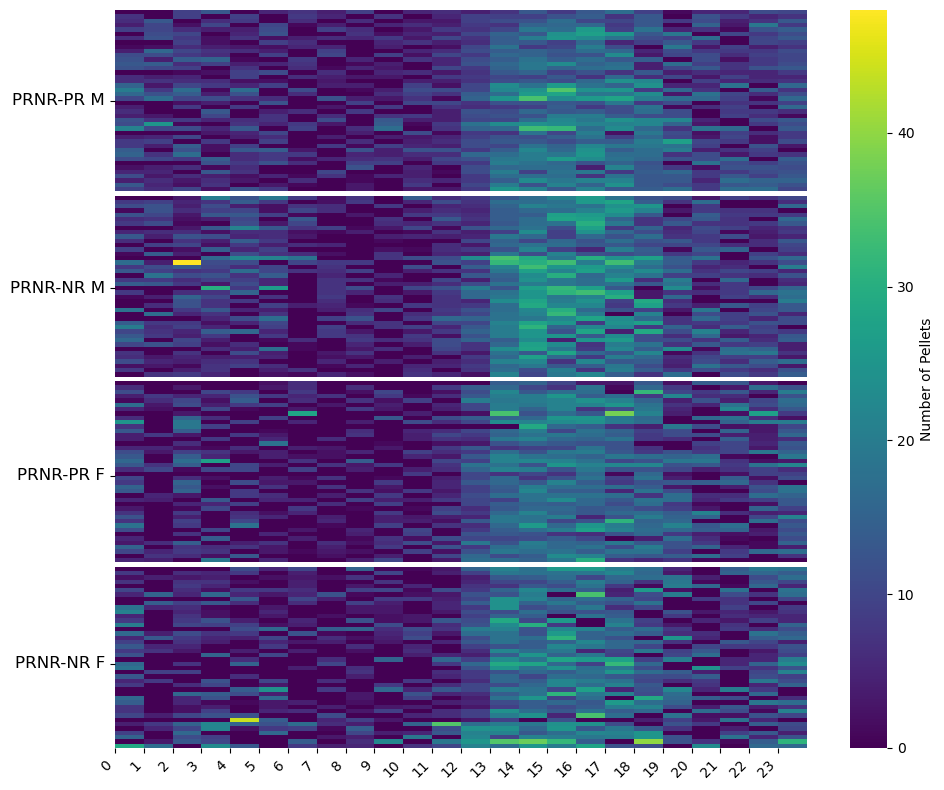

In [86]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly meals for four groups of male and female mice, ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly meals data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly meals data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly meals data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly meals data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Flatten the hourly meals data and convert into a 2D array
    hourly_meals1 = np.array(tp.flatten_list(data1))
    hourly_meals2 = np.array(tp.flatten_list(data2))
    hourly_meals3 = np.array(tp.flatten_list(data3))
    hourly_meals4 = np.array(tp.flatten_list(data4))

    # Add padding between the datasets
    padding = np.full((1, hourly_meals1.shape[1]), np.nan)  # NaN for clear separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Pellets'}, **kwargs)

    # Set Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    y_positions = np.cumsum(group_lengths) - np.array(group_lengths) / 2 + np.arange(len(group_lengths)) * 1.5  # Add 1.5 space between groups
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=12)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly meals data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_pellet_intake"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_pellet_intake"], prnr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_pellet_intake"], prnr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_pellet_intake"], prnr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["PRNR-PR M", "PRNR-NR M", "PRNR-PR F", "PRNR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary


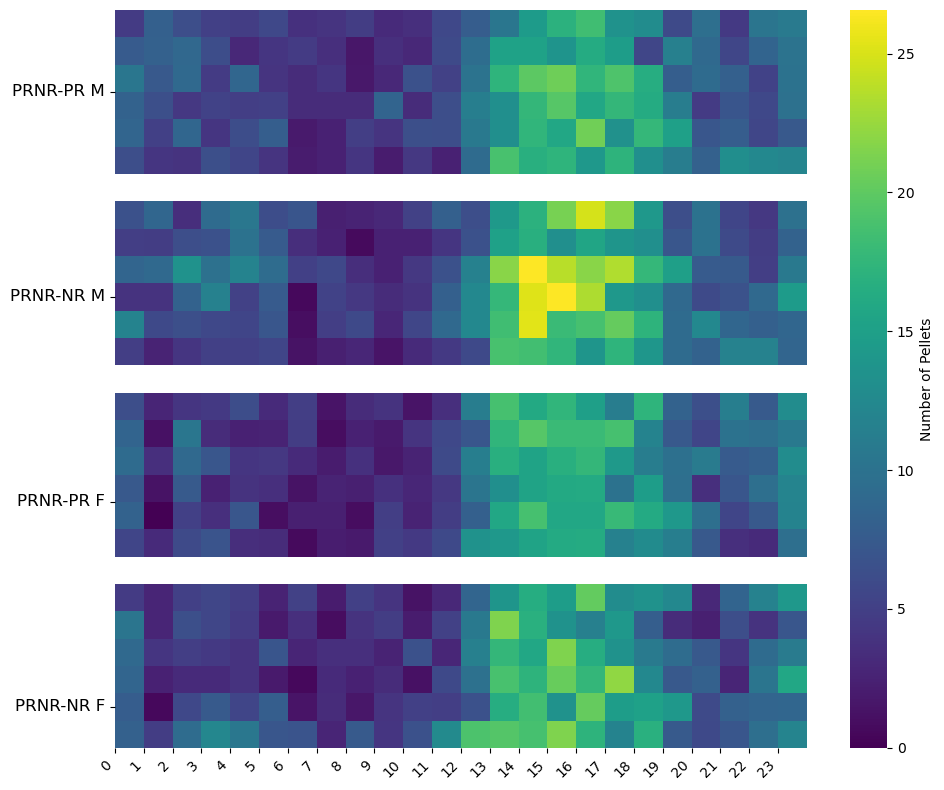

In [87]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly pellet intake for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly pellet intake data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly pellet intake data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly pellet intake data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly pellet intake data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Pellets'}, **kwargs)

    # Set Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    y_positions = np.cumsum(group_lengths) - np.array(group_lengths) / 2 + np.arange(len(group_lengths)) * 1.5  # Add 1.5 space between groups
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=12)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly pellet intake data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_pellet_intake"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_pellet_intake"], prnr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_pellet_intake"], prnr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_pellet_intake"], prnr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["PRNR-PR M", "PRNR-NR M", "PRNR-PR F", "PRNR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary


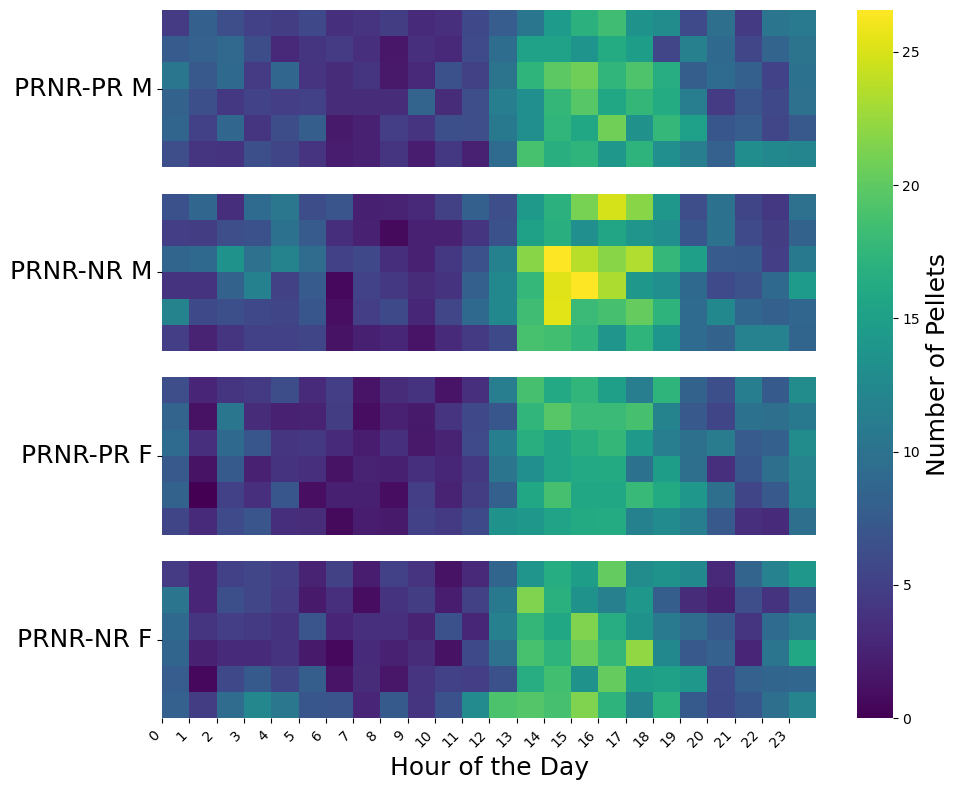

In [106]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly pellet intake for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly pellet intake data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly pellet intake data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly pellet intake data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly pellet intake data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    heatmap = sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Pellets'}, **kwargs)

    # Adjust the color bar label font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)  # Set the label font size

    # Calculate Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    padding_size = 1  # Padding of 1 row between groups
    cumulative_lengths = np.cumsum([0] + [length + padding_size for length in group_lengths[:-1]])
    y_positions = [cum + (length / 2) for cum, length in zip(cumulative_lengths, group_lengths)]  # Center the labels

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=18)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')
    ax.set_xlabel("Hour of the Day", fontsize=18)

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly pellet intake data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_pellet_intake"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_pellet_intake"], prnr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_pellet_intake"], prnr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_pellet_intake"], prnr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["PRNR-PR M", "PRNR-NR M", "PRNR-PR F", "PRNR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
5 items in output dictionary


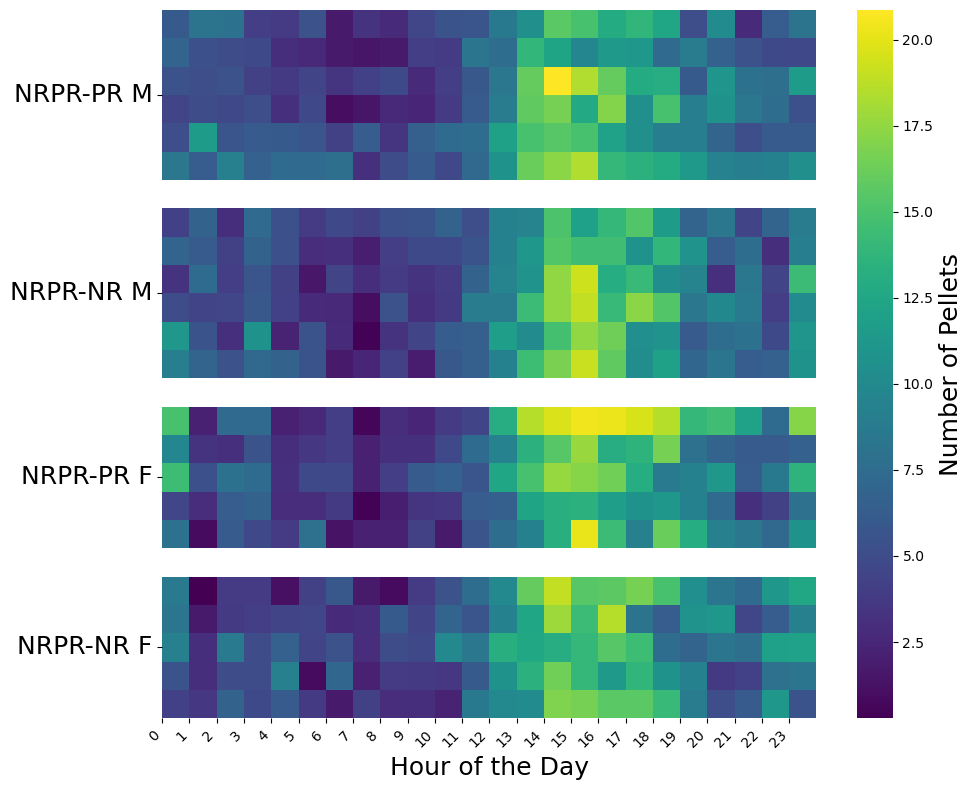

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly pellet intake for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly pellet intake data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly pellet intake data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly pellet intake data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly pellet intake data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    heatmap = sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Pellets'}, **kwargs)

    # Adjust the color bar label font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)  # Set the label font size

    # Calculate Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    padding_size = 1  # Padding of 1 row between groups
    cumulative_lengths = np.cumsum([0] + [length + padding_size for length in group_lengths[:-1]])
    y_positions = [cum + (length / 2) for cum, length in zip(cumulative_lengths, group_lengths)]  # Center the labels

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=18)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')
    ax.set_xlabel("Hour of the Day", fontsize=18)

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly pellet intake data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_pellet_intake"], nrpr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_pellet_intake"], nrpr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_pellet_intake"], nrpr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_pellet_intake"], nrpr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["NRPR-PR M", "NRPR-NR M", "NRPR-PR F", "NRPR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
5 items in output dictionary


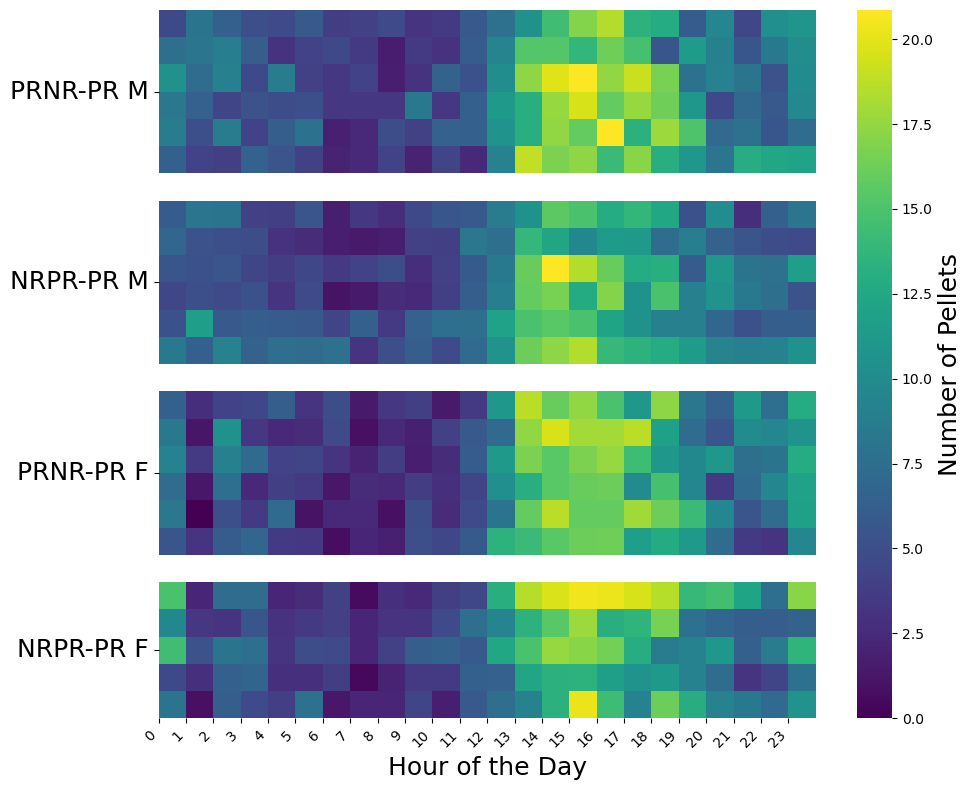

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly pellet intake for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly pellet intake data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly pellet intake data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly pellet intake data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly pellet intake data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    heatmap = sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Pellets'}, **kwargs)

    # Adjust the color bar label font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)  # Set the label font size

    # Calculate Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    padding_size = 1  # Padding of 1 row between groups
    cumulative_lengths = np.cumsum([0] + [length + padding_size for length in group_lengths[:-1]])
    y_positions = [cum + (length / 2) for cum, length in zip(cumulative_lengths, group_lengths)]  # Center the labels

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=18)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')
    ax.set_xlabel("Hour of the Day", fontsize=18)

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly pellet intake data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_pellet_intake"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_pellet_intake"], nrpr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_pellet_intake"], prnr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_pellet_intake"], nrpr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["PRNR-PR M", "NRPR-PR M", "PRNR-PR F", "NRPR-PR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
5 items in output dictionary


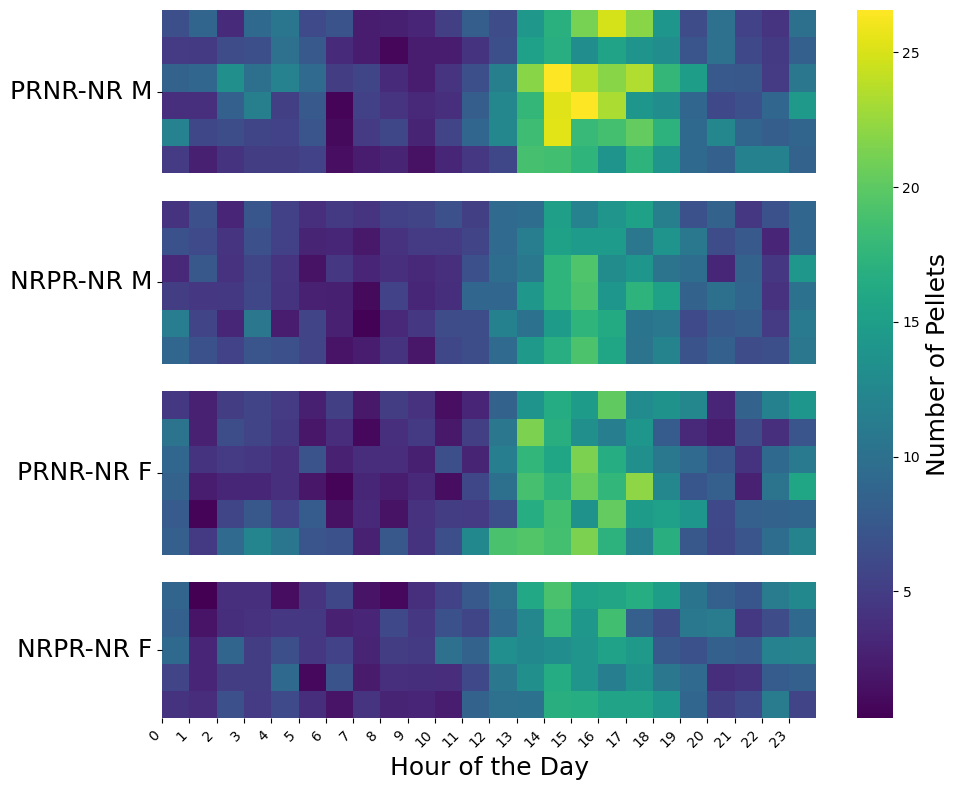

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly pellet intake for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly pellet intake data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly pellet intake data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly pellet intake data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly pellet intake data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    heatmap = sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Pellets'}, **kwargs)

    # Adjust the color bar label font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)  # Set the label font size

    # Calculate Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    padding_size = 1  # Padding of 1 row between groups
    cumulative_lengths = np.cumsum([0] + [length + padding_size for length in group_lengths[:-1]])
    y_positions = [cum + (length / 2) for cum, length in zip(cumulative_lengths, group_lengths)]  # Center the labels

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=18)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')
    ax.set_xlabel("Hour of the Day", fontsize=18)

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly pellet intake data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_pellet_intake"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_pellet_intake"], nrpr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_pellet_intake"], prnr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_pellet_intake"], nrpr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["PRNR-NR M", "NRPR-NR M", "PRNR-NR F", "NRPR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary


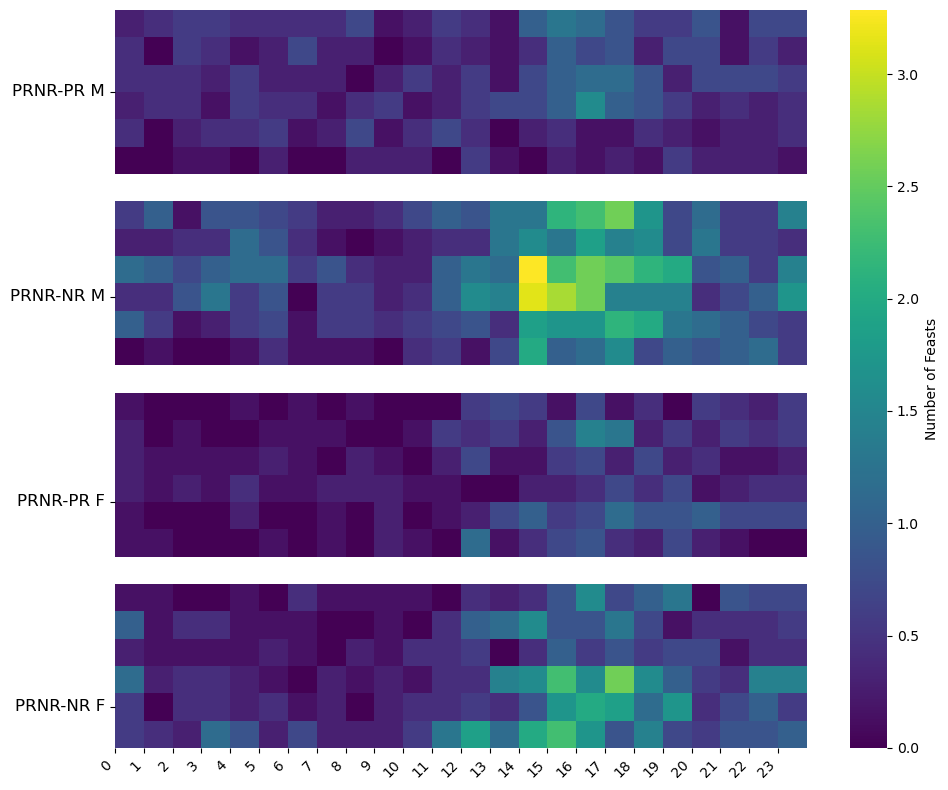

In [81]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly meals for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly meals data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly meals data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly meals data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly meals data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24)
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24)
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24)
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (5, 24)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Feasts'}, **kwargs)

    # Set Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    y_positions = np.cumsum(group_lengths) - np.array(group_lengths) / 2 + np.arange(len(group_lengths)) * 1.5  # Add 1.5 space between groups
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=12)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly mega meals data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_mega_meals"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_mega_meals"], prnr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_mega_meals"], prnr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_mega_meals"], prnr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["PRNR-PR M", "PRNR-NR M", "PRNR-PR F", "PRNR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
5 items in output dictionary


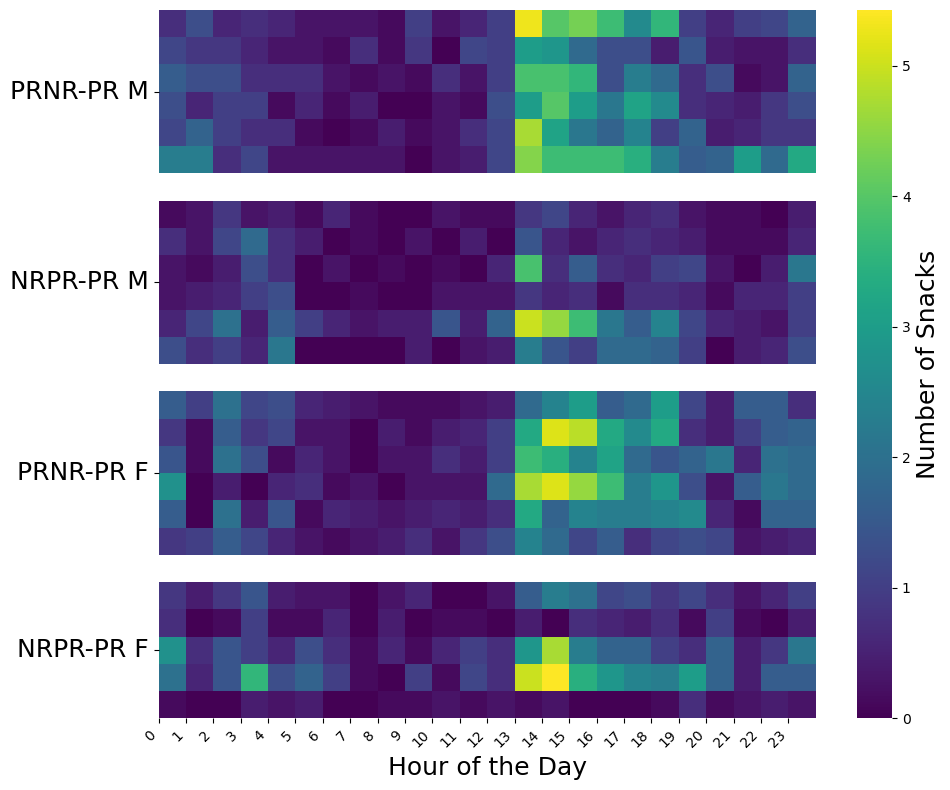

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly pellet intake for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly pellet intake data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly pellet intake data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly pellet intake data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly pellet intake data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    heatmap = sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Snacks'}, **kwargs)

    # Adjust the color bar label font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)  # Set the label font size

    # Calculate Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    padding_size = 1  # Padding of 1 row between groups
    cumulative_lengths = np.cumsum([0] + [length + padding_size for length in group_lengths[:-1]])
    y_positions = [cum + (length / 2) for cum, length in zip(cumulative_lengths, group_lengths)]  # Center the labels

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=18)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')
    ax.set_xlabel("Hour of the Day", fontsize=18)

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly pellet intake data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_snacks"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_snacks"], nrpr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_snacks"], prnr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_snacks"], nrpr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["PRNR-PR M", "NRPR-PR M", "PRNR-PR F", "NRPR-PR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
5 items in output dictionary


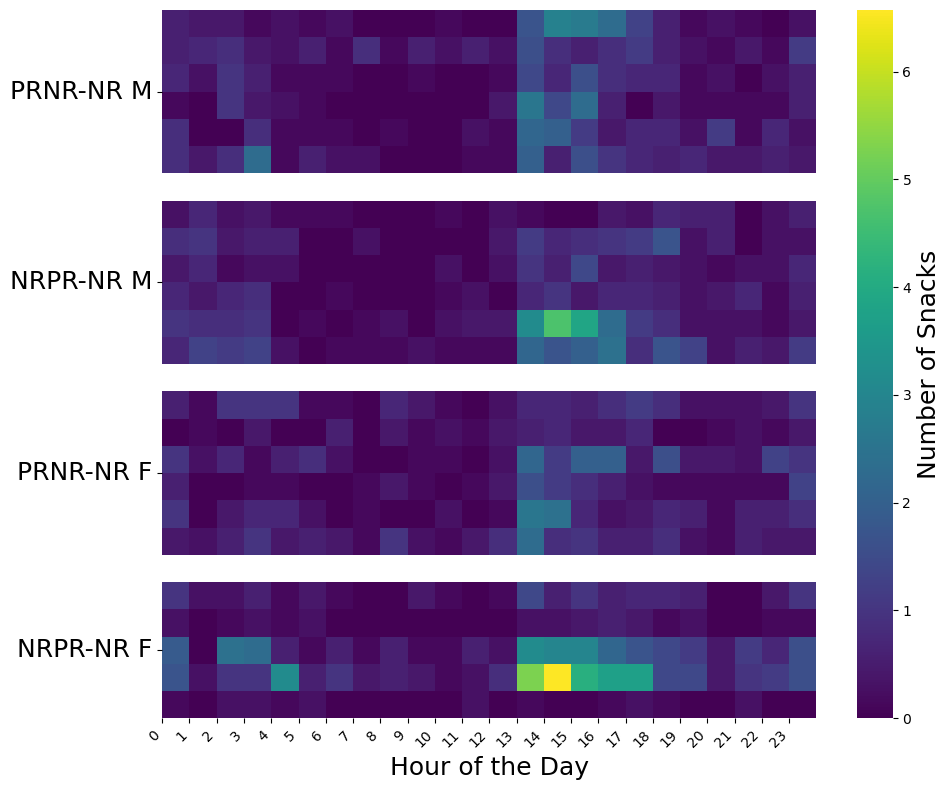

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly pellet intake for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly pellet intake data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly pellet intake data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly pellet intake data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly pellet intake data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    heatmap = sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Snacks'}, **kwargs)

    # Adjust the color bar label font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)  # Set the label font size

    # Calculate Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    padding_size = 1  # Padding of 1 row between groups
    cumulative_lengths = np.cumsum([0] + [length + padding_size for length in group_lengths[:-1]])
    y_positions = [cum + (length / 2) for cum, length in zip(cumulative_lengths, group_lengths)]  # Center the labels

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=18)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')
    ax.set_xlabel("Hour of the Day", fontsize=18)

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly pellet intake data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_snacks"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_snacks"], nrpr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_snacks"], prnr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_snacks"], nrpr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["PRNR-NR M", "NRPR-NR M", "PRNR-NR F", "NRPR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary


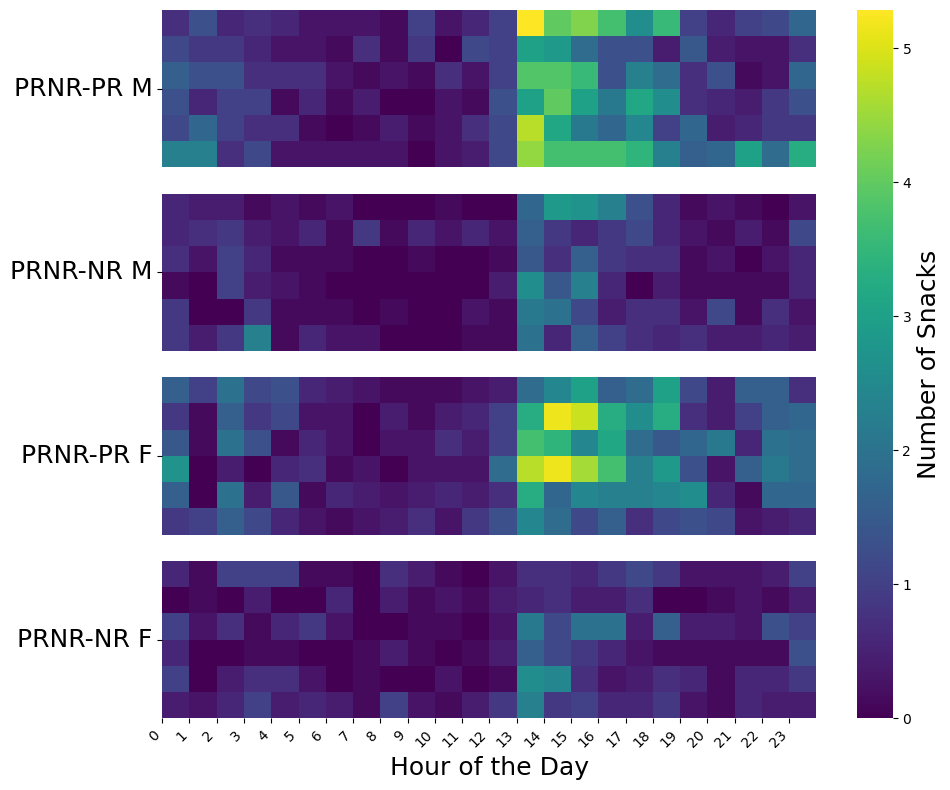

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly pellet intake for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly pellet intake data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly pellet intake data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly pellet intake data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly pellet intake data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    heatmap = sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Snacks'}, **kwargs)

    # Adjust the color bar label font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)  # Set the label font size

    # Calculate Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    padding_size = 1  # Padding of 1 row between groups
    cumulative_lengths = np.cumsum([0] + [length + padding_size for length in group_lengths[:-1]])
    y_positions = [cum + (length / 2) for cum, length in zip(cumulative_lengths, group_lengths)]  # Center the labels

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=18)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')
    ax.set_xlabel("Hour of the Day", fontsize=18)

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly pellet intake data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_snacks"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_snacks"],  prnr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_snacks"], prnr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_snacks"], prnr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["PRNR-PR M", "PRNR-NR M", "PRNR-PR F", "PRNR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
5 items in output dictionary


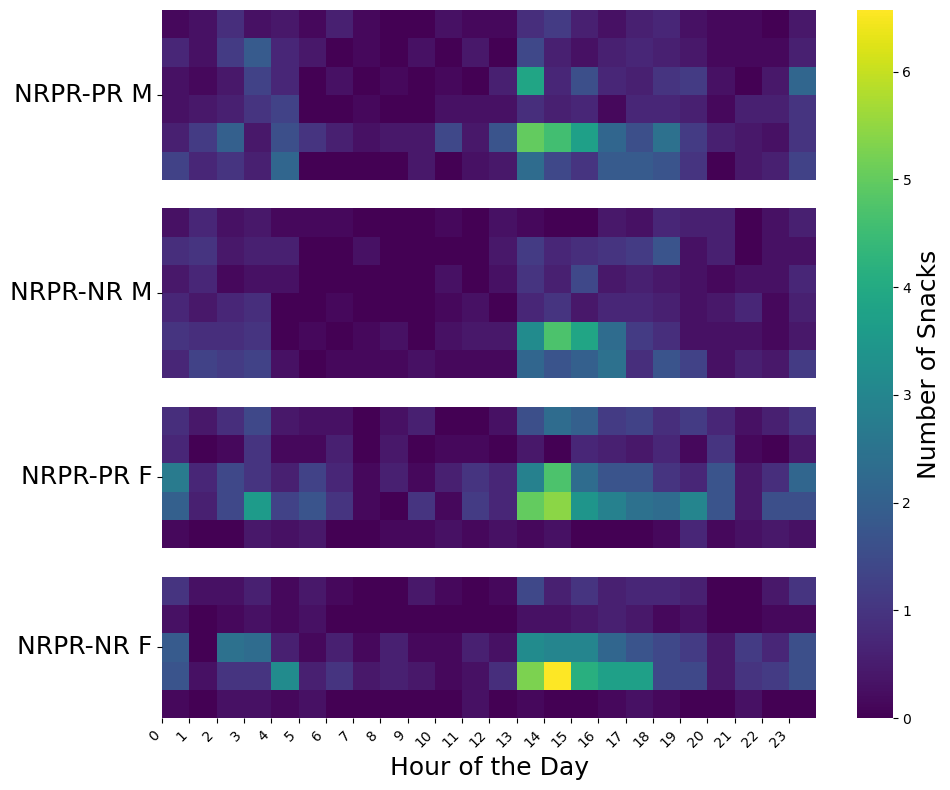

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly pellet intake for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly pellet intake data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly pellet intake data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly pellet intake data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly pellet intake data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    heatmap = sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Snacks'}, **kwargs)

    # Adjust the color bar label font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)  # Set the label font size

    # Calculate Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    padding_size = 1  # Padding of 1 row between groups
    cumulative_lengths = np.cumsum([0] + [length + padding_size for length in group_lengths[:-1]])
    y_positions = [cum + (length / 2) for cum, length in zip(cumulative_lengths, group_lengths)]  # Center the labels

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=18)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')
    ax.set_xlabel("Hour of the Day", fontsize=18)

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly pellet intake data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_snacks"], nrpr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_snacks"],  nrpr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_snacks"], nrpr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_snacks"], nrpr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["NRPR-PR M", "NRPR-NR M", "NRPR-PR F", "NRPR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
5 items in output dictionary


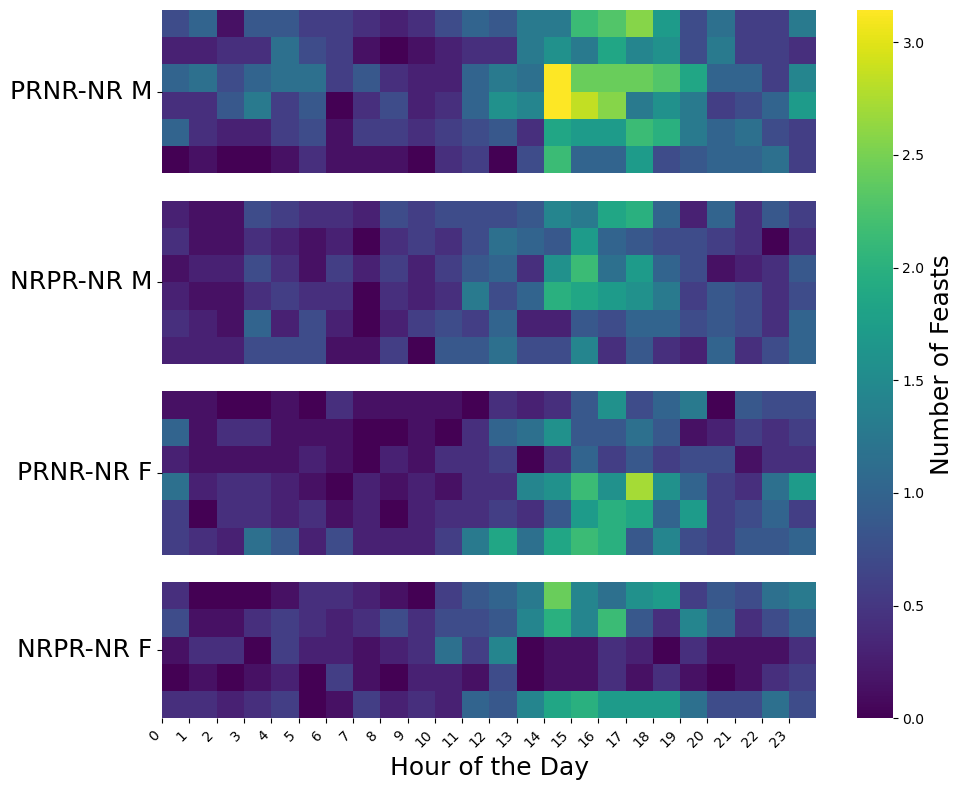

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly pellet intake for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly pellet intake data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly pellet intake data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly pellet intake data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly pellet intake data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    heatmap = sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Feasts'}, **kwargs)

    # Adjust the color bar label font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)  # Set the label font size

    # Calculate Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    padding_size = 1  # Padding of 1 row between groups
    cumulative_lengths = np.cumsum([0] + [length + padding_size for length in group_lengths[:-1]])
    y_positions = [cum + (length / 2) for cum, length in zip(cumulative_lengths, group_lengths)]  # Center the labels

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=18)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')
    ax.set_xlabel("Hour of the Day", fontsize=18)

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly pellet intake data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_mega_meals"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_mega_meals"], nrpr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_mega_meals"], prnr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_mega_meals"], nrpr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["PRNR-NR M", "NRPR-NR M", "PRNR-NR F", "NRPR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
5 items in output dictionary


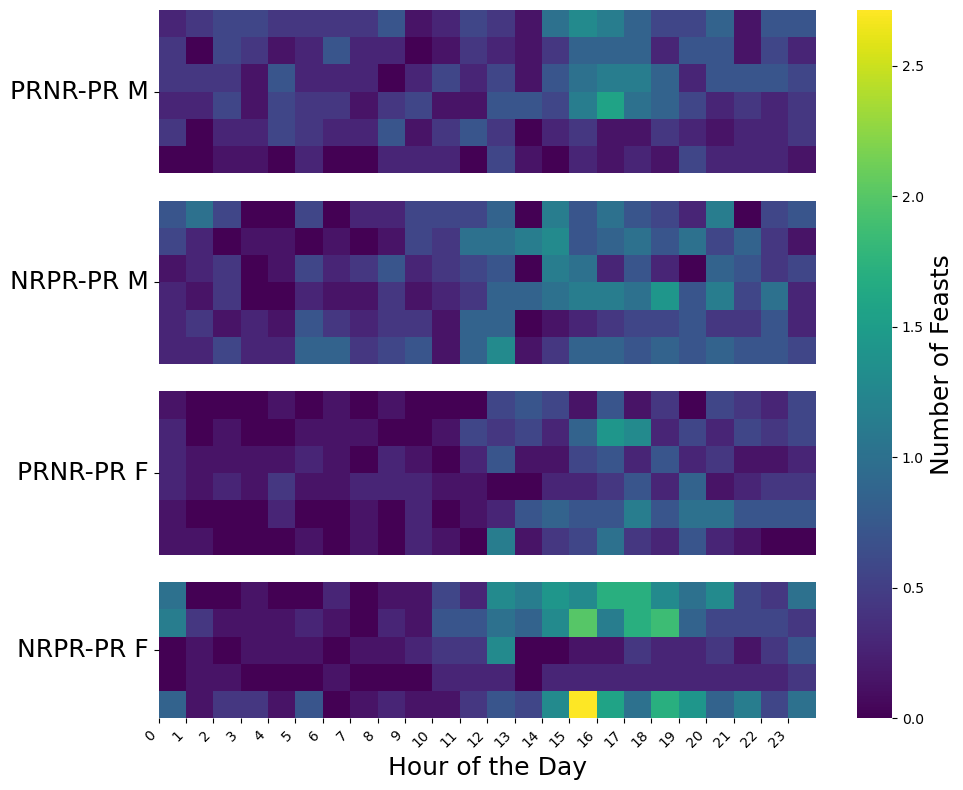

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly pellet intake for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly pellet intake data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly pellet intake data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly pellet intake data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly pellet intake data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    heatmap = sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Feasts'}, **kwargs)

    # Adjust the color bar label font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)  # Set the label font size

    # Calculate Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    padding_size = 1  # Padding of 1 row between groups
    cumulative_lengths = np.cumsum([0] + [length + padding_size for length in group_lengths[:-1]])
    y_positions = [cum + (length / 2) for cum, length in zip(cumulative_lengths, group_lengths)]  # Center the labels

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=18)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')
    ax.set_xlabel("Hour of the Day", fontsize=18)

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly pellet intake data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_mega_meals"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_mega_meals"], nrpr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_mega_meals"], prnr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_mega_meals"], nrpr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["PRNR-PR M", "NRPR-PR M", "PRNR-PR F", "NRPR-PR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary


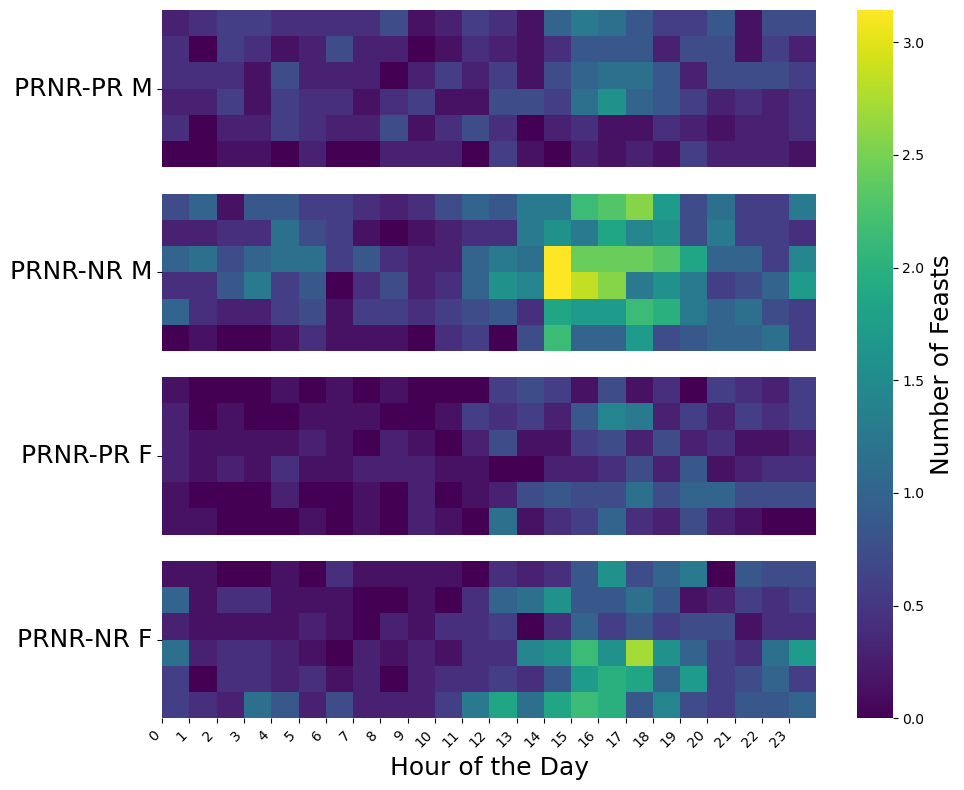

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly pellet intake for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly pellet intake data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly pellet intake data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly pellet intake data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly pellet intake data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    heatmap = sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Feasts'}, **kwargs)

    # Adjust the color bar label font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)  # Set the label font size

    # Calculate Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    padding_size = 1  # Padding of 1 row between groups
    cumulative_lengths = np.cumsum([0] + [length + padding_size for length in group_lengths[:-1]])
    y_positions = [cum + (length / 2) for cum, length in zip(cumulative_lengths, group_lengths)]  # Center the labels

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=18)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')
    ax.set_xlabel("Hour of the Day", fontsize=18)

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly pellet intake data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_mega_meals"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_mega_meals"], prnr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_mega_meals"], prnr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_mega_meals"], prnr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["PRNR-PR M", "PRNR-NR M", "PRNR-PR F", "PRNR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
5 items in output dictionary


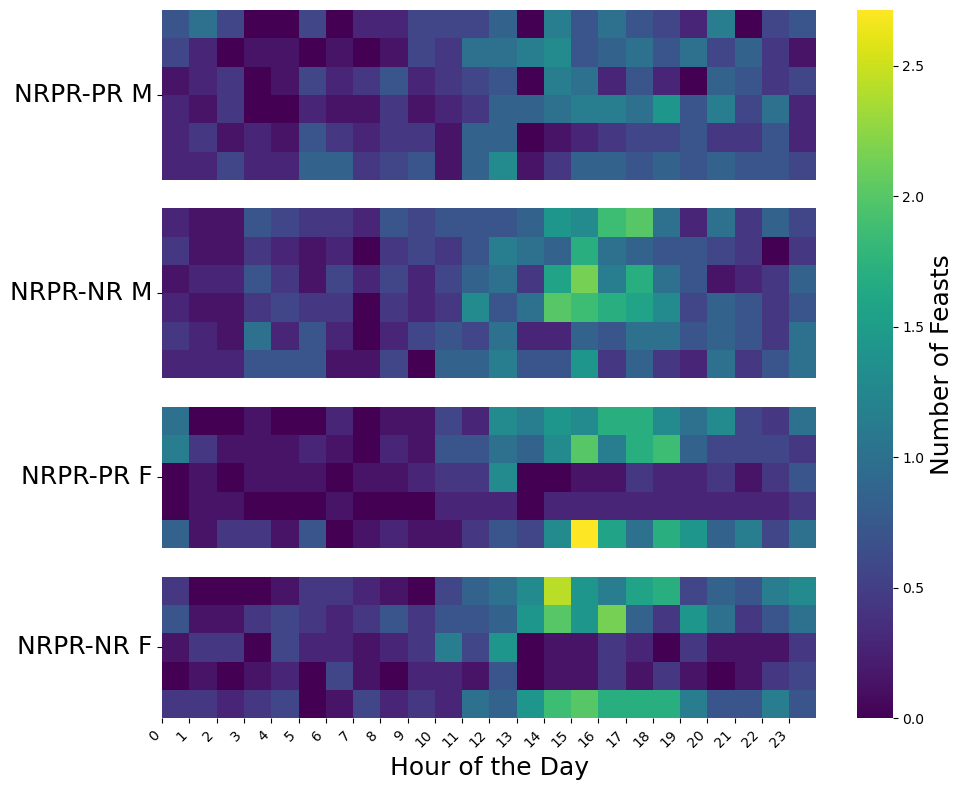

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly pellet intake for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly pellet intake data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly pellet intake data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly pellet intake data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly pellet intake data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    heatmap = sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Feasts'}, **kwargs)

    # Adjust the color bar label font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)  # Set the label font size

    # Calculate Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    padding_size = 1  # Padding of 1 row between groups
    cumulative_lengths = np.cumsum([0] + [length + padding_size for length in group_lengths[:-1]])
    y_positions = [cum + (length / 2) for cum, length in zip(cumulative_lengths, group_lengths)]  # Center the labels

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=18)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')
    ax.set_xlabel("Hour of the Day", fontsize=18)

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly pellet intake data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_mega_meals"], nrpr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_mega_meals"], nrpr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_mega_meals"], nrpr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_mega_meals"], nrpr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["NRPR-PR M", "NRPR-NR M", "NRPR-PR F", "NRPR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
5 items in output dictionary


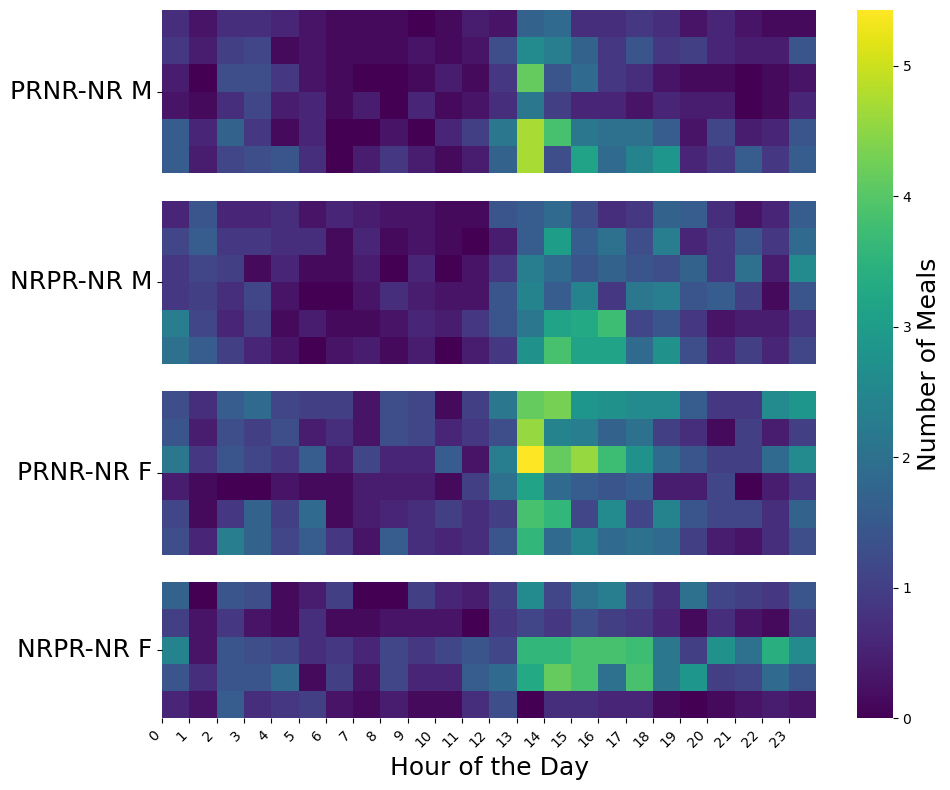

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly pellet intake for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly pellet intake data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly pellet intake data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly pellet intake data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly pellet intake data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    heatmap = sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Meals'}, **kwargs)

    # Adjust the color bar label font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)  # Set the label font size

    # Calculate Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    padding_size = 1  # Padding of 1 row between groups
    cumulative_lengths = np.cumsum([0] + [length + padding_size for length in group_lengths[:-1]])
    y_positions = [cum + (length / 2) for cum, length in zip(cumulative_lengths, group_lengths)]  # Center the labels

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=18)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')
    ax.set_xlabel("Hour of the Day", fontsize=18)

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly pellet intake data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_meals"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_meals"], nrpr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_meals"], prnr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_meals"], nrpr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["PRNR-NR M", "NRPR-NR M", "PRNR-NR F", "NRPR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
5 items in output dictionary


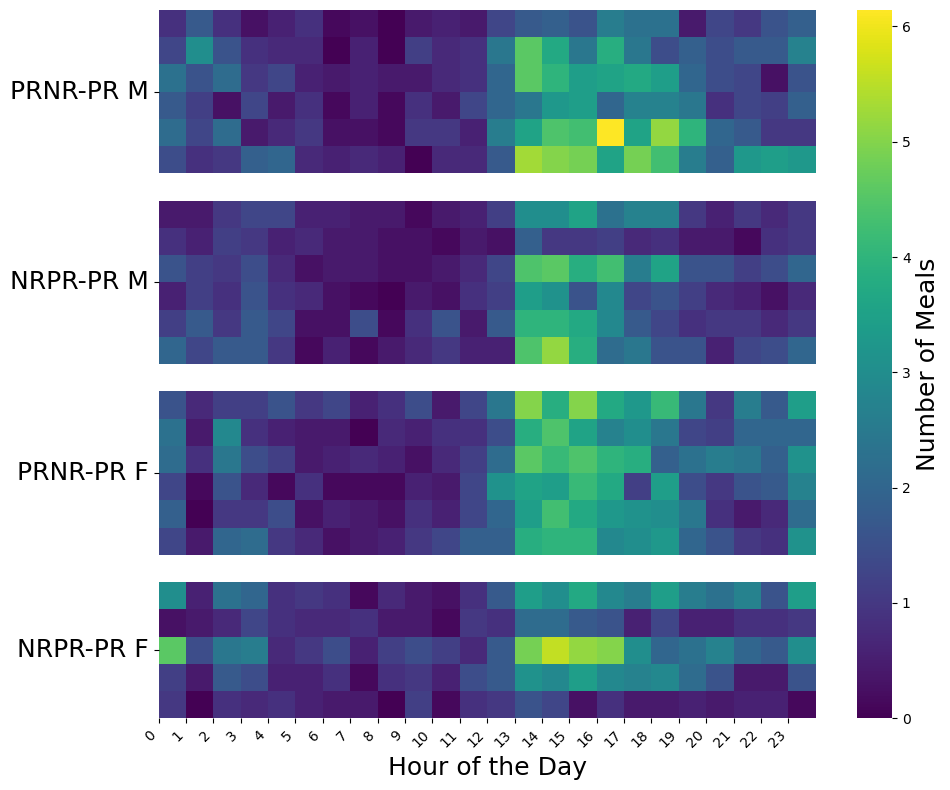

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly pellet intake for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly pellet intake data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly pellet intake data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly pellet intake data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly pellet intake data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    heatmap = sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Meals'}, **kwargs)

    # Adjust the color bar label font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)  # Set the label font size

    # Calculate Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    padding_size = 1  # Padding of 1 row between groups
    cumulative_lengths = np.cumsum([0] + [length + padding_size for length in group_lengths[:-1]])
    y_positions = [cum + (length / 2) for cum, length in zip(cumulative_lengths, group_lengths)]  # Center the labels

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=18)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')
    ax.set_xlabel("Hour of the Day", fontsize=18)

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly pellet intake data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_meals"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_meals"], nrpr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_meals"], prnr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_meals"], nrpr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["PRNR-PR M", "NRPR-PR M", "PRNR-PR F", "NRPR-PR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary


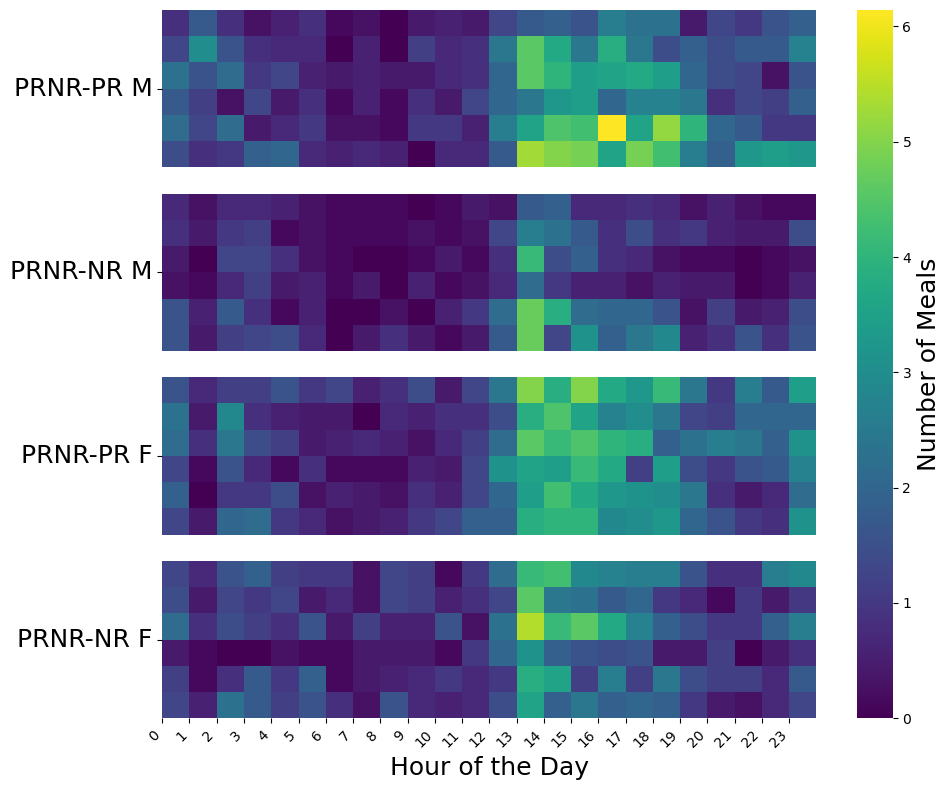

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly pellet intake for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly pellet intake data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly pellet intake data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly pellet intake data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly pellet intake data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    heatmap = sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Meals'}, **kwargs)

    # Adjust the color bar label font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)  # Set the label font size

    # Calculate Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    padding_size = 1  # Padding of 1 row between groups
    cumulative_lengths = np.cumsum([0] + [length + padding_size for length in group_lengths[:-1]])
    y_positions = [cum + (length / 2) for cum, length in zip(cumulative_lengths, group_lengths)]  # Center the labels

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=18)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')
    ax.set_xlabel("Hour of the Day", fontsize=18)

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly pellet intake data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_meals"], prnr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_meals"], prnr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_meals"], prnr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_meals"], prnr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["PRNR-PR M", "PRNR-NR M", "PRNR-PR F", "PRNR-NR F"], tick_step=1)

plt.show()


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
5 items in output dictionary


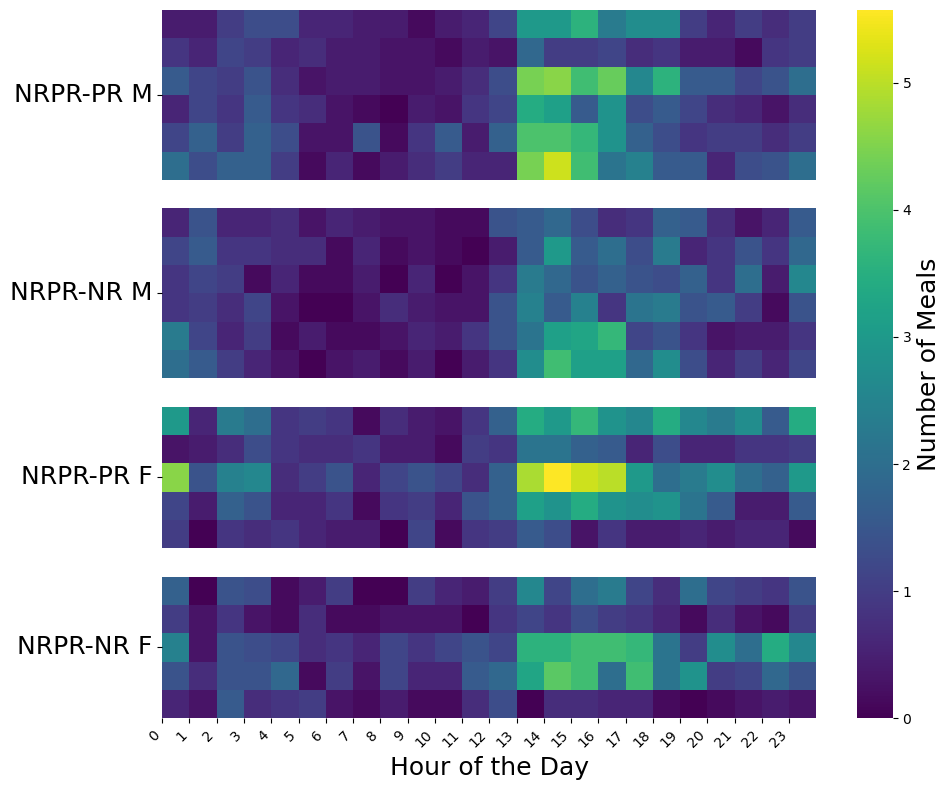

In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def hourly_meals_heatmap(data1, data2, data3, data4, ax=None, labels=["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"], tick_step=1, **kwargs):
    """
    Create a heatmap of hourly pellet intake for four groups of male and female mice, averaging across 7 days,
    and ensuring proper label separation.
    
    Parameters
    ----------
    data1 : list
        List contains hourly pellet intake data for group 1 (e.g., NRPR-NR M).
    data2 : list
        List contains hourly pellet intake data for group 2 (e.g., PRNR-NR M).
    data3 : list
        List contains hourly pellet intake data for group 3 (e.g., NRPR-NR F).
    data4 : list
        List contains hourly pellet intake data for group 4 (e.g., PRNR-NR F).
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, a new Figure and Axes are created if not passed.
    labels : list of str, optional
        Labels for the datasets (groups), by default ["NRPR-NR M", "PRNR-NR M", "NRPR-NR F", "PRNR-NR F"].
    tick_step : int, optional
        Step size for the x-axis ticks to avoid overcrowding, by default 1.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Average across 7 days to get (mice, 24 hours)
    hourly_meals1 = np.mean(np.array(data1), axis=1)  # Expect shape (6, 24) for NRPR-NR M
    hourly_meals2 = np.mean(np.array(data2), axis=1)  # Expect shape (6, 24) for PRNR-NR M
    hourly_meals3 = np.mean(np.array(data3), axis=1)  # Expect shape (5, 24) for NRPR-NR F
    hourly_meals4 = np.mean(np.array(data4), axis=1)  # Expect shape (6, 24) for PRNR-NR F (6 mice)

    # Add padding between the datasets
    padding = np.full((1, 24), np.nan)  # 1-row padding with NaN for separation
    data_matrix = np.vstack([hourly_meals1, padding, hourly_meals2, padding, hourly_meals3, padding, hourly_meals4])

    # Create the heatmap
    heatmap = sns.heatmap(data_matrix, ax=ax, cmap="viridis", cbar_kws={'label': 'Number of Meals'}, **kwargs)

    # Adjust the color bar label font size
    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(18)  # Set the label font size

    # Calculate Y-tick labels and positions, ensuring separation
    group_lengths = [hourly_meals1.shape[0], hourly_meals2.shape[0], hourly_meals3.shape[0], hourly_meals4.shape[0]]
    padding_size = 1  # Padding of 1 row between groups
    cumulative_lengths = np.cumsum([0] + [length + padding_size for length in group_lengths[:-1]])
    y_positions = [cum + (length / 2) for cum, length in zip(cumulative_lengths, group_lengths)]  # Center the labels

    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels, rotation=0, va="center", fontsize=18)

    # Set X-axis ticks (hour of the day)
    ax.set_xticks(np.arange(0, 24, tick_step))
    ax.set_xticklabels([str(i) for i in range(24)], rotation=45, ha='right')
    ax.set_xlabel("Hour of the Day", fontsize=18)

    # Adjust layout to avoid label overlapping
    plt.tight_layout()

    return ax

# Fetching the hourly pellet intake data for NRPR-NR and PRNR-NR male and female mice
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

pr_hourly_meals_m_prnr = get_data_fields(mice, ["pr_hourly_meals"], nrpr_male_selector)
nr_hourly_meals_m_prnr = get_data_fields(mice, ["nr_hourly_meals"], nrpr_male_selector)
pr_hourly_meals_f_prnr = get_data_fields(mice, ["pr_hourly_meals"], nrpr_female_selector)
nr_hourly_meals_f_prnr = get_data_fields(mice, ["nr_hourly_meals"], nrpr_female_selector)

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(10, 8))

hourly_meals_heatmap(pr_hourly_meals_m_prnr, nr_hourly_meals_m_prnr, 
                     pr_hourly_meals_f_prnr, nr_hourly_meals_f_prnr, 
                     ax=ax, labels=["NRPR-PR M", "NRPR-NR M", "NRPR-PR F", "NRPR-NR F"], tick_step=1)

plt.show()


# Cell below plotting bodyweight of mice during the course of experiment

C:\Users\hta031\AppData\Local\Temp\ipykernel_74364\1771536507.py:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(range(max_days), reference_weight, 'k--', label="C57BL/6J Reference", color='gold', linewidth=2)


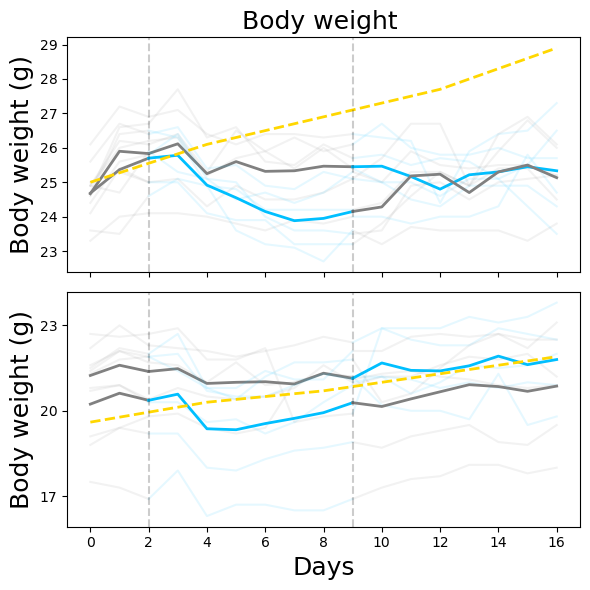

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the body weight data
file_path = '../results/resultbodyweights.csv'
bodyweight_data_new = pd.read_csv(file_path)

# Define the plotting functions
def timeline_multicolor_fig_with_reference(data, reference_weight, ax=[], ylabel="", colors=[], day_split=[2, 9], max_days=17, **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new axis if none is provided

    # Reverse the colors for alternate groups
    colors_reversed = colors[::-1]

    # Plot the data for each group
    for group in data:
        for trace in group:
            trace = trace[:max_days]
            ax.plot(range(0, 3), trace[:3], color="grey", alpha=0.1)
            ax.plot(range(2, 10), trace[2:10], color=colors[0], alpha=0.1)
            ax.plot(range(9, len(trace)), trace[9:], color=colors[1], alpha=0.1)

        mean = np.mean(group, axis=0)[:max_days]
        ax.plot(range(0, 3), mean[:3], color="grey", linewidth=2)
        ax.plot(range(2, 10), mean[2:10], color=colors[0], linewidth=2)
        ax.plot(range(9, len(mean)), mean[9:], color=colors[1], linewidth=2)

        colors.reverse()  # Reverse the colors for the next group

    # Add reference line for C57BL/6J mice
    ax.plot(range(max_days), reference_weight, 'k--', label="C57BL/6J Reference", color='gold', linewidth=2)

    ax.set_ylabel(ylabel, fontsize=18)
    ax.axvline(2, linestyle="--", color="k", alpha=0.2)
    ax.axvline(9, linestyle="--", color="k", alpha=0.2)

    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

    return ax

# Correct the data ordering for NRPR and PRNR groups across all 17 days

# NRPR group: First G columns, then NR columns, then PR columns
nrpr_male_data_corrected_full = np.hstack([bodyweight_data_new[(bodyweight_data_new['Sex'] == 'M') & (bodyweight_data_new['Order'] == 'NRPR')].iloc[:, :3].values,
                                           bodyweight_data_new[(bodyweight_data_new['Sex'] == 'M') & (bodyweight_data_new['Order'] == 'NRPR')].iloc[:, 3:10].values,
                                           bodyweight_data_new[(bodyweight_data_new['Sex'] == 'M') & (bodyweight_data_new['Order'] == 'NRPR')].iloc[:, 10:17].values])

nrpr_female_data_corrected_full = np.hstack([bodyweight_data_new[(bodyweight_data_new['Sex'] == 'F') & (bodyweight_data_new['Order'] == 'NRPR')].iloc[:, :3].values,
                                             bodyweight_data_new[(bodyweight_data_new['Sex'] == 'F') & (bodyweight_data_new['Order'] == 'NRPR')].iloc[:, 3:10].values,
                                             bodyweight_data_new[(bodyweight_data_new['Sex'] == 'F') & (bodyweight_data_new['Order'] == 'NRPR')].iloc[:, 10:17].values])

# PRNR group: First G columns, then PR columns, then NR columns
prnr_male_data_corrected_full = np.hstack([bodyweight_data_new[(bodyweight_data_new['Sex'] == 'M') & (bodyweight_data_new['Order'] == 'PRNR')].iloc[:, :3].values,
                                           bodyweight_data_new[(bodyweight_data_new['Sex'] == 'M') & (bodyweight_data_new['Order'] == 'PRNR')].iloc[:, 10:17].values,
                                           bodyweight_data_new[(bodyweight_data_new['Sex'] == 'M') & (bodyweight_data_new['Order'] == 'PRNR')].iloc[:, 3:10].values])

prnr_female_data_corrected_full = np.hstack([bodyweight_data_new[(bodyweight_data_new['Sex'] == 'F') & (bodyweight_data_new['Order'] == 'PRNR')].iloc[:, :3].values,
                                             bodyweight_data_new[(bodyweight_data_new['Sex'] == 'F') & (bodyweight_data_new['Order'] == 'PRNR')].iloc[:, 10:17].values,
                                             bodyweight_data_new[(bodyweight_data_new['Sex'] == 'F') & (bodyweight_data_new['Order'] == 'PRNR')].iloc[:, 3:10].values])

# Interpolated data for C57BL/6J mice (as calculated previously)
weeks = [8, 9, 10, 11, 12]  # Given weeks
male_weights = [25.0, 26.1, 26.9, 27.7, 28.9]  # Corresponding male weights
female_weights = [19.6, 20.3, 20.7, 21.3, 21.9]  # Corresponding female weights

# Create interpolation for 17 days
days = np.linspace(0, 4, 17)  # 17 days between week 8 and week 12
male_interpolated = np.interp(days, range(5), male_weights)
female_interpolated = np.interp(days, range(5), female_weights)

# Now let's plot the corrected full data across all 17 days
f, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))

# Plot for males (NRPR and PRNR) with interpolated C57BL/6J male reference
timeline_multicolor_fig_with_reference([nrpr_male_data_corrected_full, prnr_male_data_corrected_full], male_interpolated, colors=["grey", "deepskyblue"], ylabel="Body weight (g)", ax=ax[0])

# Plot for females (NRPR and PRNR) with interpolated C57BL/6J female reference
timeline_multicolor_fig_with_reference([nrpr_female_data_corrected_full, prnr_female_data_corrected_full], female_interpolated, colors=["grey", "deepskyblue"], ylabel="Body weight (g)", ax=ax[1])

# Add title and common labels
ax[1].set_xlabel("Days", fontsize=18)
ax[1].set_yticks([17, 20, 23])
ax[0].set_title("Body weight ", fontsize=18)

plt.tight_layout()
plt.show()
